In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

####################################################################################################
### Select SSIC Hierarchical Level

# 1. 'Section'
# 2. 'Division'
# 3. 'Group'
# 4. 'Class'
# 5. 'Subclass'

level = 'Class' 
topn = 3
####################################################################################################

# create ssic denormalized fact table
ssic_detailed_def_filepath = r"dataSources/DoS/ssic2020-detailed-definitions.xlsx"
ssic_alpha_index_filepath = r"dataSources/DoS/ssic2020-alphabetical-index.xlsx"

df_detailed_def = pd.read_excel(ssic_detailed_def_filepath, skiprows=4)
df_alpha_index = pd.read_excel(ssic_alpha_index_filepath, dtype=str, skiprows=5)
df_alpha_index = df_alpha_index.drop(df_alpha_index.columns[2], axis=1).dropna().rename(columns={'SSIC 2020': 'SSIC 2020','SSIC 2020 Alphabetical Index Description': 'Detailed Definitions'})

df_concat = pd.concat([df_detailed_def, df_alpha_index])

####################################################################################################
### Select which fact table to train/transform
# - df_detailed_def
# - df_concat       (concat of df_detailed_def and df_alpha_index)

df_data_dict = df_detailed_def 
####################################################################################################

# prep ssic_n tables for joining/merging and reference
# Section, 1-alpha 
ssic_1_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 1)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code']) 
ssic_1_raw['Groups Classified Under this Code'] = ssic_1_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_1 = ssic_1_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_1['Groups Classified Under this Code'] = ssic_1['Groups Classified Under this Code'].str.replace('•', '')
ssic_1['Section, 2 digit code'] = ssic_1['Groups Classified Under this Code'].str[0:2]
ssic_1 = ssic_1.rename(columns={'SSIC 2020': 'Section','SSIC 2020 Title': 'Section Title'})

# Division, 2-digit
ssic_2_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 2)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_2_raw['Groups Classified Under this Code'] = ssic_2_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_2 = ssic_2_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_2['Groups Classified Under this Code'] = ssic_2['Groups Classified Under this Code'].str.replace('•', '')
ssic_2 = ssic_2.rename(columns={'SSIC 2020': 'Division','SSIC 2020 Title': 'Division Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Group, 3-digit 
ssic_3_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 3)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_3_raw['Groups Classified Under this Code'] = ssic_3_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_3 = ssic_3_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_3['Groups Classified Under this Code'] = ssic_3['Groups Classified Under this Code'].str.replace('•', '')
ssic_3 = ssic_3.rename(columns={'SSIC 2020': 'Group','SSIC 2020 Title': 'Group Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Class, 4-digit
ssic_4_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 4)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_4_raw['Groups Classified Under this Code'] = ssic_4_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_4 = ssic_4_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_4['Groups Classified Under this Code'] = ssic_4['Groups Classified Under this Code'].str.replace('•', '')
ssic_4 = ssic_4.rename(columns={'SSIC 2020': 'Class','SSIC 2020 Title': 'Class Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Sub-class, 5-digit
ssic_5 = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 5)].reset_index(drop=True).drop(columns=['Groups Classified Under this Code'])
ssic_5.replace('<Blank>', '', inplace=True)
ssic_5.replace('NaN', '', inplace=True)

# prep join columns
ssic_5['Section, 2 digit code'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Division'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Group'] = ssic_5['SSIC 2020'].astype(str).str[:3]
ssic_5['Class'] = ssic_5['SSIC 2020'].astype(str).str[:4]

# join ssic_n Hierarhical Layer Tables (Section, Division, Group, Class, Sub-Class)
ssic_df = pd.merge(ssic_5, ssic_1[['Section', 'Section Title', 'Section, 2 digit code']], on='Section, 2 digit code', how='left')
ssic_df = pd.merge(ssic_df, ssic_2[['Division', 'Division Title']], on='Division', how='left')
ssic_df = pd.merge(ssic_df, ssic_3[['Group', 'Group Title']], on='Group', how='left')
ssic_df = pd.merge(ssic_df, ssic_4[['Class', 'Class Title']], on='Class', how='left')


# mapping
level_map = {
    'Section': ('Section', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_1.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_section_classifier", ssic_1),
    'Division': ('Division', ssic_df.iloc[:, [0, 1, 6, 10, 11, 12, 13]].drop_duplicates(), ssic_2.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_division_classifier", ssic_2),
    'Group': ('Group', ssic_df.iloc[:, [0, 1, 7, 10, 11, 12, 13]].drop_duplicates(), ssic_3.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_group_classifier", ssic_3),
    'Class': ('Class', ssic_df.iloc[:, [0, 1, 8, 10, 11, 12, 13]].drop_duplicates(), ssic_4.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_class_classifier", ssic_4),
    'Subclass': ('SSIC 2020', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_5.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_subclass_classifier", ssic_5)
}

# Get the values for a and b based on the lvl_train
lvl_train, df_streamlit, ssic_n_sl, model, ssic_lvl = level_map.get(level, ('default_a', 'default_b', 'default_c', 'default_d', 'default_e', 'default_f'))
lvl_train_title = lvl_train + " Title"

# prep ssic_n dictionary df_prep
df_prep = ssic_df[[lvl_train, 'Detailed Definitions']]
df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
df_prep = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()

# load model directly from huggingface
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model)
model = TFAutoModelForSequenceClassification.from_pretrained(model)

# Define the function to predict scores and categories
def predict_text(text, tokenizer, model):
    # Ensure the input text is a string and check if it is blank
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Tokenize the input text
    predict_input = tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )
    
    # Get the model output
    output = model(predict_input)[0]
    output_array = output.numpy()[0] 
    
    # Get the probabilities
    probs = tf.nn.softmax(output_array)
    
    # Get the top 10 predicted classes and their confidence scores
    top_10_indices = tf.argsort(probs, direction='DESCENDING')[:topn].numpy()
    return tuple(int(idx) for idx in top_10_indices)

    # top_10_probs = tf.gather(probs, top_10_indices).numpy()
    # top_10_predictions = [(int(idx), float(prob)) for idx, prob in zip(top_10_indices, top_10_probs)]
    
    # return top_10_predictions

def apply_model_to_column(df, input_col, output_col):
   
    def map_values(value_list):
        # Prepare the merged DataFrame
        lvl_dict = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()
        lvl_ref = ssic_lvl[[lvl_train, lvl_train_title]].drop_duplicates()
        merged_df = lvl_dict.merge(lvl_ref, on=lvl_train, how='left')
        
        # Create a mapping dictionary from the reference table
        mapping_dict = dict(zip(merged_df['encoded_cat'], merged_df[lvl_train]))
        
        return [mapping_dict.get(item, item) for item in value_list]
    
    def predict_and_map(text):
        predictions = predict_text(text, tokenizer, model)
        return map_values(predictions)
    
    # Apply the predict_and_map function to the specified column and store results in a new column
    df[output_col] = df[input_col].apply(predict_and_map)
    return df


import pandas as pd
list_df_filepath = r"dataSources\ScrapedOutputFiles\(Roy) List of 90 Coy and SSIC.csv"
list_df = pd.read_csv(list_df_filepath, dtype = str)

# Create new columns
list_df['Division'] = list_df['ssic_code'].str[:2]
list_df['Group'] = list_df['ssic_code'].str[:3]
list_df['Class'] = list_df['ssic_code'].str[:4]
list_df['Sub-class'] = list_df['ssic_code']

list_df['Division2'] = list_df['ssic_code2'].str[:2]
list_df['Group2'] = list_df['ssic_code2'].str[:3]
list_df['Class2'] = list_df['ssic_code2'].str[:4]
list_df['Sub-class2'] = list_df['ssic_code2']

list_df = list_df.merge(ssic_1[['Section, 2 digit code', 'Section']], left_on='Division', right_on='Section, 2 digit code', how='left')
list_df = list_df.rename(columns={'Section': 'Section'})
list_df = list_df.merge(ssic_1[['Section, 2 digit code', 'Section']], left_on='Division2', right_on='Section, 2 digit code', how='left', suffixes=('', '2'))
list_df = list_df.rename(columns={'Section2': 'Section2'})

# Validation Data
# vdf_filepath = r"dataSources\ScrapedOutputFiles\(Roy) data validation.xlsx"
vdf_filepath = r"LLM_Test\Summarised_output_for_model.xlsx"
vdf = pd.read_excel(vdf_filepath, dtype = str)

vdf = vdf.merge(list_df[['UEN', 'ssic_code', 'ssic_code2', 'Section', 'Division', 'Group', 'Class', 'Sub-class', 'Section2', 'Division2', 'Group2', 'Class2', 'Sub-class2']], left_on='UEN Number', right_on='UEN', how='left')

# # Replace empty strings with NaN
# vdf = vdf.replace('', None)
# # Drop rows with any NaN values
# vdf = vdf.dropna()

# Create a dictionary for quick lookup for ssic_5

ssic_5_dict = ssic_5[['SSIC 2020', 'SSIC 2020 Title']].drop_duplicates().set_index('SSIC 2020')['SSIC 2020 Title'].to_dict()

# Function to create the combined title column
def get_combined_title(row):
    title1 = ssic_5_dict.get(row['ssic_code'], 'Unknown')
    title2 = ssic_5_dict.get(row['ssic_code2'], 'Unknown')
    return f"{row['ssic_code']}: {title1}\n{row['ssic_code2']}: {title2}"

# Apply the function to create the new column
vdf['ssic_code&title'] = vdf.apply(get_combined_title, axis=1)

pd.set_option('display.max_columns', None)  # None means no limit

# Summarized_Description_azma_bart / Azma_bart_tfidf
# Summarized_Description_facebook_bart / FB_bart_tfidf
# Summarized_Description_philschmid_bart / Philschmid_bart_tfidf

vdf = apply_model_to_column(vdf, 'Summarized_Description_azma_bart', 'p_sd_azma_bart')
vdf = apply_model_to_column(vdf, 'Summarized_Description_facebook_bart', 'p_sd_fb_bart')
vdf = apply_model_to_column(vdf, 'Summarized_Description_philschmid_bart', 'p_sd_philschmid_bart')
vdf = apply_model_to_column(vdf, 'Azma_bart_tfidf', 'p_azma_bart_tfidf')
vdf = apply_model_to_column(vdf, 'FB_bart_tfidf', 'p_fb_bart_tfidf')
vdf = apply_model_to_column(vdf, 'Philschmid_bart_tfidf', 'p_philschmid_bart_tfidf')
vdf = apply_model_to_column(vdf, 'Q&A model Output', 'p_QA')


########################################################################## Translate ssic code to title desc
translate_switch = 'On'

# Step 1: Create a dictionary from ssic_df
ssic_dict = dict(zip(ssic_df['SSIC 2020'], ssic_df['SSIC 2020 Title']))

# Step 2: Define a function to map the codes to their descriptions
def map_codes_to_desc(codes):
    return '\n'.join([f"{code}: {ssic_dict.get(code, 'Description not found')}" for code in codes])

# Step 3: Apply this function to the p_columns in vdf

list_columns = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart', 'p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']

# Switch to control the execution of the code section
if translate_switch == 'On':
    # Step 3: Apply the function to each column in the list
    for column in list_columns:
        vdf[column + '_desc'] = vdf[column].apply(map_codes_to_desc)

########################################################################## Define functions to check conditions
# Create a dictionary from the reference DataFrame for mapping
ref_dict = pd.Series(ssic_1['Section'].values, index=ssic_1['Section, 2 digit code']).to_dict()

def check_section(row, ref_dict, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
    # Check if the list is empty or null
    if not predictions:
        return None
    mapped_predictions = [ref_dict.get(str(pred)[:2]) for pred in row[prediction_col_name] if str(pred)[:2] in ref_dict]
    if row['Section'] in mapped_predictions or row['Section2'] in mapped_predictions:
        return 'Y'
    else:
        return 'N'

def check_division(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if the first 2 characters of any item in predictions match either Group or Group2
    return 'Y' if any(item[:2] == row['Division'] or item[:2] == row['Division2'] for item in row[prediction_col_name]) else 'N'

def check_group(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if any item in predictions matches either Division or Division2
    return 'Y' if any(item[:3] == row['Group'] or item[:3] == row['Group2'] for item in row[prediction_col_name]) else 'N'

def check_class(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if any item in predictions matches either Division or Division2
    return 'Y' if any(item[:4] == row['Class'] or item[:4] == row['Class2'] for item in row[prediction_col_name]) else 'N'

def check_subclass(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if any item in predictions matches either Division or Division2
    return 'Y' if any(item[:5] == row['Sub-class'] or item[:5] == row['Sub-class2'] for item in row[prediction_col_name]) else 'N'

list_columns = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart', 'p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']

# Apply the functions to create new columns
for p_column_to_check in list_columns:
    vdf[p_column_to_check + '_Section_check'] = vdf.apply(lambda row: check_section(row, ref_dict, p_column_to_check), axis=1)
    vdf[p_column_to_check + '_Division_check'] = vdf.apply(check_division, prediction_col_name=p_column_to_check, axis=1)
    vdf[p_column_to_check + '_Group_check'] = vdf.apply(check_group, prediction_col_name=p_column_to_check, axis=1)
    vdf[p_column_to_check + '_Class_check'] = vdf.apply(check_class, prediction_col_name=p_column_to_check, axis=1)
    vdf[p_column_to_check + '_Subclass_check'] = vdf.apply(check_subclass, prediction_col_name=p_column_to_check, axis=1)

check_columns = [col for col in vdf.columns if col.endswith('_check')]

# Calculate the counts, ratios, and info_column
vdf[['count_Y', 'count_N', 'total_Y_N', 'YN_ratio', 'info_column']] = vdf.apply(
    lambda row: pd.Series({
        'count_Y': (row[check_columns] == 'Y').sum(),
        'count_N': (row[check_columns] == 'N').sum(),
        'total_Y_N': (row[check_columns] == 'Y').sum() + (row[check_columns] == 'N').sum(),
        'Y_to_N_ratio': (row[check_columns] == 'Y').sum() / (row[check_columns] == 'N').sum() if (row[check_columns] == 'N').sum() != 0 else np.nan,
        'info_column': (
            lambda counts: f"Y: {counts['Y']}/{counts['total']} ({counts['Y'] / counts['total']:.2%}), "
                          f"N: {counts['N']}/{counts['total']} ({counts['N'] / counts['total']:.2%}), "
                          f"Y:N Ratio: {counts['Y'] / counts['N'] if counts['N'] != 0 else np.nan:.2f}"
        )({
            'Y': (row[check_columns] == 'Y').sum(),
            'N': (row[check_columns] == 'N').sum(),
            'total': (row[check_columns] == 'Y').sum() + (row[check_columns] == 'N').sum()
        })
    }),
    axis=1
)

vdf.to_excel('vdf.xlsx', index=False)
# vdf.head(2)

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'SSIC2020 Detailed Definitions'!$A:$E.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Temp\ipykernel_227

Some layers from the model checkpoint at nusebacra/ssicsync_class_classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at nusebacra/ssicsync_class_classifier and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


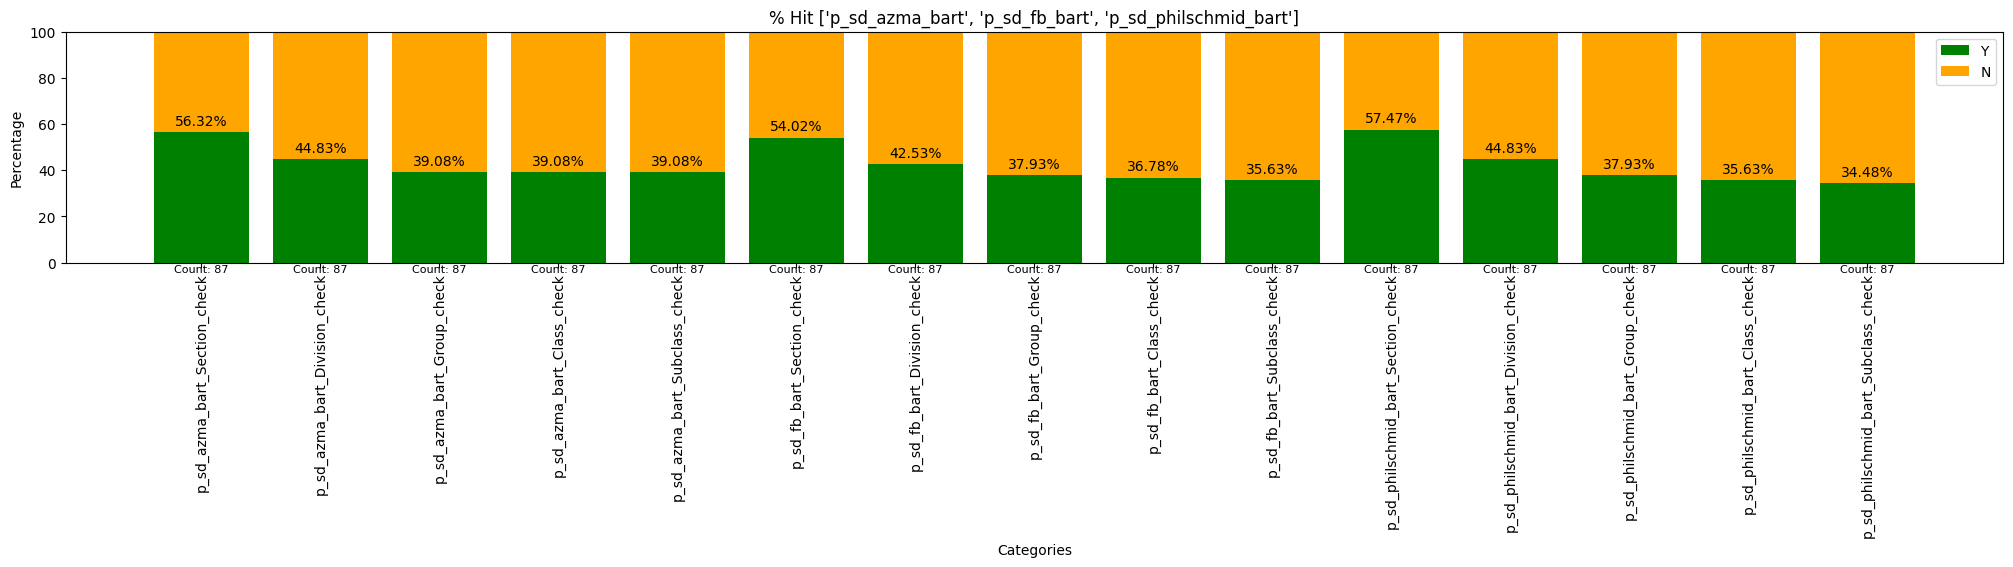

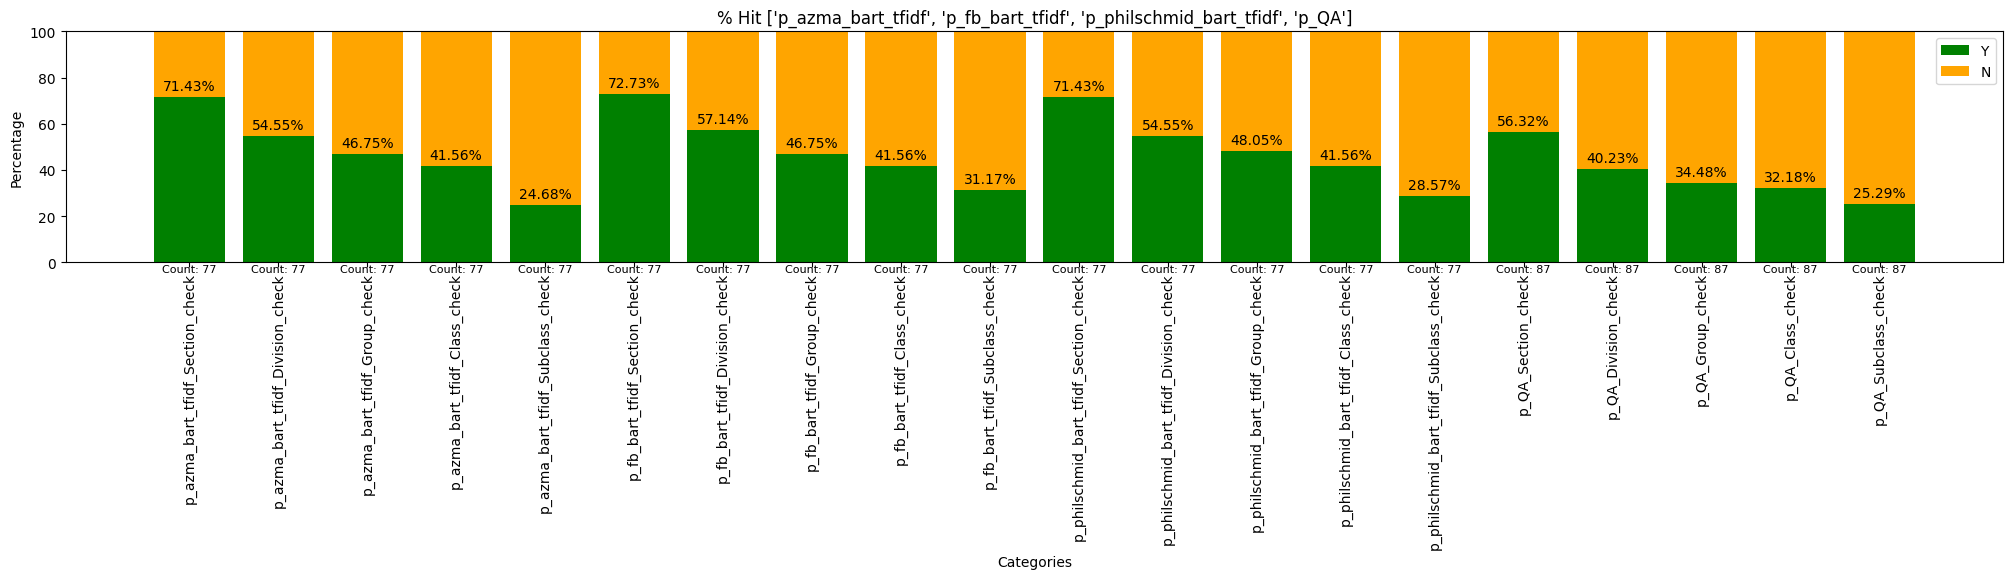

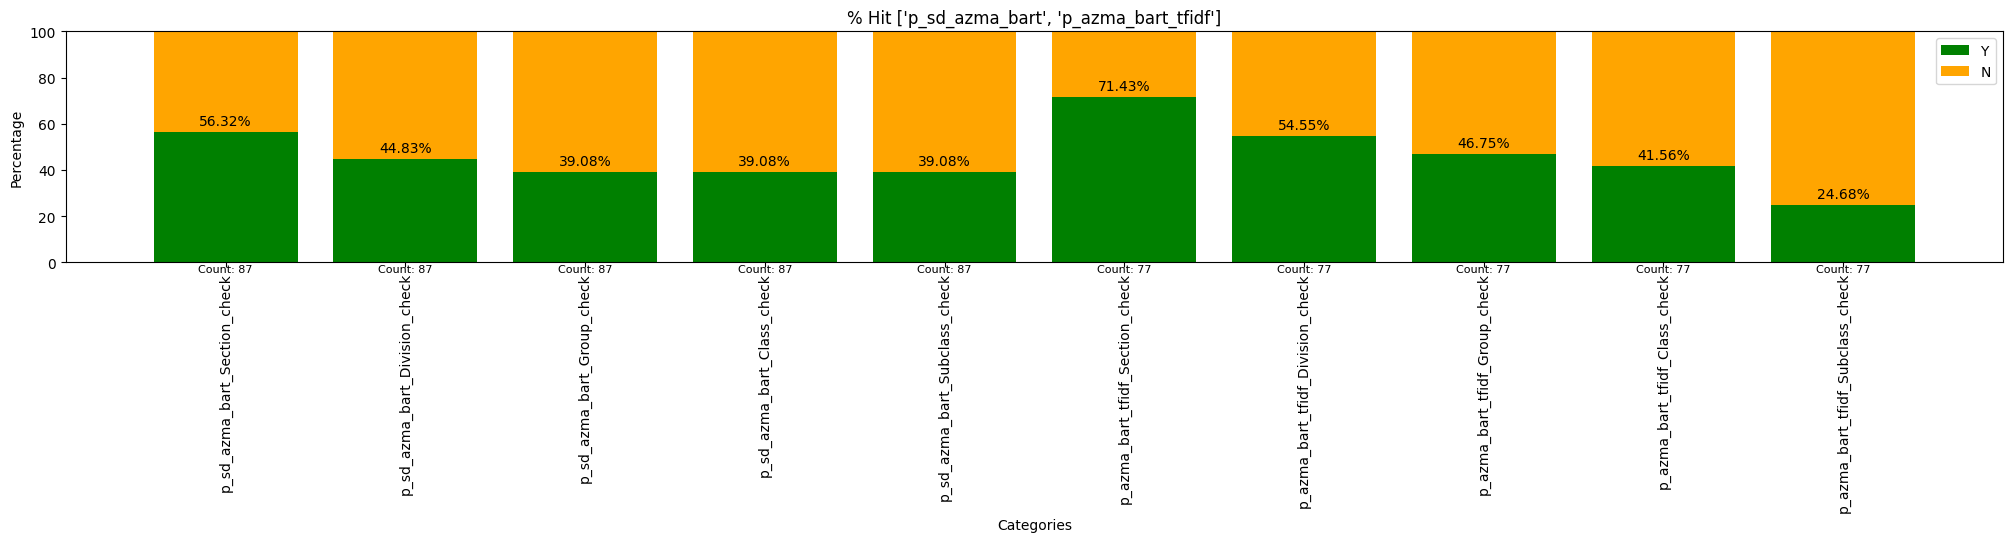

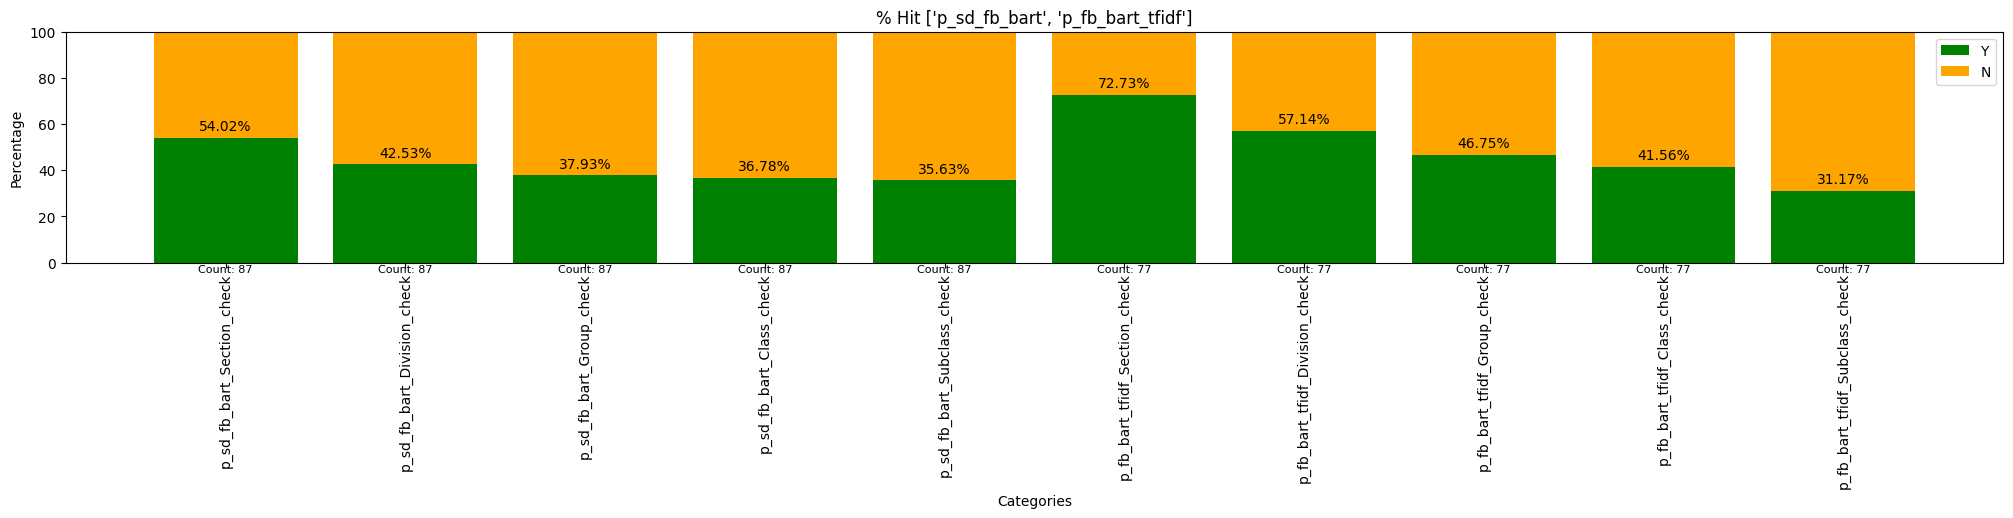

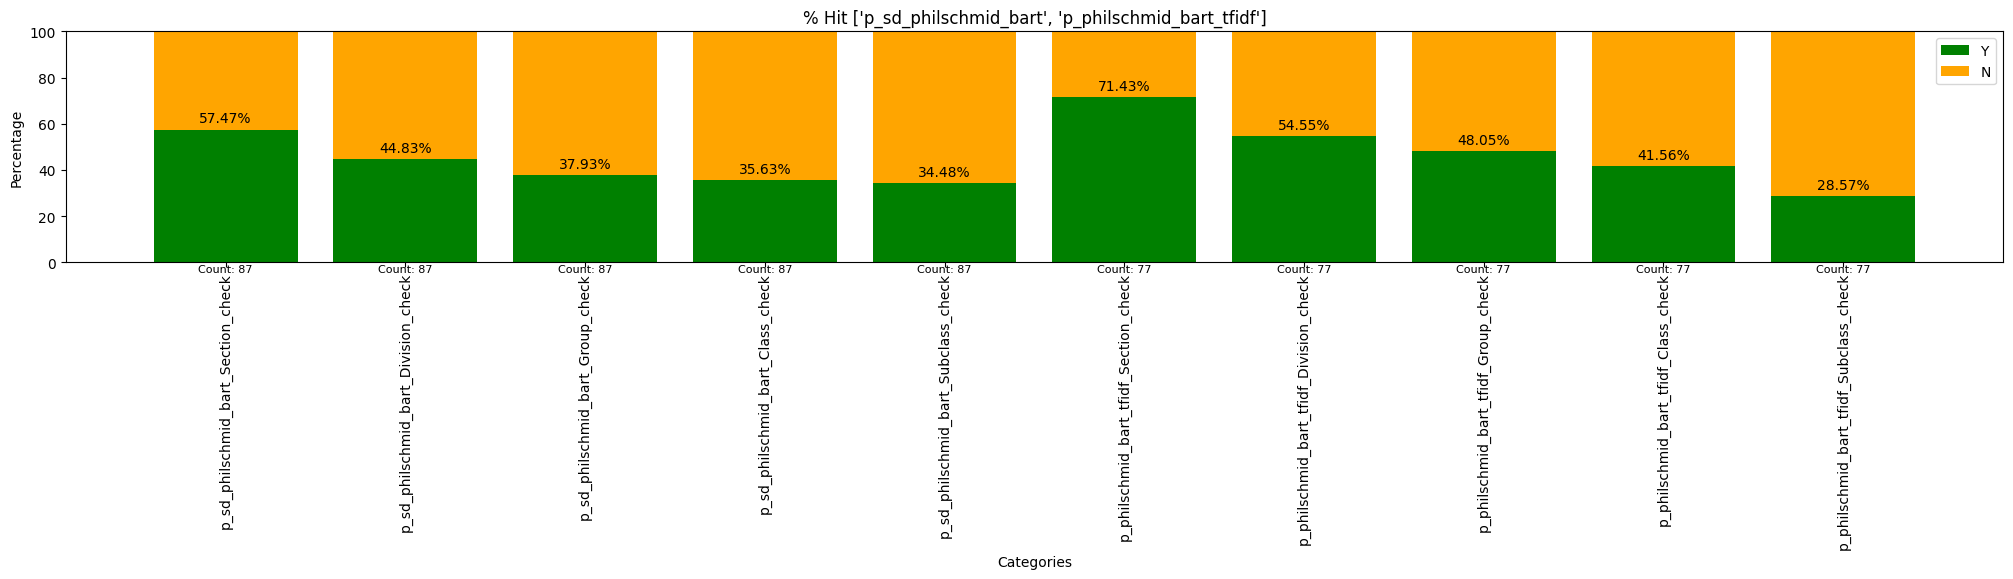

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

prefixes1 = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart']
prefixes2 = ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']
prefixes3 = ['p_sd_azma_bart', 'p_azma_bart_tfidf']
prefixes4 = ['p_sd_fb_bart', 'p_fb_bart_tfidf']
prefixes5 = ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf']

prefix_sets = [
    ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart'],
    ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA'],
    ['p_sd_azma_bart', 'p_azma_bart_tfidf'],
    ['p_sd_fb_bart', 'p_fb_bart_tfidf'],
    ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf']
]

for prefix_set in prefix_sets:
    # Create groups based on the current prefix set
    groups = {prefix: [] for prefix in prefix_set}

    for col in vdf.columns:
        if col.endswith('_check'):
            for prefix in prefix_set:
                if col.startswith(prefix):
                    groups[prefix].append(col)
                    break

    # Filter out empty groups
    groups = {k: v for k, v in groups.items() if v}

    # Calculate the percentage of 'Y' and 'N' for each column
    check_columns = [col for sublist in groups.values() for col in sublist]
    if not check_columns:
        print(f"No columns found for prefix set: {prefix_set}")
        continue
    
    # Calculate percentages and base counts
    percentages_df = vdf[check_columns].apply(lambda x: x.value_counts(normalize=True) * 100).fillna(0).transpose()
    base_counts = vdf[check_columns].notnull().sum()  # Base count of non-null records

    if percentages_df.empty:
        print(f"No data available for prefix set: {prefix_set}")
        continue

    # Plotting
    fig, ax = plt.subplots(figsize=(25, 3))

    # Check if 'Y' and 'N' columns exist in percentages_df
    if 'Y' in percentages_df.columns and 'N' in percentages_df.columns:
        bars1 = ax.bar(percentages_df.index, percentages_df['Y'], color='green', label='Y')
        bars2 = ax.bar(percentages_df.index, percentages_df['N'], bottom=percentages_df['Y'], color='orange', label='N')

        # Adding data labels for percentages
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        # Adding base count labels
        for i, col in enumerate(percentages_df.index):
            base_count = base_counts.loc[col]
            ax.text(i, -5, f'Count: {base_count}', ha='center', va='bottom', fontsize=8, color='black')

        # Customizing the plot
        ax.set_title(f'% Hit {prefix_set}')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Percentage')
        ax.set_ylim(0, 100)
        ax.legend()

        # Rotate x-axis labels for better visibility if needed
        plt.xticks(rotation=90)

        # Show plot
        plt.show()
    else:
        print(f"'Y' and/or 'N' columns not found for prefix set: {prefix_set}")

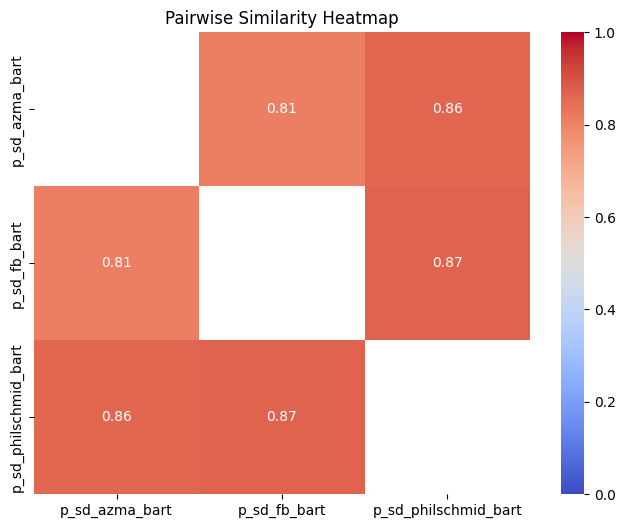

In [98]:
vdf_analysis = vdf

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists to sets
vdf_analysis['set_p_sd_azma_bart'] = vdf_analysis['p_sd_azma_bart'].apply(set)
vdf_analysis['set_p_sd_fb_bart'] = vdf_analysis['p_sd_fb_bart'].apply(set)
vdf_analysis['set_p_sd_philschmid_bart'] = vdf_analysis['p_sd_philschmid_bart'].apply(set)

# Compute Jaccard similarity between each pair of sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Calculate average pairwise similarities
def calculate_average_similarity(df):
    similarity_matrix = pd.DataFrame(index=['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart'],
                                     columns=['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart'])
    
    similarities = {
        ('p_sd_azma_bart', 'p_sd_fb_bart'): [],
        ('p_sd_fb_bart', 'p_sd_philschmid_bart'): [],
        ('p_sd_azma_bart', 'p_sd_philschmid_bart'): []
    }
    
    for index, row in df.iterrows():
        set1 = row['set_p_sd_azma_bart']
        set2 = row['set_p_sd_fb_bart']
        set3 = row['set_p_sd_philschmid_bart']
        
        similarities[('p_sd_azma_bart', 'p_sd_fb_bart')].append(jaccard_similarity(set1, set2))
        similarities[('p_sd_fb_bart', 'p_sd_philschmid_bart')].append(jaccard_similarity(set2, set3))
        similarities[('p_sd_azma_bart', 'p_sd_philschmid_bart')].append(jaccard_similarity(set1, set3))
    
    # Average similarities
    similarity_matrix.at['p_sd_azma_bart', 'p_sd_fb_bart'] = sum(similarities[('p_sd_azma_bart', 'p_sd_fb_bart')]) / len(similarities[('p_sd_azma_bart', 'p_sd_fb_bart')])
    similarity_matrix.at['p_sd_fb_bart', 'p_sd_azma_bart'] = similarity_matrix.at['p_sd_azma_bart', 'p_sd_fb_bart']
    similarity_matrix.at['p_sd_fb_bart', 'p_sd_philschmid_bart'] = sum(similarities[('p_sd_fb_bart', 'p_sd_philschmid_bart')]) / len(similarities[('p_sd_fb_bart', 'p_sd_philschmid_bart')])
    similarity_matrix.at['p_sd_philschmid_bart', 'p_sd_fb_bart'] = similarity_matrix.at['p_sd_fb_bart', 'p_sd_philschmid_bart']
    similarity_matrix.at['p_sd_azma_bart', 'p_sd_philschmid_bart'] = sum(similarities[('p_sd_azma_bart', 'p_sd_philschmid_bart')]) / len(similarities[('p_sd_azma_bart', 'p_sd_philschmid_bart')])
    similarity_matrix.at['p_sd_philschmid_bart', 'p_sd_azma_bart'] = similarity_matrix.at['p_sd_azma_bart', 'p_sd_philschmid_bart']
    
    # Ensure the DataFrame is of numeric type
    similarity_matrix = similarity_matrix.apply(pd.to_numeric, errors='coerce')

    return similarity_matrix

# Apply the similarity calculation
average_similarity_df = calculate_average_similarity(vdf)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(average_similarity_df, annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt='.2f')
plt.title('Pairwise Similarity Heatmap')
plt.show()

In [11]:
# Custom input text
input_text = "group relating design manufacture distribution paper personal business organising tools well general"

# mapping
level_map = {
    'Section': ('Section', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_1.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_section_classifier", ssic_1),
    'Division': ('Division', ssic_df.iloc[:, [0, 1, 6, 10, 11, 12, 13]].drop_duplicates(), ssic_2.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_division_classifier", ssic_2),
    'Group': ('Group', ssic_df.iloc[:, [0, 1, 7, 10, 11, 12, 13]].drop_duplicates(), ssic_3.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_group_classifier", ssic_3),
    'Class': ('Class', ssic_df.iloc[:, [0, 1, 8, 10, 11, 12, 13]].drop_duplicates(), ssic_4.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_class_classifier", ssic_4),
    'Subclass': ('SSIC 2020', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_5.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_subclass_classifier", ssic_5)
}

# Get the values for a and b based on the lvl_train
lvl_train, df_streamlit, ssic_n_sl, model, ssic_lvl = level_map.get(level, ('default_a', 'default_b', 'default_c', 'default_d', 'default_e', 'default_f'))
lvl_train_title = lvl_train + " Title"

# Define the function to predict scores and categories
def predict_text(text, tokenizer, model):
    if not isinstance(text, str) or not text.strip():
        return []

    predict_input = tokenizer.encode(text, truncation=True, padding=True, return_tensors="tf")
    output = model(predict_input)[0]
    output_array = output.numpy()[0]
    probs = tf.nn.softmax(output_array)
    top_10_indices = tf.argsort(probs, direction='DESCENDING')[:3].numpy()
    return tuple(int(idx) for idx in top_10_indices)

# Function to apply model to input text and get predictions for all levels
def apply_model_to_text(input_text):
    results = {}
    for level, (lvl_train, df_streamlit, ssic_n_sl, model_name, ssic_lvl) in level_map.items():
        lvl_train_title = lvl_train + " Title"

        df_prep = ssic_df[[lvl_train, 'Detailed Definitions']]
        df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
        df_prep = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

        predictions = predict_text(input_text, tokenizer, model)
        merged_df = df_prep.merge(ssic_lvl[[lvl_train, lvl_train_title]], on=lvl_train, how='left')
        mapping_dict = dict(zip(merged_df['encoded_cat'], merged_df[[lvl_train, lvl_train_title]].apply(tuple, axis=1)))
        mapped_values = [mapping_dict.get(pred, ('Unknown', 'Unknown')) for pred in predictions]

        # Remove duplicates from the mapped values while maintaining order
        seen = set()
        unique_mapped_values = []
        for item in mapped_values:
            if item[0] not in seen:
                unique_mapped_values.append(item)
                seen.add(item[0])

        results[level] = unique_mapped_values
    
    return results

# Get the results for the custom input text
results = apply_model_to_text(input_text)
print(results)

C:\Users\royle\AppData\Local\Temp\ipykernel_22792\2348857517.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
Some layers from the model checkpoint at nusebacra/ssicsync_section_classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly id

{'Section': [('M', 'PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES'), ('C', 'MANUFACTURING'), ('S', 'OTHER SERVICE ACTIVITIES')], 'Division': [('74', 'OTHER PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES'), ('71', 'ARCHITECTURAL AND ENGINEERING ACTIVITIES; TECHNICAL TESTING AND ANALYSIS'), ('62', 'COMPUTER PROGRAMMING, INFORMATION TECHNOLOGY CONSULTANCY AND RELATED ACTIVITIES')], 'Group': [('741', 'SPECIALISED DESIGN ACTIVITIES'), ('181', 'PRINTING AND SERVICE ACTIVITIES RELATED TO PRINTING'), ('329', 'OTHER MANUFACTURING N.E.C.')], 'Class': [('6201', 'Computer Programming Activities'), ('7112', 'Engineering Design and Consultancy Activities'), ('3290', 'Other Manufacturing n.e.c.')], 'Subclass': [('71122', 'Process and industrial plant engineering design and consultancy services'), ('58120', 'Publishing of directories and mailing lists (including financial databases)'), ('62011', 'Development of software and applications (except games and cybersecurity)')]}


In [12]:
results

{'Section': [('M', 'PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES'),
  ('C', 'MANUFACTURING'),
  ('S', 'OTHER SERVICE ACTIVITIES')],
 'Division': [('74',
   'OTHER PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES'),
  ('71',
   'ARCHITECTURAL AND ENGINEERING ACTIVITIES; TECHNICAL TESTING AND ANALYSIS'),
  ('62',
   'COMPUTER PROGRAMMING, INFORMATION TECHNOLOGY CONSULTANCY AND RELATED ACTIVITIES')],
 'Group': [('741', 'SPECIALISED DESIGN ACTIVITIES'),
  ('181', 'PRINTING AND SERVICE ACTIVITIES RELATED TO PRINTING'),
  ('329', 'OTHER MANUFACTURING N.E.C.')],
 'Class': [('6201', 'Computer Programming Activities'),
  ('7112', 'Engineering Design and Consultancy Activities'),
  ('3290', 'Other Manufacturing n.e.c.')],
 'Subclass': [('71122',
   'Process and industrial plant engineering design and consultancy services'),
  ('58120',
   'Publishing of directories and mailing lists (including financial databases)'),
  ('62011',
   'Development of software and applications (except games an

In [5]:
# Step 1: Install ollama -> https://ollama.com/
# Step 2: Open Command Prompt, run 'ollama run <model_name>' | List of available models -> https://ollama.com/library
# Step 3: Open ipynb or py, pip install ollama

# !pip install ollama

import ollama

### General description paragraph
# Founded in Singapore in 1998, Acesian Partners Limited (“Acesian” or the “Company”,
# formerly known as Linair Technologies Limited) is a multi-disciplinary group serving
# as a one-stop provider of environmental solutions and integrated services to
# diverse industries including the semiconductor, healthcare, electric vehicles battery,
# wastewater treatment, chemical, pharmaceutical and biotechnological industries.
# The Company was successfully listed on the SGX Sesdaq (now known as Catalist) in
# February 2005.

### Notes to the financial statement
# Acesian Partners Limited (the “Company”) is a limited liability company incorporated and domiciled in
# Singapore and listed on the Catalist Board of the Singapore Exchange Securities Trading Limited (‘’SGX-ST’’).
# The registered office and principal place of business of the Company is located at 33 Mactaggart Road, #04-00
# Lee Kay Huan Building, Singapore 368082.
# The principal activities of the Group consist of design, manufacture and supply of critical airflow and related
# products and investment

response = ollama.chat(model='llama3.1', messages=[
  {
    'role': 'user',
    'content': '''

Acesian Partners Limited (the “Company”) is a limited liability company incorporated and domiciled in
Singapore and listed on the Catalist Board of the Singapore Exchange Securities Trading Limited (‘’SGX-ST’’).
The registered office and principal place of business of the Company is located at 33 Mactaggart Road, #04-00
Lee Kay Huan Building, Singapore 368082.
The principal activities of the Group consist of design, manufacture and supply of critical airflow and related
products and investment
    
    extract and summarize only business activity in 1 sentence
    ''',
  },
])
print(response['message']['content'])

The company's sole business is acting as a Relevant Intermediary, providing nominee services to hold shares on behalf of banking corporations and other capital markets service license holders.


In [4]:
content2 = '''
This document has been reviewed by the Company’s Sponsor, Asian Corporate Advisors Pte. Ltd. (the “Sponsor”). It has not been examined or approved by the
Singapore Exchange Securities Trading Limited (the “Exchange”) and the Exchange assumes no responsibility for the contents of this document, including the
correctness of any of the statements or opinions made or reports contained in this document.
The contact person for the Sponsor is Mr. Liau H.K., at 160 Robinson Road, #21-05 SBF Center, Singapore 068914, telephone number: 6221 0271
CONTENTS
1
2
4
5
5
6
7
17
40
Corporate Profile
Letter to Shareholders
Board of Directors
Senior Management
Corporate Structure
Corporate Information
Sustainability Report
Corporate Governance
Financial Contents
ACESIAN PARTNERS LIMITED 1
CRITICAL AIRFLOW DESIGN AND SUPPLY
Tapping into the experience of our key global partners,
Acesian has established a strong position in the duct
manufacturing industry. Our manufacturing capability
encompasses Ethylene Tetrafluoroethylene (“ETFE”)
coated stainless steel ducts, uncoated welded stainless
steel ducts, and other specialised exhaust system
components.
Acesian’s competitive advantage is our FM approved
status (an international commercial and industrial
property insurance and risk management organisation)
for production of ETFE-coated stainless steel ductworks,
which is marketed under the brand name of CMT™. The
coating is tested and certified for compliance with ASTM
E-84 class A material standards i.e. low flame spread and
low smoke development, such that its use will significantly
reduce fire hazards to end users.
Being FM approved, our ductworks are used for fume
and smoke removal without the necessity of internal fire
protection sprinklers which are highly corrosion resistant
against both flammable and non-flammable corrosive/
toxic fumes in exhaust systems. Acesian is always at the
cutting edge of new technology to provide the best
turnkey solutions that meet the increasing demands and
expectations of our clients.
Our high quality stainless steel ductwork and accessories
are also suitable for less corrosive applications such as
heating, ventilation and air-conditioning systems for
commercial and industrial buildings.
Besides ductworks, Acesian also manufactures laboratory
air flow products. Our Isolation Dampers are designed
for effective shut-off and isolation of one or more tiers
of filters in hazardous containment exhaust systems.
In bio-hazardous environments, the dampers enable air
filtration systems to be shut off for decontamination, or
for filter changes.
Our Ecoflow Venturi fast response variable air volume
valve offers solutions for critical airflow control
application in laboratories and healthcare facilities,
clean rooms and also Universities, which require proper
directional airflow and safe working environment. The
valve, with state-of-the-art venturi flow measurement
coupled with a high accuracy flow sensor, provides
real-time “true” flow feedback which is essential in
critical airflow control and energy use optimisation. The
valve can also be lined with FM- approved ETFE coating,
which would be the ideal choice in applications involving
the handling of highly flammable/corrosive fumes in
exhaust systems. The valve is now widely used in many
laboratories in Singapore.
INFORMATION COMMUNICATION TECHNOLOGIES
Our ICT arm specialised in design and build audio-visual
solutions, programming, installation, client training,
after-sales support and managed services to our
contractors, consultants and customers in diverse sectors
(such as commercial, financial, education), as well as to
the community.
Founded in Singapore in 1998, Acesian Partners Limited (“Acesian” or the “Company”,
formerly known as Linair Technologies Limited) is a multi-disciplinary group serving
as a one-stop provider of environmental solutions and integrated services to
diverse industries including the semiconductor, healthcare, electric vehicles battery,
wastewater treatment, chemical, pharmaceutical and biotechnological industries.
The Company was successfully listed on the SGX Sesdaq (now known as Catalist) in
February 2005.
CORPORATE PROFILE
2 ANNUAL REPORT 2022
LETTER TO SHAREHOLDERS
DEAR SHAREHOLDERS
The Group overall performed creditably well and achieved
a strong set of financial results for financial year 2022
(“FY2022”), despite operating in a volatile business
environment and facing prolonged challenges of supplychain
constraints, labour shortages and red-hot inflation.
FY2022 marked significant milestones: apart from
tremendous revenue and profit growth, the strength and
resilience of our businesses were also demonstrated. With
a nimble mindset and operational agility, we managed to
overcome obstacles and capitalise on the brisk construction
activities in the semiconductor sector. The solid performance
underscored the significant progress we have made over
the past years since our business transformations (which
first commenced in 2018), where our hard work and effort
eventually bore fruit. It is also a testament to our belief in
staying oriented and adaptive in executing and delivering
our strategic priorities. With much stronger business
fundamentals and the intent to continue building on current
strengths (both operationally and financially), we are now
moving towards developing a more dynamic, resilient and
sustainable business in this age of constant change, and
remain confident in the long-term growth prospects of our
businesses.
In FY2022, with ramped up and reinforced production
capacity and capability, the Group undertook much larger
scale projects with more demanding requirements and
delivery timeframes, and successfully fulfilled the order
deliveries despite all the challenges (in particular, labour
shortages and supply-chain disruptions). Our stronger
footing and credibility allowed us to play a more essential
role in the supply-chains of the construction and related
sectors. All these were made possible by our ability to
change operational procedures to adapt to changing
market demands and customers’ expectations as well as
gain an advantage over the competition; for instance, the
critical environment control system (which was launched
and introduced into the market last year) gained traction,
with multiple new orders received and delivered.
The semiconductor sector has gone through a volatile
period – from brisk and pent-up demand for chips to
deterioration in demand. The shift in market conditions,
coupled with geopolitical tensions and US technology
curbs on China, may have an impact on the global and
local chip sectors (particularly if chipmakers pull back with
a downturn). The market remains fluid and each situation
(with varying degrees of risk) has its pros and cons in the
context of our business, and we will continue to seize
emerging opportunities and mitigate identified risks.
We are now
moving towards
developing a more
dynamic, resilient
and sustainable
business in this
age of constant
change, and
remain confident
in the long-term
growth prospects
of our businesses.
ACESIAN PARTNERS LIMITED 3
LETTER TO SHAREHOLDERS
FINANCIAL PERFORMANCE
The Group recorded a jump of 314.0% in net profit ($7.86
million in FY2022 from $1.90 million in FY2021), on the
back of a strong performance in the critical airflow design
and supply segment. This was largely due to, among
others, improvement in business volume, pent-up demand,
progressive delivery of multiple significant new sales orders,
ramp up of our production capacity and improvement in
ECO business. The Group’s revenue increased by 157.7%
to $38.17 million (as compared to $14.81 million in FY2021).
The critical airflow design and supply segment contributed
the bulk of the Group’s revenue at 98.3%. The increase
in revenue was however offset by a reduction in revenue
from the Information and Communications Technology
(ICT) business unit. In the past few years, the Group has
restructured and eliminated its unprofitable entities, and
refocused its efforts in transforming and driving its core
business, which yielded satisfactory results.
The Group’s financial position had been strengthened
significantly, where shareholders’ funds stood at $15.62
million (FY2021: $7.73 million) and cash and cash equivalents
grew to $18.49 million (FY2021: $8.98 million).
CONTINUED GROWTH IN UNCERTAIN TIMES AND
BUILDING A SUSTAINABLE BUSINESS
Moving forward, the business may face a much more
challenging and complicated operating environment, given
the unpredictable and uncontrollable external factors on
the macro front. On the bright side, we have scaled up our
manufacturing capability and enhanced our duct fabrication
and coating processes and techniques. We have built a
much stronger team (which meets regularly and decisively
addresses pain points, bottlenecks and other issues) and
recalibrated production capacity to optimise utilisation,
which contributed to the successful fulfilment of major orders
and the strong financial results. We will stay the course and
continue to identify and leverage on critical success factors,
make changes to our operations to further heighten quality
standards and shorten delivery lead-time, and invest in our
people and capabilities. Despite exiting the acute phase of
the Covid-19 pandemic, the labour crunch continued to be
a challenge partly due to shortage and public policy, but
we have nevertheless endeavoured to build and strengthen
the core production team. With a much stronger business
platform and financial position, the Group is well-positioned
to weather the short-term headwinds.
In the short term, the macroeconomic outlook has become
more challenging with persistently high inflation and rising
interest rates, which may curb economic growth. The
Group’s businesses may be affected by customers cutting
back capital expenditure and postponing construction
projects as the economy sags, while the lingering supplychain
constraints and inflationary cost pressures continue
to plague the construction sector. The rising business costs
(due to price increases for materials, soaring inflation, the
labour crunch and higher wages) may erode our margins.
In the longer term, the major chipmakers may take a
strategic and long-term view, and as part of their efforts on
geopolitical risk diversification and supply-chain disruption
mitigation, build more chip plants where Singapore and
Malaysia remain attractive destinations. While global
chip demand has eased, market experts predict that the
semiconductor sector remains on an upward trend and
expect further growth ahead. This should prove beneficial
to our business given the advantages relating to location
proximity and speed of order fulfilment. In addition,
upcoming technologies (particularly those relating to 5G,
the automotive sector and other digital transformations)
may drive demand in the microprocessor and related
industries, and our manufacturing segment should reap the
benefits of such growth.
EXTENDING APPRECIATION
On behalf of the Board, we would like to thank and commend
all our employees for working diligently and delivering
a solid performance for the Group. We would also like to
extend our appreciation to all our stakeholders; in particular
our suppliers and customers (who have played a significant
part in our achievements), as well as our shareholders who
have trusted us and kept their faith in us all these years.
LOH YIH
Managing Director
4 ANNUAL REPORT 2022
BOARD OF DIRECTORS
Mr Loh Yih joined the Group in September 2013. He is
the Managing Director and is responsible for the overall
management and performance of the Group. He is also
the Managing Partner of MGF Management Pte Ltd, which
was an exempt fund management company that focuses
primarily on China Private Equity Investment. In 2005, he
invested in Netplus Communication Pte Ltd, an internet
service provider in Singapore. He took over as Managing
Director from 2005, restructuring and turning the company
around before selling the entity to MediaRing, a listed
company in 2006. He has a professional background
in financial services. He has held positions in merchant
banking with Standard Chartered Merchant Bank Asia
Ltd and West Merchant Bank and in audit with Ernst &
Young LLP. He currently holds directorship in other listed
company such as Ban Leong Technologies Limited. He
completed his directorship term in Weichai Power Co.
Ltd (“Weichai”), listed in HKEX and SZSE, in June 2018
but was subsequently appointed by State Owned Assets
Supervision and Administration Commission of Shandong
Provincial Government, China (SASAC), as a foreign
director of Shandong Heavy Industry Group in September
2018, a parent company of Weichai, Shantui Construction
Machinery Co Ltd and Weichai Heavy Machinery Co Ltd
listed in Shenzhen, Yangzhou Yaxing Motor Coach Co
Ltd listed in Shanghai, Kion Group AG listed in Frankfurt,
Power Solutions International Inc. listed in New York and
Ferretti Group listed in HKEX.
He graduated with a Bachelor’s Degree in Accountancy
(Honours) from National University of Singapore in 1988.
MR LOH YIH
Executive Director & Managing Director
Mr Neo Gim Kiong was appointed as the Company’s
Lead Independent Non-Executive Director on 2 August
2018 and as the Board Chairman on 17 August 2018. He
is the Chairman of the Audit Committee and Nominating
Committee and member of the Remuneration Committee.
He is the Founding Director of Dollar Tree Inc Pte Ltd, a
business advisory company incorporated in Singapore
in 2004. He is also an independent director of Ban
Leong Technologies Ltd and holds directorships in other
non-listed entities.
He graduated with a Bachelor of Science Degree in
Mathematics (Honours) from National University of
Singapore in 1993.
MR NEO GIM KIONG
Non-Executive Chairman & Lead Independent
Non-Executive Director
MR WONG KOK CHYE
Executive Director & Group Chief Operating Officer
Mr Wong Kok Chye joined the Group in Year 2000 and is
currently the Group Chief Operating Officer and Executive
Director. He has over 20 years of experience in Air-Conditioning
and Mechanical Ventilation. His role is to focus on the operation
of our critical airflow design and supply businesses.
He holds a Bachelor Degree in Engineering with First Class
Honours in Mechanical Engineering from Queen’s University
of Belfast.
MR HO TA-HUANG
Non-Independent Non-Executive Director
Mr Ho Ta-Huang is the founder and Chairman of Chern
Dar Enterprise Company Limited, a business partner of
Acesian Group, which is based in Taiwan. He is a member
of the Audit Committee, the Nominating Committee and
the Remuneration Committee. Mr Ho has over 40 years of
experience in the business of manufacturing and installation
of stainless steel and galvanised steel ductworks in Taiwan.
Mr Ho is the honorary Chairman of the Taiwan Hardware
Association and an inspector with the Taiwan Ventilation
Equipment Association.
MR LOW KA CHOON KEVIN
Independent Non-Executive Director
Mr Low Ka Choon Kevin was appointed on 7 May 2021
as an Independent Director. He is the Chairman of the
Remuneration Committee, and a member of the Audit
Committee and the Nominating Committee. Mr Low is the
Chief Executive Officer of IPSCOM Pte Ltd (“IPSCOM”)
which was renamed from International Press Softcom Ltd,
a company listed on SGX-Catalist that was privatized and
delisted in April 2021 through a restructuring exercise. His
key responsibilities in IPSCOM include managing its overall
operations, driving profitability, and also strategizing new
business directions and investments for the company.
Mr Low graduated with a Bachelor of Laws (Honours) from
National University of Singapore in 1991. He was called to
the Singapore bar in 1992.
MR QIU JUN (Resigned on 27 March 2023)
Executive Director & Business Development Director
(China)
Mr Qiu Jun was appointed as our Executive Director and
Business Development Director (China) on 8 August 2018.
With his extensive business contacts and management
experience in China, he is responsible in developing new
business opportunities in China, managing outsource
partners in China and any other China related businesses.
Mr Qiu is also the Chief Executive Officer of Shanxi Brother
Real Estate Co., Ltd, a real estate developer in China
and Chief Executive Officer of Shanxi North-West Metal
Logistics Co., Ltd, a logistic company in China.
ACESIAN PARTNERS LIMITED 5
Mr Choo Wai Leong, Ivan, was appointed as our Group
Financial Controller on 28 August 2018, and was
redesignated to Deputy Chief Financial Officer in March
2020. He is responsible for overseeing the Group’s
financial operations, accounting, taxation and regulatory
compliance functions.
1 Active Building Technologies Pte Ltd (“ABT”) is 100% owned by Acesian Star (S) Pte Ltd. and is under creditors’ voluntary liquidation.
2 Acesian Star (S) Pte Ltd is under liquidation by an Order of Court made on 12 October 2020.
CORPORATE STRUCTURE
MR CHOO WAI LEONG, IVAN
Deputy Chief Financial Officer
ACESIAN
PARTNERS
LIMITED
ACESIAN TECHNOLOGIES PTE LTD
ACESIAN STAR (S) PTE LTD (UNDER LIQUIDATION)2
ACESIAN SYSTEMS PTE LTD
SHANGHAI XIANDA INDUSTRY EQUIPMENT INSTALLATION
CO., LTD (DORMANT)
ACESIAN ENGINEERING (M) SDN BHD
ACTIVE BUILDING TECHNOLOGIES PTE LTD
(UNDER LIQUIDATION)1
100%
LINAIR TECHNOLOGIES (SUZHOU) CO., LTD (DORMANT)
100%
100%
100%
100%
100%
70%
SENIOR MANAGEMENT
Mr Choo has more than 23 years of experience in finance
and accounting in various industries and held several
senior financial roles covering financial accounting, cost
and management accounting, taxation and internal
control. Mr. Choo is a fellow member of The Association
of Chartered Certified Accountants (“ACCA”), UK and
Chartered Accountant of the Institute of Singapore
Chartered Accounts (“ISCA”).
6 ANNUAL REPORT 2022
COMPANY REGISTRATION NUMBER
199505699D
REGISTERED OFFICE
33 Mactaggart Road
#04-00 Lee Kay Huan Building
Singapore 368082
Tel: (65) 6757 5310
Fascimile: (65) 6757 5319
Corporate Website: http://www.acesian.com
DIRECTORS
Loh Yih
(Executive Director & Managing Director)
Neo Gim Kiong
(Non-Executive Chairman &
Lead Independent Non-Executive Director)
Wong Kok Chye
(Executive Director & Group Chief Operating Officer)
Qiu Jun (Resigned on 27 March 2023)
(Executive Director &
Business Development Director (China))
Ho Ta-Huang
(Non-Independent Non-Executive Director)
Low Ka Choon Kevin
(Independent Non-Executive Director)
AUDIT COMMITTEE
Neo Gim Kiong (Chairman)
Low Ka Choon Kevin
Ho Ta-Huang
NOMINATING COMMITTEE
Neo Gim Kiong (Chairman)
Low Ka Choon Kevin
Ho Ta-Huang
REMUNERATION COMMITTEE
Low Ka Choon Kevin (Chairman)
Neo Gim Kiong
Ho Ta-Huang
COMPANY SECRETARY
Lim Heng Chong Benny
BANKERS
United Overseas Bank Limited
DBS Bank Limited
Maybank Singapore Limited
Standard Chartered Bank (Singapore) Limited
AUDITOR
PKF-CAP LLP
6 Shenton Way #38-01
OUE Downtown 1
Singapore 068809
Partner-In-Charge Sia Boon Tiong
(with effect from financial year 2018)
SHARE REGISTRAR
KCK CorpServe Pte. Ltd.
1 Raffles Place #04-63
One Raffles Place (Tower 2)
Singapore 048616
SPONSOR
Asian Corporate Advisors Pte. Ltd.
160 Robinson Road
#21-05 SBF Center
Singapore 068914
CORPORATE INFORMATION
ACESIAN PARTNERS LIMITED 7
SUSTAINABILITY REPORT
BOARD STATEMENT ON OUR SUSTAINABILITY
REPORT (“SR”)
Acesian is committed to sustainability, and with our
vision and values in mind, we have made the effort to
incorporate key Environmental, Social and Governance
(“ESG”) principles into our businesses. Having
considered sustainability issues as part of its strategic
formulation, the Board has determined the material ESG
factors and overseen the management and monitoring of
such factors.
We recognise that creating sustainable value for our
stakeholders remains at the core of our business and
ensures the success and longevity of the same. Apart
from achieving business goals based on good business
fundamentals and conduct, Acesian is striving for
performance with integrity and adopting a balanced
approach to managing expectations between business
growth, meeting the needs of our stakeholders,
governance, environment as well as development and
welfare of our people and communities.
Our sustainability strategy involves multi-stakeholder
considerations, and we endeavour to monitor and
evaluate our ESG efforts and focus on continuous
improvement that balances today’s needs with longer
term developments and considerations.
We look forward to having our stakeholders’ support as
we pursue sustainability practices.
Yours faithfully,
For and on behalf of the Board,
Wong Kok Chye
(Chief Operating Office and Executive Director)
REPORTING LOCATIONS, BOUNDARIES AND
PERIOD
For the purpose of this report which covers the
financial year 2022 (“FY2022”), we focus primarily
on our business operations in Singapore and
Malaysia, and on issues that impact business
growth and are of utmost importance to our
stakeholders. A sustainability report will be published
annually in accordance with our SR Policy and
uploaded on SGXNet and the Company’s website.
DEFINING OUR MATERIALITY ISSUES
Following the results of our engagement with key
stakeholders, we performed a materiality analysis to
identify challenges and issues that are important to our
stakeholders and which are relevant to our businesses
today; this analysis took into consideration the following:
(a) Those risks ranked as high impact and likelihood of
occurrence to the Group, and;
(b) Those issues ranked as high and critical by both
our internal and external stakeholders.
Accordingly, we focused our sustainability efforts and
reporting on these issues. These issues were further
deliberated on and narrowed down through our
engagement process with stakeholders. The senior
management then reviewed the list of issues, identified
and prioritised the material issues based on importance
to our stakeholders and the sustainability impact to our
businesses.
8 ANNUAL REPORT 2022
SUSTAINABILITY REPORTING FRAMEWORK
The Global Reporting Initiative (“GRI”) Standards: Core
option was selected for our sustainability reporting
framework, as it is a globally recognised and generally
accepted standard for sustainability reporting. It covers
the GRI principles for defining report content (including
sustainability context, materiality and stakeholder
inclusiveness), and also complies with the Singapore
Stock Exchange (the “SGX-ST”) “Comply or Explain”
requirements for sustainability reporting (except climate
reporting) which must be included from the financial
year commencing 1 January 2022. As the Company
falls under the classification of Materials and Buildings,
it is required to perform the climate reporting on a
mandatory basis from the financial year commencing
1 January 2024. The Company intends to commence
the climate reporting commencing 1 January 2024. All
directors of the Company have undergone sustainability
training except one director.
Unless otherwise stated, the report covers the ESG
performance of Acesian’s main activities in Singapore and
Malaysia.
SUSTAINABILITY REPORT
ISSUE
1 Legal compliance and corporate governance
2 Service quality and responsibility
3 Health and safety
4 Economic contribution to society
5 Anti-corruption and anti-fraud
6 Training and staff development
7 Labour management relations
8 Diversity and equal opportunities
OUR MATERIALITY MATRIX
5
4
3
2
1
Importance to External Stakeholders
1 2
4 5 6 7
11 12 8
15 13 14
16
9 10
3
1 2 3 4 5
Importance to Internal Stakeholders
9 Water management
10 Supply chain and procurement practices
11 Wages and local hiring
12 Business partners engagement
13 Energy management
14 Water conservation
15 Environmental impact assessment and mitigation
16 Climate change and emission
ACESIAN PARTNERS LIMITED 9
SUSTAINABILITY REPORT
STAKEHOLDERS ENGAGEMENT
Government
Employee
Stakeholders
Ä
Ä
Ä
Ä
Customer
Shareholder
OUR VALUE
We value input from all our
stakeholders and use a variety of
channels to engage with them. We
assess and identify stakeholders
as groups that have an impact
on, or have the potential to be
impacted by, our business. Their
key concerns and expectations are
set out in the table below.
Key stakeholder How we engage
with them
Key topics Our response
GOVERNMENT
AND REGULATORS
l SGX Half-Yearly
Announcements
l Annual Reports
l Sustainability
Reporting
l Ongoing dialogues
l Employment practices
l Workplace safety and health
l Regulatory compliance
l Environmental compliance
We keep ourselves abreast of the
prevailing rules and legislations
through regular trainings, public
seminars, and consultations with
external professionals.
CUSTOMERS l Direct engagement,
ongoing dialogues
and feedback
l Offer premium products
/ services at competitive
pricing
l Safe and reliable products
l Project timeliness
l Customer health and safety
Our customer engagement
includes, among others, a
key account / dedicated sales
personnel, constant interaction
and dialogues, follow up on
customer feedback.
EMPLOYEES l Management
committee
l Open annual
performance
appraisal system to
link performance
with remuneration
l Training and
education
opportunities
l Competitive remuneration
and benefits
l Career development and
trainings
l Ethics and conduct
l Job security
We adopt open and transparent
communication with our
employees through various
channels such as Group policies,
formal appraisals, informal social
gathering, regular business
meetings and chat groups.
INVESTORS AND
SHAREHOLDERS
l Annual Reports
l SGX Half-Yearly
Announcements
l AGM / EGM
l Financial performance
l Corporate governance
l Business and growth
strategies
We are committed to embrace
and adhere to relevant industry
practices and guidelines such as
the Singapore Code of Corporate
Governance 2018 and the Listing
Rules, to ensure transparency and
timely dissemination of all material
information to our investors and
shareholders.
10 ANNUAL REPORT 2022
Target FY2023:
To achieve zero serious accidents
Year Lost days rate
2022
Actual 0%
Target 0%
ECONOMIC
ENVIRONMENT
Economic Contribution to Society
The awareness of stakeholders’ presence is essential, as
it is a precondition for taking their interests and rights
into account. We will continue to strengthen the financial
health of the Group through sustainable growth, building
partnerships with our stakeholders and a balanced
approach to risk management. Furthermore, we strive
to contribute and make a positive difference to the
welfare of our people and society through our economic
presence.
The Group’s revenue increased 157.7% year-on-year to
$38.17 million and the PATMI increased 322.5% yearon-
year to $7.91 million in FY2022. With the strong
financial performance, the Group continued to contribute
positively to local economies and improve the welfare
of employees through performance incentives and
other staff benefits. For more details on the Group’s
financial performance, please refer to the “Letter to
Shareholders” by the Managing Director.
Target FY2023:
To drive growth and profitability
Year (S$ ‘000) FY2022 FY2021
Revenue 38,169 14,812
Profit attributable to
shareholders (PATMI) 7,910 1,872
Net Tangible Assets per
Share (cents) 3.17 1.55
Cash and cash equivalents 18,493 8,982
Environment, Health and Safety
Health and safety are fundamental and their significance
has increased given the COVID-19 situation. We are
committed to striving towards zero harm, carrying
out our business activities in a sustainable manner and
adopting the best practices. We work hard to ensure
product quality and safety, aiming to meet or exceed
industry standards and win the trust of our customers. In
FY2022, there was no incidence of serious accidents.
Our newly-expanded manufacturing facility was
constructed with quality, health and safety in mind, and
was completed in early 2018. It has not only increased
our production capacity three-fold, but also brought
about significant improvements in quality, efficiency
and productivity. Quality is a never-ending journey, and
we have been constantly innovating and improving our
production processes through technological means.
We invested in cost-effective technological solutions
and modernised our production facilities by acquiring
a new laser cutting machine, robotics and automated
welding machines, in order to drive business value and
achieve ESG goals such as, among others, mitigating
air pollutants, optimising energy use, utilising safer
machines for safer workplaces as well as minimising
wastage. We have also currently embarked on a project
to further modernise our plant to improve the air and
water quality, where a professional consultant has been
engaged to conduct a study on air pollution control,
treatment of effluent and recycling of wastewater.
It is now progressing towards final drawings and
specifications; thereafter, we will proceed to the
installation of the air pollution control systems with
performance monitoring instruments and construction
of the wastewater treatment with recycling capabilities
SUSTAINABILITY REPORT
ACESIAN PARTNERS LIMITED 11
SOCIAL
Our People
Our employees are our greatest asset and we strive
to improve our employees’ productivity and level
of competency through continuous training and
collaborative teams. We are committed to creating
and maintaining a conducive environment in which all
employees are treated with respect and differences
are highly valued. Our Group advocates a policy of fair
employment opportunities and provides competitive
remuneration packages. We cultivate a sense of
ownership from, and empowerment of, our employees,
and adopt an open and transparent performance
appraisal exercise as well as provide platforms and
opportunities for career development.
As stated by the Group’s Managing Director during
an interview which was published in the South China
Morning Post newspaper: “I develop and harvest our
people’s potential and strengths and help them embrace
change to improve. When people grow, the company
grows. With the right attitude, the business can achieve
reasonable profits while adapting to exploit market
opportunities.”
Our factory
Laser Machine
Water treatment and recycling drawing
and waste storage systems. The wastewater treatment
system will help to manage and reduce the potential
harm of effluent on ecosystems by treating the
wastewater to remove contaminants and impurities, so
that it can be safely reused for a variety of purposes and
reduce the environmental impact of wastewater. Those
improvements are expected to conserve water resources
and reduce resource consumption; this is particularly
significant as we are fully aware that most of the damage
to our environment stems from consumption. All in all,
these initiatives are meaningful and socially responsible
steps to protect the environment, safeguard the Group’s
long-term success, modernise the workplace, and
improve the well-being of our employees as well as the
health of the community at large.
SUSTAINABILITY REPORT
12 ANNUAL REPORT 2022
Employees are the lifeblood of our company and
collectively will dictate the future trajectory of our
business. With this in mind, we endeavour to provide
them with a conducive work environment to ensure
they use their work hours in a productive and effective
manner, and have implemented various flexible work
arrangements.
Apart from the performance incentive scheme, as a
demonstration to our staff of the trust in them to help
move the Group’s business forward and in recognition
of their hard work and sustained commitment, various
social activities and initiatives were organised by the
Workplace, Health and Environment Committee (WHEC)
(in consultation with the employees and with the support
of senior management). These activities and initiatives
included, among others, a fitness and gym corner being
set up in the office premises, and the organisation of
various outdoor activities (such as hiking and cycling) to
help staff feel motivated, encouraged and strong. Health
check-ups are organised annually to ensure employees
stay healthy. In addition, the management offered midterm
bonuses to support employees and help them deal
with inflationary pressures.
Employee Retention
Our recruitment policy is based on meritocracy, with
prerequisite skills and academic qualifications matched
to job scope and requirements. It is geared toward
attracting and retaining suitable talents to support our
business growth. We reward good work performance
by offering competitive remuneration packages (based
on performance, expected roles and responsibilities).
An open annual performance appraisal system to link
performance with remuneration has been adopted. The
retention rate set for FY2022 of 81% has unfortunately
not been achieved (largely due to post Covid-19
pandemic resignations).
Diversity and Equality
We value diversity and are cognisant of the benefits of
diversity, including diversity of skills, experience, gender,
ethnicity and other relevant factors. We reward our
Target FY2023:
To achieve a retention rate of employees
of 81%
Year Retention rate
2022
Actual 62%
Target 81%
employees based on merit, in the context of their skills,
experience, knowledge and performance.
Year Gender Critical airflow
design and supply
services
Engineering
services
Corporate Group
2022
Female 21% 0% 57% 24%
Male 79% 0% 43% 76%
2021
Female 16% 17% 62% 20%
Male 84% 83% 38% 80%
In 2022, female employees represented 24% of our full-time headcount at group level and 57% at our corporate office.
Due to the nature of our business, we have more male employees than female employees at the operational level.
SUSTAINABILITY REPORT
ACESIAN PARTNERS LIMITED 13
Training and Development
The Group strives to improve and develop our
employees, and invests to upgrade our staff’s skills
capability, as well as increase work productivity and
interpersonal competencies. This is crucial for building
and updating the skills needed to support and grow
our business operations. We regularly send staff for
seminars and training to keep them abreast of the latest
developments in knowledge, work skills and technology.
In FY2022, we conducted an average of 2.41 training
hours per FTE. The lower training hours were mainly due
to most employees being fully engaged in the delivery of
a number of major projects.
Target FY2023:
To maintain an average of 10 training
hours per FTE
Average hours of training per year per employee
Year Total
employees ^
No. of
days
No. of
training
hours *
Average no. of training
hours per FTE ^
Target
2022 71 36 171 2.4 10.0
2021 83 149 812 9.8 9.9
* Assuming 8 training hours per day.
^ The headcount (excluding production workers) represents the full-time employees (“FTE”) of the Group as at 31 December
2022.
SUSTAINABILITY REPORT
14 ANNUAL REPORT 2022
LEGAL COMPLIANCE AND CORPORATE GOVERNANCE
We believe in creating long-term value for our
stakeholders through commitment to high standards
of corporate governance. Compliance with legislation
and standards (including corporate governance,
environmental, health and safety, product quality and
safety, and social responsibility) is an extremely important
issue to our stakeholders. The Group is committed to
Code of Ethics and Principles of Business Integrity
We believe that our reputation for integrity is the
cornerstone of the public’s faith and trust in us. We
seek to conduct our business in an ethical manner and
in accordance with legal standards and best practices.
Accordingly, the management is constantly reminding
Anti-Corruption
The Group maintains a zero-tolerance policy against
bribery, corruption or other malpractices, with such
policy covering employees, business partners and other
stakeholders. In FY2022, the Group has not received any
report of incidence of corruption or bribery.
Compliance with Laws and Regulations
Our Group’s continuing policy and commitment is
that our business be conducted in accordance with all
relevant laws, regulations and industry standards. Our
management team aspire to achieve in their efforts to
ensure that they are aware of and take steps to comply
with legal and regulatory requirements. In FY2022, there
was no incidence of non-compliance with relevant laws
and regulations.
ensuring legal compliance in all areas of our business
and upholding high standards of ethical business
conduct.
For more details on our corporate governance practices,
please refer to our ‘Corporate Governance Report’
section in this Annual Report (2022).
employees to abide by our code of ethics in all business
dealings through various means such as meetings, group
chats and sharing of articles and news.
Target FY2023:
To maintain zero tolerance against
corruption
Target FY2023:
To achieve full compliance with
laws and regulations
SUSTAINABILITY REPORT
ACESIAN PARTNERS LIMITED 15
GRI STANDARDS CONTENT INDEX
GRI Standards Disclosure Issues of Concern
Organisation Profile
102-1 Name of the organisation Acesian Partners Limited
102-2 Activities, brands, products, and services Annual Report (“AR”) page 1
102-3 Location of headquarters Singapore
102-4 Location of operations Singapore and Malaysia
102-5 Ownership and legal form Public Listed Company (Limited by Share
Capital)
102-6 Markets served Singapore, Malaysia and Europe
102-7 Scale of the organisation AR, Corporate Profile (page 1)
AR, Financial Review (page 2-3)
AR, Twenty Largest Shareholders (page 91)
Sustainability Report (page 7)
102-8 Information on employees and other workers AR, Board of directors and senior
management (page 4-5)
102-9 Supply chain Not applicable. During the reporting
period, the Company assessed supply chain
management as non-material (or it does not
have influence) in respect to the operations.
102-10 Significant changes to the organisation and its
supply chain
None
102-11 Precautionary Principle or approach Not applicable
102-12 External initiatives None
102-13 Membership of associations Not applicable
Strategy
102-14 Statement from senior decision-maker AR, Letter to Shareholders (page 2-3)
102-15 Key impacts, risks, and opportunities AR, Letter to Shareholders (page 2-3)
Ethics and Integrity
102-16 Value, principles, standards, and norms of
behaviour
AR, Report of Corporate Governance
(page 17-39)
Governance
102-18 Governance structure of the organization AR, Report of Corporate Governance
(page 7-34)
Stakeholder Engagement
102-40 List of stakeholder groups Sustainability Report > Stakeholder
Engagement
SUSTAINABILITY REPORT
16 ANNUAL REPORT 2022
GRI Standards Disclosure Issues of Concern
102-41 Collective bargaining agreements Not applicable. No employee was covered
under any collective bargaining agreement.
102-42 Identifying and selecting stakeholders Sustainability Report > Stakeholder
Engagement
102-43 Approach to stakeholder engagement Sustainability Report > Stakeholder
Engagement
102-44 Key topics and concerns raised Sustainability Report > Stakeholder
Engagement
Reporting Practice
102-45 Entities included in the consolidated financial
statements
AR, Corporate Structure (page 5)
102-46 Defining report content and topic Boundaries Sustainability Report > Reporting Locations,
Boundaries and Period
102-47 List of material topics Sustainability Report > Stakeholder
Engagement
102-48 Restatements of information Not applicable.
102-49 Changes in reporting Not applicable.
102-50 Reporting period Sustainability Report > Reporting Locations,
Boundaries and Period
102-51 Date of most recent report FY2022
102-52 Reporting cycle Annual
102-53 Contact point for questions regarding the
report
AR, Corporate Information (page 6)
102-54 Claims of reporting in accordance with the GRI
Standards and GRI content Index
This report has been prepared in accordance
with the GRI Standards: Core option
102-55 GRI content index Sustainability Report > GRI Content Index
102-56 External assurance None
SUSTAINABILITY REPORT
ACESIAN PARTNERS LIMITED 17
CORPORATE GOVERNANCE
The Board of Directors (the “Board” or the “Directors”) of Acesian Partners Limited (the “Company” and together
with its subsidiaries, the “Group”) is committed to maintaining good corporate governance to enhance and safeguard
the interest of its shareholders. This report describes the corporate governance framework and practices of the
Company with reference to the principles and provisions of the Code of Corporate Governance 2018 (the “Code”)
and the accompanying Practice Guidance to the Code for the financial year ended 31 December 2022 (“FY2022”).
Explanations are provided where there are deviations from the Code. The Company has complied with the principles
and provisions of the Code where appropriate.
1. BOARD MATTERS
1.1. Board’s Conduct of Affairs
Principle 1: The Company is headed by an effective Board which is collectively responsible and works
with Management for the long-term success of the Company.
The primary function of the Board is to protect and enhance long term value and returns for shareholders.
The Board oversees the business affairs of the Company, puts in place a code of conduct and ethics, sets
appropriate tone-from-the-top and desired organisational culture, and ensures proper accountability within the
Company. Besides carrying out its statutory responsibilities, the Board’s roles include:
l Providing entrepreneurial leadership and stewardship to the Company including charting its corporate
strategies and business plans;
l Ensuring that the necessary financial and human resources are in place for the Company to meet its
objectives;
l Authorising and monitoring major investment, acquisitions, legal initiatives and strategic commitments;
l Reviewing and assessing the performance of the Management;
l Overseeing the evaluation of the adequacy of internal controls, addressing risk management, financial
reporting and compliance, and satisfying itself as to the sufficiency of such processes;
l Establishing a framework for effective control, including the safeguarding of shareholders’ interests and
the Company’s assets;
l Providing guidance and advice to Management;
l Being responsible for good corporate governance;
l Considering sustainability issues, including environmental and social factors, as part of the Company’s
strategic formulation;
l Identifying key stakeholder groups of the Company and recognising that their perceptions affect the
Company’s reputation; and
l Setting the Company’s values and standards, including ethical standards, and ensuring that the
obligations to its shareholders and other stakeholders are understood and met.
Directors are aware of their duties at law, which includes acting in good faith and the best interests of the
company, exercising due care, skills and diligence, and avoiding conflicts of interest. Formal communication
from the Company are given to each director on their appointment, roles, duties, obligations and
responsibilities, and expectations of the Company.
Accordingly, all Directors are expected to discharge their duties and responsibilities at all times as fiduciaries in
the interests of the Company.
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
18
The Board has also adopted strict internal guidelines and a financial authority limits structure setting forth
matters that require Board approval. The Board’s decision or specific approval is required on matters such
as trade procurement exceeding S$2,000,000, capital expenditure, major funding proposals, investment and
divestment proposals, major acquisitions and disposals, corporate or financial restructuring, mergers and
acquisitions, share issuance and dividends, acceptance of bank facilities, release of the Group’s half year and full
year results announcements and interested person transactions of a material nature.
The Company’s Constitution permits the Directors of the Company to attend meetings by means of telephone
conference, audio-visual or other similar communications means.
In between the scheduled meetings, the Board may have informal discussions on matters requiring urgent
attention, which would then be formally confirmed and approved by circulating resolutions in writing.
ATTENDANCE AT BOARD AND BOARD COMMITTEE MEETINGS
Board
Audit
Committee
Remuneration
Committee
Nominating
Committee
No. of meetings held in FY2022 4 4 1 1
Directors Number of meetings attended in FY2022
Neo Gim Kiong 4 4 1 1
Loh Yih 4 4(1) 1(1) 1(1)
Wong Kok Chye 4 4(1) 1(1) 1(1)
Qiu Jun(2) 4 4(1) 1(1) 1(1)
Low Ka Choon Kevin 4 4 1 1
Ho Ta-Huang 0 0 0 0
Notes:
(1) Attendance by invitation.
(2) Mr. Qiu Jun resigned as Executive Director and Business Development Director (China) on 27 March 2023.
To assist the Board in the discharge of its responsibilities, the Board has established the Audit Committee,
Nominating Committee and Remuneration Committee (collectively referred to as the “Board Committees”).
Upon establishment, the Board Committees operate within clearly defined terms of reference setting out their
compositions, authorities and duties, and operating procedures (including reporting back to the Board), which
would be reviewed on a regular basis to ensure continued relevance and consistency with the Code. Minutes
of all Board Committees meetings will be circulated to the Board so that the Directors are aware of and kept
updated as to the proceedings and matters discussed during such meetings.
ACCESS TO INFORMATION
The Company recognises the importance of continual dissemination of relevant information which is explicit,
accurate, timely and vital to the Board in carrying out its duties. The Management reports to the Board the
Company’s progress and drawbacks in meeting its strategic business objectives or financial targets and other
information relevant to the strategic issues encountered by the Company in a timely and accurate manner.
Prior to each Board meeting, the Board members are each provided with the relevant documents and the
necessary information to allow the Board to comprehensively understand the issues to be deliberated upon and
to make informed decisions thereon, including periodic financial summary reports, budgets, forecasts and other
disclosure documents. In respect of budgets, any material variances between projections and actual results
of the Group will be reviewed by the Directors, and will be disclosed and explained by the Company to the
shareholders. Directors are also entitled to request from Management additional information required to make
informed decisions, which the Management will provide in a timely manner.
ACESIAN PARTNERS LIMITED 19
CORPORATE GOVERNANCE
In exercising their duties, the Directors have unrestricted, separate and independent access to the Company’s
Management, company secretary (“Company Secretary”) and independent auditors. The Company Secretary
attends all Board meetings of the Company, ensures a good flow of information within the Board and between
the Management and the Non-Executive Directors, and is responsible to the Board for advising on corporate
and administrative matters, as well as facilitating orientation and assisting with professional development as
required. The appointment and the removal of the Company Secretary is a matter to be approved by the Board
as a whole.
Each Director has the right to seek independent legal and other professional advice, at the Company’s expense,
concerning any aspect of the Group’s operations or undertakings in order to fulfil his duties and responsibilities
as Director.
1.2. Board Composition and Guidance
Principle 2: The Board has an appropriate level of independence and diversity of thought and
background in its composition to enable it to make decisions in the best interests of the Company.
The Board currently consists of five (5) Directors as follows:
Neo Gim Kiong Non-Executive Chairman and Lead Independent Non-Executive Director
Loh Yih Executive Director and Managing Director
Wong Kok Chye* Executive Director and Group Chief Operating Officer
Low Ka Choon Kevin Independent Non-Executive Director
Ho Ta-Huang Non-Independent Non-Executive Director
* Mr. Wong Kok Chye will retire by rotation under Regulation 89 of the Company’s Constitution, and will not be seeking
re-election as a Director of the Company at the forthcoming Annual General Meeting (“AGM”). Accordingly, Mr.
Wong Kok Chye will step down as Executive Director but remain as Group Chief Operating Officer of the Company
immediately following the conclusion of the AGM.
The Company endeavours to maintain a strong and independent element on the Board. At present, two (2)
of the Company’s Directors who are Independent Non-Executive Directors, constitute one-third of the Board.
These Independent Directors, together with a Non-Executive and Non-Independent Director, make up half of
the Board.
The Board considers an Independent Director as one who has no relationship with the Company, its related
companies, its substantial shareholders or its officers that could interfere, or be reasonably perceived to
interfere, with the exercise of the Director’s independent judgment of the Group’s affairs with a view in the best
interests of the Company.
Following the resignation of Mr. Qiu Jun as an Executive Director of the Company, the Non-executive Directors
make up a majority of the Board which complies with Provision 2.3 of the Code, and there is a strong and
independent element on the Board.
Each Independent Non-Executive Director has, on an annual basis, provided a declaration of his independence.
The Independent Directors have confirmed that they are independent in conduct, character and judgement,
and they have no relationship (including those provided in Provision 2.1 of the Code) with the Company, its
related corporations, its substantial shareholders or its officers that could interfere, or be reasonably perceived
to interfere, with the exercise of their independent business judgment in the best interests of the Company.
The independence of each Director will be reviewed annually by the Nominating Committee in accordance
with the requirements of Provision 2.1 of the Code. The Nominating Committee has reviewed and is of the
view that the two (2) Independent Directors are independent and free from any relationships outlined in the
Code. Accordingly, the Nominating Committee and the Board consider each of the Independent Non-Executive
Directors to be independent based on the considerations of the requirements in Provision 2.1 of the Code and
the declarations made by each of the Independent Non-Executive Directors.
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
20
As of the date of this report, both Independent Directors, Mr. Neo Gim Kiong and Mr. Low Ka Choon Kevin,
have not served on the Board beyond an aggregate period of more than 9 years (whether before or after
listing).
A review of the size of the Board will be undertaken by the Company, and the Nominating Committee will also
determine if the current size and composition of the Board are appropriate for the scope and nature of the
Group’s operations, and facilitate effective decision-making. In line with the Code, the Nominating Committee
will take into account the requirements of the Group’s businesses and the need to avoid undue disruptions from
changes to the composition of the Board and Board Committees. The Nominating Committee considers the
current Board size to be appropriate for effective decision-making, taking into account the nature and scope of
the Group’s operations.
The composition of the Board will be reviewed on an annual basis by the Nominating Committee to ensure
that the Board has the appropriate mix of expertise and experience, and collectively possesses the necessary
core competencies for effective functioning and informed decision-making. The Nominating Committee has
reviewed and is of the view that the current Board comprises persons who as a group provide the appropriate
balance and diversity of skills, experience and capabilities required for the Board to be effective, and
the present composition of the Board allows it to exercise objective judgment on corporate matters, foster
constructive debate, and avoid groupthink, and that no individual or small group of individuals dominates the
decision-making process of the Board.
The Board recognises that board diversity is an essential element contributing to a well-functioning and
effective Board, as well as the sustainable development of the Group. The Board has in place a Board Diversity
Policy, the objectives of which are to promote and enhance the decision-making process of the Board through
the perspectives derived from the professional expertise, business experience, industry discipline, skills,
knowledge, gender, age, educational background, ethnicity and culture, geographical background, nationalities
and other diverse qualities of the Board members. The Board is of the view that the current composition of
the Board, including its diversity, is appropriate and serves the requirements of the Group’s businesses. When
reviewing and assessing the composition of the Board and making recommendations to the Board for the
appointment of its members, the Nominating Committee will consider the various aspects of board diversity,
and set practical timelines to implement the policy. It will also report to the Board on an annual basis on the
progress made in promoting and achieving its board diversity objectives.
The Non-Executive Directors effectively check on Management by constructively challenging and helping to
develop proposals on strategy. They monitor and review the reporting and performance of Management in
meeting agreed goals and objectives. The Non-Executive Directors may meet regularly on their own as
warranted without the presence of Management.
The profiles of the Directors are set out on page 4 of this Annual Report.
Upon appointment to the Board, each Director will be given appropriate briefings by the Management on the
business activities of the Group, its strategic direction and the Company’s corporate governance policies and
practices.
The Company has an orientation program for all new Directors, and the Directors also have the opportunity to
visit the Group’s operating facilities to gain a better understanding of the Group’s business operations. Directors
who are first-time directors, or who have no prior experience as directors of a listed company will undergo
the Listed Entity Director Programme conducted by the Singapore Institute of Directors (“SID”), and will also
undergo briefings on the roles and responsibilities as directors of a listed company.
All newly appointed Directors will receive a formal letter from the Company setting out the duties and
responsibilities as a Director, along with an information pack containing the Company’s annual report,
Constitution, respective Board committees’ terms of reference (where applicable), as well as a template
director’s disclosure form pertaining to his/her obligations in relation to disclosure of interests in securities and
conflict of interests.
ACESIAN PARTNERS LIMITED 21
CORPORATE GOVERNANCE
The Directors are provided with continuing education in areas such as directors’ duties and responsibilities,
corporate governance, changes in financial reporting standards, insider trading, as well as changes in the
relevant provisions of the Singapore Companies Act 1967 (“Companies Act”) and the Catalist Rules of the
SGX-ST, so as to update and refresh them on matters that affect or may enhance their performance as Board
or Board committee members. They are also informed of and are encouraged to attend relevant seminars
such as those organised by the SGX-ST, SID and other external professional organisations to keep abreast of
developments relevant to their roles.
1.3. Chairman and CEO
Principle 3: There is a clear division of responsibilities between the leadership of the Board and
Management, and no one individual has unfettered powers of decision-making.
The Non-Executive Chairman and Lead Independent Non-Executive Director as at the date of this report is
Mr. Neo Gim Kiong and the Managing Director is Mr. Loh Yih whose role is to focus on the corporate
development activities, the expansion of the Group’s businesses and day-to-day operations of the Group. The
Group Chief Operating Officer (“COO”) is Mr. Wong Kok Chye whose role is to focus on the operation and
expansion of the Group’s critical airflow design and supply businesses. The Company currently does not have a
Chief Executive Officer.
The Non-Executive Chairman leads the Board to ensure its effectiveness on all aspects of its role. He approves
the agendas for the Board, and ensures that adequate time is available for discussion of all agenda items during
the meetings, in particular strategic issues. The meeting agendas for Board Committees are approved by the
Non-Executive Chairman together with the respective chairpersons of the Board Committees.
The Non-Executive Chairman also exercises control over the quality, quantity and timeliness of information
flow between the Board, the Management and the shareholders of the Company. He encourages interactions
between the Board and the senior management, as well as between the Executive and Non-Executive Directors,
and promotes a culture of openness and debate at the Board. The Non-Executive Chairman also ensures
that the Directors receive complete, adequate and timely information and ensures effective communication
with shareholders. In addition, the Non-Executive Chairman takes a leading role in ensuring the Company’s
compliance with corporate governance principles and provisions.
The Board is of the view that the separation of the roles of Non-Executive Chairman, Managing Director and
COO ensures an appropriate balance of power, increased accountability and sufficient capacity of the Board for
independent decision making. The Non-Executive Chairman, the Managing Director and the COO are different
persons and are not related to each other.
Mr. Neo Gim Kiong has been appointed as the Non-Executive Chairman and Lead Independent
Non-Executive Director of the Company to lead and coordinate the activities of the Independent Directors
and to address the concerns, if any, of the Company’s shareholders for which contact through the normal
channels of communication with the Chairman or Management are inappropriate or inadequate. Led by
the Lead Independent Director, the Independent Directors will also meet periodically without the presence
of the other Directors, for confidential discussions on any concerns and to resolve conflicts of interest as and
when necessary, and the Lead Independent Director will provide feedback to the Board after such meetings.
The Lead Independent Director is contactable through a dedicated email address which is displayed in the
Company’s website.
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
22
1.4. Board Membership
Principle 4: The Board has a formal and transparent process for the appointment and re-appointment of
Directors, taking into account the need for progressive renewal of the Board.
The Nominating Committee
The Company has constituted a Nominating Committee to, among other things, make recommendations to
the Board on all Board appointments and oversee the Company’s succession and leadership development
plans. The Nominating Committee currently comprises Mr. Neo Gim Kiong (Chairman of the Nominating
Committee), Mr. Low Ka Choon Kevin, and Mr. Ho Ta-Huang, the majority of whom, including the Chairman, are
independent.
The primary function of the Nominating Committee is to determine the criteria for identifying candidates,
review nominations for the appointment of Directors to the Board, decide how the Board’s performance may
be evaluated and propose objective performance criteria for the Board’s approval. Its duties and functions are
outlined as follows:
(a) to make recommendations to the Board on all Board appointments and re-nomination having regard to
the Director’s contribution and performance (e.g. attendance, preparedness, participation, candour and
any other salient factors);
(b) to ensure that all Directors would be required to submit themselves for re-nomination and re-election at
regular intervals and at least once in every three years;
(c) to determine annually whether a Director is independent, in accordance with the principles and
provisions contained in the Code;
(d) to decide whether a Director is able to and has adequately carried out his duties as a Director of the
Company, in particular, where the Director has multiple board representations;
(e) to review and approve any new employment of related persons and the proposed terms of their
employment;
(f) to put in place and review Board succession plans for the Directors, and in particular, for the Chairman
of the Board, the Chief Executive Officer or Managing Director of the Company, and key management
personnel;
(g) to decide how the performance of the Board, Board committees and directors may be evaluated and
to propose objective performance criteria, subject to the approval of the Board, which address how the
Board has enhanced long term shareholders’ value; and
(h) to review the training and professional development programs for the Board.
In reviewing succession plans, the Nominating Committee has in mind the Company’s strategic priorities and
the factors affecting its long-term success. In relation to Directors, the Nominating Committee aims to maintain
an optimal Board composition by considering the trends affecting the Group, reviewing the skills needed, and
identifying gaps which includes considering whether there is an appropriate level of diversity of thought. In
relation to key management personnel, the Nominating Committee takes a keen interest in how key talent is
managed within the organization, including the mechanisms for identifying strong candidates and developing
them to take on senior positions in the future.
ACESIAN PARTNERS LIMITED 23
CORPORATE GOVERNANCE
The Board has implemented a process to be carried out by the Nominating Committee for assessing the
effectiveness of the Board as a whole and for assessing the contribution by each individual Director to the
effectiveness of the Board. Each member of the Nominating Committee shall abstain from voting on any
resolution and making any recommendations and/or participating in any deliberations of the Nominating
Committee in respect of the assessment of his performance or re-nomination as a Director.
There is a formal and transparent process for the appointment of new Directors to the Board. The Nominating
Committee reviews and recommends all new Board appointments and also the re-nomination and
re-appointment of Directors to the Board, with a view to advancing the Company’s objective of promoting
board diversity. The Nominating Committee uses its best efforts to ensure that Directors appointed to
the Board possess the background, experience and knowledge in technology, business, legal, finance
and management skills critical to the Company’s business and that each Director contributes and brings to
the Board an independent and objective perspective to enable balanced and well-considered decisions to
be made.
In the nomination and selection process of a new Director, the Nominating Committee identifies key
attributes of an incoming Director based on the requirements of the Group and recommends to the Board the
appointment of the new Director. The Nominating Committee will use various channels in search of appropriate
candidates, such as through Directors and Management’s personal networks, or enlisting external help from the
Singapore Institute of Directors or professional consultants, and will take into consideration the current Board
size and its composition – including the mix of expertise, skills and attributes of the Directors and determine
if the candidate’s background, experience and knowledge will bolster the core competencies of the Board.
In identifying potential new Directors, the Nominating Committee will also consider the various aspects of
board diversity, including gender diversity, and will meet with short-listed candidates to assess their suitability, if
necessary, before making a recommendation to the Board. A stringent due diligence process will be performed
on every potential candidate which will include, among others, whether a candidate has fully discharged his/her
duties and obligations during his/her previous directorship of an SGX-listed company, whether the candidate
had previously served on the board of a company with an adverse track record or with a history of irregularities
or is or was under investigation by regulators, and seek clarity on the candidate’s involvement therein.
Annually, the Nominating Committee will assess the independence of each Director, the performance of the
Board as a whole, and the contribution of each Director to the effectiveness of the Board. The Nominating
Committee has conducted an annual review of the independence of the Independent Directors, based on the
requirements of the Code, and has ascertained that they are independent. The Nominating Committee is also
required to determine whether Directors who hold multiple board representations are able to and have been
devoting sufficient time to discharge their responsibilities adequately. As a guide, the Nominating Committee
and the Board have determined the maximum number of board representations on other listed companies that
their Directors may hold to be six (6) based on its assessment of the time commitment requirements for the
Group and the board representations each Director can reasonably be expected to manage. The Nominating
Committee has reviewed and is satisfied that each Director has adequately discharged his duties and has
contributed effectively and demonstrated commitment to his respective roles including his commitment of time
for the Board and Board Committee meetings, attention given to the Company’s affairs and any other duties in
FY2022.
All Directors are subject to the provisions of Regulation 89 of the Company’s Constitution whereby one-third of
the Directors are required to retire and subject themselves to re-election by the shareholders at each AGM, and
each Director is required to subject himself for re-nomination and re-election at least once every three (3) years.
In addition, any new Director appointed during the year either to fill a casual vacancy or as an addition to the
Board will have to retire at the AGM following his appointment, and is eligible for re-election if he desires so.
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
24
At the forthcoming AGM, Mr. Ho Ta-Huang and Mr. Wong Kok Chye are due for retirement by rotation under
Regulation 89 of the Company’s Constitution. Mr. Ho Ta-Huang had submitted himself for re-nomination and
re-election. The Nominating Committee has reviewed and recommended to the Board that Mr. Ho Ta-Huang be
nominated for re-election at the forthcoming AGM of the Company. Mr. Ho Ta-Huang will, upon re-election as a
Director, remain as Non-Independent Non-Executive Director of the Company. Mr. Wong Kok Chye will not be
seeking re-election as a Director of the Company at the forthcoming AGM. The current directorships and other
principal commitments of Mr. Ho Ta-Huang are found in the table below.
Key information regarding the Directors, including the dates of initial appointment and last re-election of each
Director, together with their directorships in other companies, are set out on page 4 of this Annual Report and
as follows:
Name of
Director
Date of Initial
Appointment
Date of Last
Re-election
Current Past 3 Years Other Principal
Commitments
Loh Yih 30 September
2013
27 April 2022 Ban Leong
Technologies
Limited
International
Press Softcom
Limited
Nil
Neo Gim Kiong 2 August 2018 27 April 2022 Ban Leong
Technologies
Limited
Sen Yue Holdings
Limited
International
Press Softcom
Limited
Nil
Wong Kok Chye 7 January 2013 27 April 2021 Nil Nil Nil
Low Ka Choon
Kevin
7 May 2021 27 April 2022 Nil International
Press Softcom
Limited
Sen Yue Holdings
Limited
Chief Executive
Officer of
IPSCOM Pte
Ltd
Ho Ta-Huang 7 December
2001
25 June 2020 Nil Nil Chairman of
Chern Dar
Enterprise Co.,
Ltd
There are no alternate directors appointed in the Company.
ACESIAN PARTNERS LIMITED 25
CORPORATE GOVERNANCE
Additional information relating to the Directors who are retiring and being eligible, are offering
themselves for re-election at the forthcoming AGM pursuant to Rule 720(5) of the Catalist Rule, are as
follows:
Details Directors
Ho Ta-Huang
Date of initial appointment 7 December 2001
Date of last re-election 25 June 2020
Age 72
Country of principal residence Taiwan
The Board’s comments on this appointment
(including rationale, selection criteria, board
diversity considerations, and the search and
nomination process)
The Board of Directors has accepted the Nominating
Committee’s recommendation, who has reviewed and
considered Mr. Ho’s performance and contribution as
Non-Independent Non-Executive Director of the Company.
Whether appointment is executive, and if so,
the area of responsibility
Non-Executive
Job Title (e.g. Lead ID, AC Chairman, AC
Member etc.)
Non Independent Non-Executive Director
Member of Audit Committee, Nominating Committee and
Remuneration Committee
Professional qualifications NIL
Working experience and occupation(s) during
the past 10 years
2001 to Present
Non-Independent Non-Executive
Director of Acesian Partners Limited
Chairman of Chern Dar Enterprise Co., Ltd
Shareholding interest in the listed issuer and its
subsidiaries
Deemed interest of 45,583,000 (9.47%) ordinary shares in
the share capital of the Company
Any relationship (including immediate family
relationships) with any existing director,
existing executive officer, the issuer and/or
substantial shareholder of the listed issuer or
of any of its principal subsidiaries
No
Conflict of interest (including any competing
business)
Yes
Mr. Ho is also a director of Chern Dar Enterprise Co., Ltd,
a supplier
Undertaking (in the format set out in Appendix
7H) under Rule 720(1) has been submitted to
the listed issuer
Yes
Past (for the last 5 years) NIL
Present Chern Dar Enterprise Co., Ltd
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
26
Details Directors
Ho Ta-Huang
Information required pursuant to Catalist Rule 704(6)
(a) Whether at any time during the last 10
years, an application or a petition under
any bankruptcy law of any jurisdiction
was filed against him or against a
partnership of which he was a partner
at the time when he was a partner or at
any time within 2 years from the date he
ceased to be a partner?
No
(b) Whether at any time during the last
10 years, an application or a petition
under any law of any jurisdiction was
filed against an entity (not being a
partnership) of which he was a director or
an equivalent person or a key executive,
at the time when he was a director or
an equivalent person or a key executive
of that entity or at any time within 2
years from the date he ceased to be a
director or an equivalent person or a key
executive of that entity, for the winding
up or dissolution of that entity or, where
that entity is the trustee of a business
trust, that business trust, on the ground
of insolvency?
No
(c) Whether there is any unsatisfied
judgment against him?
No
(d) Whether he has ever been convicted of
any offence, in Singapore or elsewhere,
involving fraud or dishonesty which
is punishable with imprisonment, or
has been the subject of any criminal
proceedings (including any pending
criminal proceedings of which he is
aware) for such purpose?
No
(e) Whether he has ever been convicted of
any offence, in Singapore or elsewhere,
involving a breach of any law or
regulatory requirement that relates to the
securities or futures industry in Singapore
or elsewhere, or has been the subject of
any criminal proceedings (including any
pending criminal proceedings of which
he is aware) for such breach?
No
ACESIAN PARTNERS LIMITED 27
CORPORATE GOVERNANCE
Details Directors
Ho Ta-Huang
(f) Whether at any time during the last
10 years, judgment has been entered
against him in any civil proceedings
in Singapore or elsewhere involving
a breach of any law or regulatory
requirement that relates to the securities
or futures industry in Singapore or
elsewhere, or a finding of fraud,
misrepresentation or dishonesty on
his part, or he has been the subject of
any civil proceedings (including any
pending civil proceedings of which he is
aware) involving an allegation of fraud,
misrepresentation or dishonesty on his
part?
No
(g) Whether he has ever been convicted in
Singapore or elsewhere of any offence
in connection with the formation or
management of any entity or business
trust?
No
(h) Whether he has ever been disqualified
from acting as a director or an equivalent
person of any entity (including the
trustee of a business trust), or from
taking part directly or indirectly in the
management of any entity or business
trust?
No
(i) Whether he has ever been the subject
of any order, judgment or ruling of any
court, tribunal or governmental body,
permanently or temporarily enjoining him
from engaging in any type of business
practice or activity?
No
(j) Whether he has ever, to his knowledge,
been concerned with the management
or conduct, in Singapore or elsewhere, of
the affairs of :–
(i) any corporation which has been
investigated for a breach of any
law or regulatory requirement
governing corporations in
Singapore or elsewhere; or
(ii) any entity (not being a corporation)
which has been investigated for
a breach of any law or regulatory
requirement governing such entities
in Singapore or elsewhere; or
No
No
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
28
Details Directors
Ho Ta-Huang
(iii) any business trust which has been
investigated for a breach of any
law or regulatory requirement
governing business trusts in
Singapore or elsewhere; or
No
(iv) any entity or business trust which
has been investigated for a
breach of any law or regulatory
requirement that relates to the
securities or futures industry in
Singapore or elsewhere,
in connection with any matter occurring
or arising during that period when he
was so concerned with the entity or
business trust?
No
(k) Whether he has been the subject of
any current or past investigation or
disciplinary proceedings, or has been
reprimanded or issued any warning, by
the Monetary Authority of Singapore or
any other regulatory authority, exchange,
professional body or government agency,
whether in Singapore or elsewhere?
No
1.5. Board Performance
Principle 5: The Board undertakes a formal annual assessment of its effectiveness as a whole, and that of
each of its Board Committees and individual Directors.
Review of the Board’s performance will be conducted by the Nominating Committee annually. The Nominating
Committee is guided by its terms of reference which sets out its responsibility for assessing the Board’s
effectiveness as a whole, the effectiveness of its Board Committees, and the contribution from each individual
Director to the effectiveness of the Board. The Board, through the delegation of its authority to the Nominating
Committee, has used its best efforts to ensure that Directors appointed to the Board possess the background,
experience and knowledge in technology, business, legal, finance and management skills critical to the
Company’s business and that each Director contributes and brings to the Board an independent and objective
perspective to enable balanced and well-considered decisions to be made.
In assessing the effectiveness of the Board, the Nominating Committee considers a number of factors,
including the discharge of the Board’s functions, access to information, participation at Board meetings and
communication and guidance given by the Board to the Management. The Nominating Committee’s focus
in the assessment of the Board’s effectiveness is on its ability to provide supervision and oversight to the
Management.
With regard to the performance evaluation process, each Director will complete an evaluation questionnaire to
assess the performance of the Board as a whole and his individual performance, and provide the feedback to
the Nominating Committee. Each member of the Audit Committee, Nominating Committee and Remuneration
Committee will also complete evaluation questionnaires in respect of the Audit Committee, Nominating
Committee and Remuneration Committee respectively. A summary report will be compiled by the Chairman of
the Nominating Committee and submitted to the Chairman of the Board for analysis and discussion with a view
to implement certain recommendations to further enhance the effectiveness of the Board. If necessary, a copy
of the summary report will be extended to the individual Director for information and feedback. No external
facilitator was used in the evaluation process.
ACESIAN PARTNERS LIMITED 29
CORPORATE GOVERNANCE
In reviewing the Board’s effectiveness as a whole, the Nominating Committee shall take into account feedback
from Board members as well as the Director’s individual skills and experience. The Nominating Committee will
also consider the principles set out in the Code for the evaluation and assessment of the performance of the
Board as a whole in achieving strategic objectives. The Nominating Committee is of the view that although
some of the Directors have multiple board representations, these Directors are able and have been adequately
carrying out their duties as Directors of the Company.
The Nominating Committee, having reviewed the overall performance of the Board and the respective
committees in terms of its roles and responsibilities and the conduct of its affairs as a whole, and each individual
Director’s performance, is of the view that the performance of the Board, the respective committees and each
individual Director has been satisfactory.
2. REMUNERATION MATTERS
2.1. Procedures for Developing Remuneration Policies
Principle 6: The Board has a formal and transparent procedure for developing policies on director
and executive remuneration, and for fixing the remuneration packages of individual Directors and key
management personnel. No Director is involved in deciding his or her own remuneration.
The Remuneration Committee currently comprises Mr. Low Ka Choon Kevin (Chairman of the Remuneration
Committee), Mr. Neo Gim Kiong and Mr. Ho Ta-Huang, the majority of whom, including the Chairman, are
independent. The Remuneration Committee meets at least once a year and is regulated by a set of written
terms of reference that sets out its duties and responsibilities. Amongst them, the Remuneration Committee
shall:–
(a) recommend to the Board a framework of remuneration for the Board and determine the specific
remuneration package for each Executive Director and the key management personnel of the Company.
The Remuneration Committee’s recommendations should cover all aspects of remuneration including
but not limited to Directors’ fees, salaries, allowances, bonuses, options, benefits-in-kind and termination
terms, to ensure that they are fair;
(b) review, on an annual basis, the remuneration and any adjustments to the remuneration of employees
who are related to the Directors and substantial shareholders of the Company, to ensure that
their remuneration packages are in line with the Group’s employee remuneration guidelines and
commensurate with their respective job scopes and level of responsibilities. Any bonuses, pay increases
and/or promotions for these related employees will also be subject to the review and approval of the
Remuneration Committee;
(c) review the remuneration of the Executive Directors within a reasonable period from the Board’s
approval of the audited financial statements for the immediate preceding financial year and review the
remuneration of the key management personnel (who are not Directors or the Chief Executive Officer/
Managing Director) of the Company at the end of each calendar year;
(d) determine performance-related elements of remuneration to align the interests of the Executive
Directors with those of shareholders and link rewards to corporate and individual performance.
Performance assessment measures should be appropriate and meaningful;
(e) consider whether Directors should be eligible for benefits under long-term incentive schemes;
(f) administer the Company’s performance bonus share plan;
(g) consider and make recommendations to the Board concerning the disclosure of details of the Company’s
remuneration policy, level and mix of remuneration and procedure for setting remuneration, and the
details of the specific remuneration packages of the Directors and key executives of the Company, in
addition (if appropriate) to those required by law or by the Code.
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
30
Each member of the Remuneration Committee shall abstain from voting on any resolutions in respect of his
remuneration package. The overriding principle is that no Director should be involved in deciding his own
remuneration. The Remuneration Committee has met to consider and review the remuneration packages of
the Executive Directors and key management personnel, including those employees related to the Executive
Directors and substantial shareholders of the Company, to ensure that they are appropriate and proportionate
to the sustained performance and value creation of the Group.
The Remuneration Committee may from time to time, and where necessary or required, engage independent
external consultants in framing the remuneration policy and determining the level and mix of remuneration
for Directors and Management and ensure that existing relationships, if any, between the Company and its
appointed consultants will not affect the independence and objectivity of the consultants. Among other
matters, this helps the Company to stay competitive in its remuneration packages. No independent external
consultants have been engaged by the Company for this purpose for FY2022.
2.2. Level and Mix of Remuneration
Principle 7: The level and structure of remuneration of the Board and key management personnel are
appropriate and proportionate to the sustained performance and value creation of the Company, taking
into account the strategic objectives of the Company.
In setting remuneration packages, the Remuneration Committee takes into account pay and employment
conditions within the same industry and in comparable companies, as well as the Group’s relative performance
and the performance of individual Directors.
The Independent Directors and Non-Executive Directors receive fixed Directors’ fees plus a variable
component, in accordance with their contribution, taking into account factors such as effort, time spent,
and responsibilities of each Director. The Remuneration Committee recognises the need to pay competitive
fees to attract, motivate and retain such Independent Directors and Non-Executive Directors, yet not overcompensate
them to the extent that their independence (if applicable) may be compromised. Directors’ fees are
recommended by the Board for approval by the shareholders at the Company’s AGM.
The Company’s Executive Directors, namely Mr. Loh Yih, Mr. Qiu Jun and Mr. Wong Kok Chye are remunerated
in accordance with their respective service agreements with the Company. The Remuneration Committee
reviews and recommends to the Board the remuneration package (including appropriate compensation in the
event of early termination) of the Executive Directors, and aims to be fair and avoid rewarding inadequate
performance. The terms of the Executive Directors’ service agreements were approved by the Board. Pursuant
to the service agreements, the remuneration comprises a fixed salary and performance bonuses linked to
corporate and individual performances where appropriate, and is designed to align the interests of the
Executive Directors with those of shareholders. Independent and Non-Executive Directors do not have service
agreements with the Company.
The Group has also entered into letters of employment with key management personnel. Such letters typically
provide for the salaries payable to the key management personnel, their working hours, medical benefits,
grounds of termination and certain restrictive covenants. The Remuneration Committee is satisfied that the
termination clauses set out in the service agreements and in the letters of appointment are fair and reasonable
to the parties, and are not overly generous.
The Company’s compensation framework comprises fixed pay and short-term and long-term incentives. The
Company subscribes to linking executive remuneration to corporate and individual performance, based on
an annual appraisal of employees and using indicators such as core values, competencies, key result areas,
performance rating, and potential of the employees. Long-term incentive schemes are put in place to motivate
and reward employees and align their interests with the interests of shareholders to promote the long-term
success of the Company.
The Company has a performance bonus share plan known as the Acesian Performance Bonus Share Plan 2022
(“PSP 2022”), approved by shareholders of the Company on 27 April 2022. Details of the PSP 2022 can be
found in the Company’s circular to shareholders dated 4 April 2022. The PSP 2022 is administered by the
Remuneration Committee of the Company (currently comprising Mr. Low Ka Choon Kevin, Mr. Neo Gim Kiong
and Mr. Ho Ta-Huang). No options or share awards were granted to directors and employees of the Group in
FY2022.
ACESIAN PARTNERS LIMITED 31
CORPORATE GOVERNANCE
The Company has not adopted the use of contractual provisions in the terms of the contracts of service of the
Executive Directors and key management personnel to reclaim incentive components of their remuneration
paid in prior years in exceptional circumstances of misstatement of financial results, or of misconduct resulting
in financial loss to the Company. The Company will review the feasibility of having such contractual provisions
in future renewals of service agreements and/or employment contracts of its Executive Directors and key
management personnel as recommended by the Code.
2.3. Disclosure on Remuneration
Principle 8: The Company is transparent on its remuneration policies, level and mix of remuneration, and
the procedure for setting remuneration, and the relationships between remuneration, performance and
value creation.
The independent directors do not enter into service agreements with the Company. They are paid directors’
fees, the amount of which is dependent on their level of responsibilities. The amount of directors’ fees payable
to independent directors is subject to shareholders’ approval at the Company’s AGM.
The Company advocates a performance-based remuneration system that is flexible and responsive to the
market and the performance of the Company and the individual employee. This allows the Company to better
align executive compensation with shareholders’ value creation. The total remuneration mix comprises annual
fixed cash and annual performance incentive. The annual fixed cash component comprises the annual basic
salary plus any other fixed allowances. The annual performance incentive is tied to the performance of the
Company and the individual employee.
For the purpose of assessing the performance of Executive Directors and other key management personnel, key
performance targets are set out at the beginning of each financial year.
The Company’s staff remuneration policy is based on each individual’s rank and role, the individual
performance, the Group’s performance and industry benchmarking gathered from companies in comparable
industries. The remuneration of Non-Executive Directors takes into account their level and quality of
contribution and their respective responsibilities, including attendance and time spent at Board meetings and
Board Committees’ meetings. Non-Executive Directors who perform services through Board Committees will be
paid additional basic and attendance fees for such services. No Director decides his own fees. Directors’ fees
will be reviewed periodically to benchmark such fees against the amounts paid by other major listed companies.
The breakdown of remuneration of the Directors of the Company for FY2022 are as follows:
Directors/Managing Director
Fees
(S$)
Fees
%
Salaries
%
Bonus
%
Other
Benefits
%
Total
%
S$1,500,000 to S$2,000,000
Loh Yih – – 21 74 5 100
S$250,000 to S$500,000
Wong Kok Chye – – 44 44 12 100
Below S$250,000
Qiu Jun* – – 70 18 12 100
Neo Gim Kiong 30,000 100 – – – 100
Low Ka Choon Kevin 20,000 100 – – – 100
Ho Ta-Huang 30,000 100 – – – 100
Note:
* Mr. Qiu Jun resigned as Executive Director and Business Development Director (China) on 27 March 2023.
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
32
In view of the competitive pressures in the talent market, the remuneration paid to the Managing Director, Chief
Operating Officer and Executive Director are disclosed in bands.
The Company only identified one key management personnel who is not a Director or the Managing Director
of the Company, based on the Group’s current organisational and reporting structure, instead of five as required
by the Code. The breakdown of remuneration of the key management personnel of the Group for FY2022 is as
follows:
Key Management Personnel
Salaries
%
Bonus
%
Other
Benefits
%
Total
%
Below S$250,000
Choo Wai Leong 55 37 8 100
The total remuneration paid to the above-mentioned key management personnel (who is not a Director or the
Managing Director) for FY2022 is disclosed in bands. Save for the key management personnel described in
the table above, the Company does not have any other key management personnel. The Company continues
to disclose remuneration in bands in order to lower the risk of competitors poaching the Company’s staff. The
Company has not disclosed the exact amount of the remuneration of its key management personnel as it is not
in the best interests of the Company and the employees to disclose such details due to the sensitive nature of
such information. The aggregate remuneration paid to the key management personnel (who is not a Director or
the Managing Director) in FY2022 is S$226,611 (inclusive of CPF contribution).
The Company confirms that no employee of the Group is a substantial shareholder of the Company, or
an immediate family member of any Director or a substantial shareholder of the Company, and whose
remuneration exceeded S$100,000 during FY2022.
There are no termination, retirement and post-employment benefits granted to Directors, and the two key
management personnel.
3. ACCOUNTABILITY AND AUDIT
3.1. Accountability
The Board believes that it should conduct itself in ways that deliver maximum sustainable value to its
shareholders. Timely releases of the Group’s financial results and all significant information to shareholders as
well as the prompt fulfilment of statutory requirements are ways to maintain shareholders’ confidence and trust
in the Board’s capability and integrity.
Currently, the Company is required to release half year and full year results announcements pursuant to
the Catalist Rules. In this respect, the Board, with the assistance of the Management, strives to provide a
balanced and understandable assessment of the Group’s performance, position and prospects. The Board
also undertakes such effort with respect to other price sensitive public reports and reports to regulators, where
required. Price sensitive information will be publicly released either before the Company meets with any group
of investors or analysts or simultaneously with such meetings.
The Management is responsible to the Board and the Board itself is accountable to the shareholders of the
Company. The Board is provided with the management accounts of the Group’s performance and position on a
monthly basis.
The Board has also established written policies of the Company to ensure compliance of the Company with
legislative and regulatory requirements, including requirements under the Catalist Rules.
ACESIAN PARTNERS LIMITED 33
CORPORATE GOVERNANCE
3.2. Risk Management and Internal Controls
Principle 9: The Board is responsible for the governance of risk and ensures that Management maintains
a sound system of risk management and internal controls, to safeguard the interests of the Company and
its shareholders.
The Board is responsible for the overall internal control framework and policies and is fully aware of the need
to put in place a system of internal controls within the Group to safeguard the interests of the Group and its
shareholders, and to manage risks. The Board also oversees Management in the design, implementation and
monitoring of the risk management and internal control systems. The Board and Audit Committee will review
on an annual basis the adequacy and effectiveness of the Company’s risk management and internal controls
system, including financial, operational, compliance and information technology controls.
The Board believes that adequate internal controls within the Group are crucial to ensure that the Group
continues to meet or exceed its standards in all key aspects, and at the same time, to safeguard shareholders’
interest and the Group’s assets through effective risk management. The internal control matter is further
described in below section 3.4. The Company is looking into engaging a qualified consultant to review and set
up a sustainable and effective enterprise risk management framework to track and manage risk faced by the
company.
With the assistance of the internal audit function of the Company and through the Audit Committee, the Board
reviews the adequacy and effectiveness of the Company’s risk management policies and systems, and key
internal controls at least on an annual basis, provides its perspective on management control and ensures that
the necessary corrective actions are taken on a timely basis. There are formal procedures in place for both the
internal and external auditors to report conclusions and recommendations to Management and to the Audit
Committee independently.
The Board notes that no cost effective system of internal controls could provide absolute assurance against the
occurrence of material errors, losses, fraud or other irregularities and based on the internal controls established
and maintained by the Group, work performed by the internal and external auditors, and reviews performed
by the Management and the Board, the Board with the concurrence of the Audit Committee are of the opinion
that the Group’s internal controls (including financial, operational, compliance and information technology
controls) and risk management systems are adequate and effective. Additionally, the Board is satisfied that the
above-mentioned internal controls and risk management systems are adequate and effective to address its key
business risks at reporting date.
The Board has also received assurances from the Group Chief Operating Officer and Deputy Chief Financial
Officer that:
a) the financial records have been properly maintained and the financial statements give a true and fair
view of the Company’s operations and finances; and
b) the Company’s risk management and internal control systems were adequate and effective as at
31 December 2022.
The Board understands that it may establish a separate board risk committee or otherwise assess appropriate
means to assist it in carrying out its responsibility of overseeing the Company’s risk management framework and
policies. The Company currently does not have a separate board risk committee and will look into the need for
establishment of a separate board risk committee at a relevant time.
3.3. Audit Committee
Principle 10: The Board has an Audit Committee which discharges its duties objectively.
The Audit Committee currently comprises Mr. Neo Gim Kiong (Chairman of the Audit Committee), Mr. Low Ka
Choon Kevin, and Mr. Ho Ta-Huang, the majority of whom, including the Chairman, are independent.
The Audit Committee members collectively possess many years of experience in accounting, business and
financial management. The Board considers that the members of the Audit Committee are appropriately
qualified to discharge the responsibilities of the Audit Committee.
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
34
It functions under a set of written terms of reference which sets out its responsibilities below. The Audit
Committee also has explicit authority to investigate any matter within its terms of reference:
(a) review the assurance from the chief executive officer and chief financial officer, or key management
personnel assuming analogous positions or responsibilities;
(b) review the independence and objectivity of the external auditors annually;
(c) review the significant financial reporting issues and judgements so as to ensure the integrity of the
financial statements of the Group and any announcements relating to the Group’s financial performance;
(d) review the half year and full year financial results before submission to the Board for approval;
(e) review at least annually the adequacy and effectiveness of the Group’s internal controls and risk
management systems;
(f) review the adequacy, effectiveness, independence, scope and results of the external audit and the
Group’s internal audit function;
(g) meet at least annually with the Company’s internal and external auditors to review their audit plan and
discuss the results of their respective examinations and their evaluation of the Group’s system of internal
accounting controls without the presence of the Company’s Management;
(h) consider and recommend to the Board on the appointment, re-appointment and removal of the external
and internal auditors, and approving the remuneration and terms of engagement of the external and
internal auditors;
(i) review arrangements by which staff of the Group may, in confidence, raise concerns about possible
improprieties in matters of financial reporting or other matters;
(j) review the external and internal auditors’ reports;
(k) review the co-operation given by the Group’s officers to the external auditors;
(l) review and approve interested persons transactions, if any, falling within the scope of Chapter 9 of the
Catalist Rules;
(m) review potential conflicts of interest, if any, and ensuring procedures for resolving such conflicts are
strictly adhered to;
(n) undertake such other reviews and projects as may be requested by the Board and report to the Board its
findings from time to time on matters arising and requiring the attention of the Audit Committee;
(o) review and establish procedures for receipt, retention and treatment of complaints received by the
Group regarding, inter alia, criminal offences involving the Group or its employees, questionable
accounting, auditing, business, safety or other matters that impact negatively on the Group; and
(p) generally undertake such other functions and duties as may be required by statute or the Catalist Rules,
or by such amendments made thereto from time to time.
Apart from the above functions, the Audit Committee will also commission and review the findings of internal
investigations into matters where there is any suspected fraud or irregularity, or failure of internal controls,
or infringement of any law, rule or regulation which has or is likely to have a material impact on the Group’s
operating results or financial position. The Audit Committee is authorised to obtain independent professional
advice if it deems necessary in the discharge of its responsibilities. Such expenses are to be borne by the
Group. Each member of the Audit Committee will abstain from any deliberations and/or voting in respect of
matters in which he is interested.
ACESIAN PARTNERS LIMITED 35
CORPORATE GOVERNANCE
The Audit Committee has full access to the Management and also full discretion to invite any Director or key
Management to attend its meetings, and has been given reasonable resources to enable it to discharge its
function properly.
The Audit Committee has met with the external auditors, without the presence of Management, at least
once in FY2022. The Audit Committee has recommended to the Board the nomination of PKF-CAP LLP for
their re-appointment as external auditors of the Company at the forthcoming AGM. The Group’s Singaporeincorporated
subsidiaries are audited by PKF-CAP LLP. The Company confirms that it complies with Rules
712 and 715 of the Catalist Rules in relation to the proposed re-appointment of PKF-CAP LLP as the external
auditors of the Company. The Audit Committee, having reviewed the scope and value of non-audit services
provided to the Group by the external auditors, is satisfied that the nature and extent of such services will not
prejudice the independence and objectivity of the external auditors. No non-audit fee was paid to the external
auditors during FY2022. The aggregate amount of audit fees payable to the external auditors for the financial
year ended 31 December 2022 is $91,917. None of the Audit Committee members were former partners or
directors of or have financial interest in PKF-CAP LLP.
In evaluating the quality of the work carried out by the external auditors, PKF-CAP LLP, the Audit Committee’s
assessment of the performance of PKF-CAP LLP was based on the Audit Quality Indicators Disclosure
Framework (“AQI Framework”) recommended by the Accounting and Corporate Regulatory Authority
(“ACRA”), which was revised in January 2020 to ensure that the indicators can better meet the needs of the
Audit Committee. The AQI Framework comprises 8 comparable quality markers that correlate closely with audit
quality based on ACRA’s observations from inspecting auditors over the past decade. These include relevant
experience of the senior audit team members, average training hours incurred and results from internal and
external inspections of auditors.
The Group has established a whistle-blowing policy which sets out the procedures for the Group’s employees
to make a report to the Company on misconduct or wrongdoing relating to the Company and its officers. The
Audit Committee is tasked with investigating whistleblowing reports made in good faith and in confidence,
and will address the issues and/or concerns raised, and ensure that necessary arrangements are in place for
the independent investigation of issues and/or concerns raised by employees and for appropriate follow-up
actions. The identity of the whistleblower is kept confidential to ensure protection of the whistleblower against
detrimental or unfair treatment. Details of the whistle-blowing policies and arrangements have been made
available to the Group’s employees. The Audit Committee is responsible for oversight and monitoring of
whistleblowing on an ongoing basis. There were no whistleblowing reports received during FY2022 till the date
of this report.
The Audit Committee takes measures to keep abreast of the changes to accounting standards and issues which
have direct impact on financial statements, with training conducted by professional or external consultants.
3.4. Internal Audit
The Board recognises the importance of maintaining an internal audit function to maintain a sound system
of internal control within the Group to safeguard shareholders’ investments and the Company’s assets. The
Audit Committee has the responsibility to review annually the adequacy and effectiveness of the internal audit
function, review the internal audit program and ensure co-ordination between the internal auditor, external
auditor and Management, and ensure that the internal auditor carries out its function according to the
standards set by nationally or internationally recognised professional bodies, in particular, the Standards for
Professional Practice of Internal Auditing set by the Institute of Internal Auditors. The Audit Committee will also
approve the hiring, removal, evaluation and compensation of the accounting or auditing firm or corporation
which the internal audit function of the Company is outsourced to.
The Audit Committee has appointed Yang Lee & Associates as its out-sourced internal auditor to provide
internal audit function for the Group for FY2022. The objective of the internal audit function is to provide an
independent review on the adequacy and effectiveness of the Group’s internal controls and provide reasonable
assurance to the Audit Committee on the Group’s controls and governance processes. The internal auditor has
unfettered access to all the Company’s documents, records, properties and personnel, including access to the
Audit Committee. The primary reporting line of the internal audit function is to the Audit Committee. An annual
internal audit plan which entails the review of the effectiveness of the Group’s controls has been developed by
the internal auditor. The Audit Committee is satisfied that the internal audit function is independent, effective
and adequately resourced to address the financial, operational and compliance risks, information technology
risk and has the appropriate standing within the Group. The Audit Committee meets with the internal auditors,
without the presence of management, at least annually.
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
36
4. SHAREHOLDERS RIGHTS AND ENGAGEMENT
4.1. Shareholders Rights and Conduct of General Meetings
Principle 11: The Company treats all shareholders fairly and equitably in order to enable them to
exercise shareholders’ rights and have the opportunity to communicate their views on matters affecting
the Company. The Company gives shareholders a balanced and understandable assessment of its
performance, position and prospects.
In line with the continuous disclosure obligations of the Company pursuant to the Catalist Rules and the
Companies Act, it is the Board’s policy to ensure that all shareholders are informed regularly and on a timely
basis of every significant development that has an impact on the Group.
Pertinent information about the Company’s business development and financial performance is communicated
to shareholders on a regular and timely basis via SGXNet announcements and news releases. The Group also
maintains a website at http://www.acesian.com, at which shareholders can access information on the Group.
The website provides, inter alia, corporate announcements, press releases and profiles of the Group.
In presenting the annual financial statements and announcements of financial results to shareholders, it is the
aim of the Board to provide shareholders with a balanced and understandable assessment of the Company’s
performance, position and prospects. The financial results for the half year and full year are released to
shareholders within 45 and 60 days of the half year end and full year end, respectively.
The Company ensures that true and fair information is delivered adequately to all shareholders, and that
shareholders have the opportunity to participate effectively in and vote at general meetings of shareholders.
All shareholders of the Company will receive annual reports and are informed of shareholders’ meetings
through notices published in the newspapers and on the SGXNet and reports or circulars sent to all
shareholders. Save for nominee companies, any shareholder who is unable to attend is allowed to appoint up
to two proxies to vote on his behalf at the meeting through proxy forms sent in advance. Nominee shareholders
are allowed to appoint more than two proxies to allow for shareholders who hold shares through such nominee
companies to attend and participate in the meetings of the Company as proxies.
At the AGM, the shareholders of the Company will be given the opportunity to voice their views and direct to
the Directors or the Management questions regarding the Company. At the Company’s general meetings, each
distinct issue is proposed as a separate resolution, and all resolutions are put to vote by Poll in compliance with
Rule 730A(2) of the Catalist Rules, the proceedings of which is explained by the appointed scrutineer at the
general meetings of shareholders.
Due to the COVID-19 pandemic, the Company’s AGM for FY2021 was held on 27 April 2022 by way of
electronic means. The notice of AGM was not published in the newspaper, but was instead disseminated to
Shareholders through publication on SGXNet and the Company’s website. The Company had also published
a pre-registration form, together with the notice of AGM, for shareholders who wish to watch and participate
in the AGM to download the form from the Company’s website and SGXNet, and to complete and submit
questions in advance of the AGM. The Company did not receive any questions from shareholders prior to
the AGM.
As the AGM for FY2021 was held by electronic means, voting at the AGM was conducted by proxy only.
Shareholders who wished to vote on any or all of the resolutions at the AGM had appointed the Chairman of
the AGM as their proxy by completing the proxy form for the AGM, and submitting the proxy form by post or
by email to the Company forty-eight (48) hours before the AGM.
With the easing of COVID-19 restrictive measures, the Company’s AGM for FY2022 will return to physical mode.
Therefore, Shareholders will be able to attend the AGM in person and ask questions relating to the resolutions
during the AGM.
ACESIAN PARTNERS LIMITED 37
CORPORATE GOVERNANCE
The Company is not implementing absentia voting methods such as voting via mail, e-mail or fax until security,
integrity and other pertinent issues are satisfactorily resolved. Having undertaken a cost-benefit analysis, the
Company has decided not to undertake electronic polling at this juncture. However, the Company will consider
e-polling services in due course.
The Chairman of the Board and the respective Chairman of each of the Board Committees, Management
and the external auditors are intended to be in attendance at the forthcoming AGM. All the Directors (except
Mr. Ho Ta-Huang) had attended the AGM held on 27 April 2022.
After the AGM, the Company will make an announcement of the detailed results showing the number of votes
cast for and against each resolution and the respective percentage, and will prepare minutes of the AGM. Such
minutes will be published on its corporate website and on the SGXNet.
The Company does not have a fixed policy on payment of dividends, instead the issue of the payment of
dividends is deliberated seriously and at length by the Board annually having regard to various factors. Where
dividends are not paid, the Company discloses the reasons. No dividend has been declared or recommended
for the twelve months ended 31 December 2022 as the Company has accumulated losses as at 31 December
2022.
4.2 Engagement with Shareholders
Principle 12: The Company communicates regularly with its shareholders and facilitates the participation
of shareholders during general meetings and other dialogues to allow shareholders to communicate their
views on various matters affecting the Company.
The Board establishes and maintains regular dialogue with its shareholders, to gather views or inputs and to
address shareholders’ concerns. The AGM of the Company is the principal forum for dialogue and interaction
with all shareholders. Shareholders are invited at such meetings to put forth any questions they may have on
the motions to be debated and decided upon.
The Company did not engage a dedicated investor relations team but has in place an investor relations policy
to provide for a mechanism through which shareholders may communicate effectively with the Company. The
Company also has personnel dedicated to handle investor queries and deal with all matters related to investor
relations. Shareholders may contact the Company with their questions via emails and phone calls, and the
Company will respond to such questions in a timely manner.
5. MANAGING STAKEHOLDER RELATIONSHIPS
Engagement with Stakeholders
Principle 13: The Board adopts an inclusive approach by considering and balancing the needs and
interests of material stakeholders, as part of its overall responsibility to ensure that the best interests of
the Company are served.
The Board adopts an inclusive approach by considering and balancing the needs and interests of material
stakeholders, as part of its overall responsibility to ensure that the best interests of the Company are served.
The Company has regularly engaged its stakeholders and used a variety of channels to assess and identify
stakeholders as groups that have an impact on, or have potential to be impacted by, the Company’s business.
The primary focus is on the business operations in Singapore and Malaysia and on issues that impact business
growth and are of utmost importance to the stakeholders of the Company.
The Company has performed a materiality analysis to identify challenges and issues that are important to
stakeholders and are relevant to the businesses. The identified stakeholders are customers, employees,
investors, shareholders and regulators.
ANNUAL REPORT 2022
CORPORATE GOVERNANCE
38
The Company has undertaken efforts to determine the key principles of environment, social and governance
(ESG) factors and incorporate them into the businesses. Having considered sustainability issues as part of its
strategic formulation, the Company has determined the material ESG factors and overseen the management
and monitoring of the material ESG factors.
The details on the Company’s approach to stakeholder engagement and materiality assessment are disclosed in
the Sustainability Report of this Annual Report for FY2022.
The Company has maintained a corporate website to communicate and engage with stakeholders. Apart from
communicating through email or phone calls, stakeholders may also submit enquiry forms via the Company’s
website to ask questions and receive responses in a timely manner.
ADDITIONAL INFORMATION
6. DEALING IN SECURITIES
In line with Rule 1204 (19) of the Catalist Rules on Dealing in Securities, the Company issues circulars to its
Directors and employees, to remind them that (i) they should not deal in shares of the Company on short-term
considerations or if they are in possession of unpublished material price-sensitive information; and (ii) they are
required to report on their dealings in shares of the Company. The Directors and employees are also reminded
of the prohibition in dealing in shares of the Company one month before the release of the half year and full
year financial results and ending on the date of the announcement of the relevant results. The Company has
complied with the said Rule during FY2022.
Directors and officers are also expected to observe insider-trading laws at all times even when dealing with
securities within the permitted trading period.
7. MATERIAL CONTRACTS
Save as disclosed above, there was no material contract entered into by the Company or any of its subsidiary
companies involving the interest of the Managing Director, any Director, or controlling shareholder, which are
either still subsisting at the end of FY2022 or if not then subsisting, entered into since the end of the previous
financial year.
8. INTERESTED PERSON TRANSACTIONS (“IPTs”)
The Group has established procedures to ensure that all transactions with interested persons are reported in a
timely manner to the Audit Committee and that transactions are conducted on an arm’s length basis that are
not prejudicial to the interests of the shareholders. When a potential conflict of interest occurs, the Director
concerned will be excluded from discussions and refrain from exercising any influence over other members of
the Board.
Besides the information disclosed below, there are no other IPTs conducted during FY2022, which exceeds
S$100,000 in value.
The Group has obtained a General Mandate for Interested Person Transactions on 27 April 2022.
ACESIAN PARTNERS LIMITED 39
CORPORATE GOVERNANCE
Name of interested person Nature of
relationship
Aggregate value of
all interested person
transactions during the
financial year under
review (excluding
transactions less
than S$100,000 and
transactions conducted
under shareholders’
mandate pursuant to
Rule 920)
Aggregate value of
all interested person
transactions conducted
under shareholders’
mandate pursuant to
Rule 920 (excluding
transactions less than
S$100,000)
FY2022 FY2022
$’000 $’000
Purchase of trade products
Chern Dar Enterprise Co. Ltd
Mr. Ho Ta-Huang,
a Non-Independent
Non-Executive Director
of the Company, and his
immediate family have an
interest of more than 30%
in Chern Dar Enterprise
Co. Ltd.
– 264
9. RISK MANAGEMENT
The Management regularly reviews the Company’s business and operational activities to identify areas of
significant business risks as well as appropriate measures to control and mitigate these risks. The Management
reviews all significant control policies and procedures and highlights all significant matters to the Directors and
the Audit Committee.
10. NON-SPONSORS FEES
The Company has appointed Asian Corporate Advisors Pte. Ltd. (“ACA”) as the Company’s Continuing Sponsor
with effect from 30 May 2019.
The Directors and Management of the Company would consult ACA on all material matters relating to
compliance with the Catalist Rules, listing and quotation of its securities and documents to be released to
shareholders, to ensure that such documents are in compliance with the Catalist Rules and proper disclosures
are made.
There is no non-sponsor fee paid by the Company to ACA during FY2022.
40 ANNUAL REPORT 2022
FINANCIAL CONTENTS
41
44
48
49
50
51
52
91
93
Directors’ Statement
Independent Auditor’s Report
Consolidated Statement of Comprehensive Income
Statements of Financial Position
Statements of Changes in Equity
Consolidated Statement of Cash Flows
Notes to the Financial Statements
Shareholdings Statistics
Notice of Annual General Meeting
Proxy Form
DIRECTORS’ STATEMENT
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 41
The directors are pleased to present their statement to the members together with the audited consolidated financial
statements of Acesian Partners Limited (the “Company”) and its subsidiaries (collectively, the “Group”) and the
statement of changes in equity of the Company for the financial year ended 31 December 2022 and the statement of
financial position of the Company as at 31 December 2022.
Opinion of the directors
In the opinion of the directors,
(a) the consolidated financial statements of the Group and the statement of financial position and statement of
changes in equity of the Company are drawn up so as to give a true and fair view of the financial position of the
Group and of the Company as at 31 December 2022 and the financial performance, changes in equity and cash
flows of the Group and changes in equity of the Company for the year ended on that date; and
(b) at the date of this statement, there are reasonable grounds to believe that the Company will be able to pay its
debts as and when they fall due.
Directors
The directors of the Company in office at the date of this statement are:
Loh Yih
Neo Gim Kiong
Wong Kok Chye
Ho Ta-Huang
Low Ka Choon Kevin
Arrangements to enable directors to acquire shares and debentures
Other than as disclosed under “Share options” in this statement, neither at the end of nor at any time during the
financial year was the Company a party to any arrangement whose object is to enable directors to acquire benefits by
means of the acquisition of shares in or debentures of, the Company or of any other body corporate.
Directors’ interest in shares or debentures
According to the Register of Directors’ Shareholdings kept by the Company under Section 164 of the Companies Act
1967, none of the directors who held office at the end of the financial year was interested in shares of the Company
and its related corporations except as follows:
Name of corporation:
Acesian Partners Limited
Holdings registered in the
name of director
Holdings in which a director is
deemed to have an interest
Number of ordinary shares fully paid
At the
beginning of
financial year
Acquisition/
(Disposal)
At the end of
financial year
At the
beginning of
financial year
Acquisition/
(Disposal)
At the end of
financial year
Loh Yih 100,877,558 – 100,877,558 47,380,000 – 47,380,000
Wong Kok Chye 6,822,000 – 6,822,000 579,000 (579,000) –
Ho Ta-Huang – – – 45,583,000 – 45,583,000
Qiu Jun** 50,600,000 (50,600,000) – – – –
** Mr. Qiu Jun has ceased as Executive Director and Business Development Director (China) with effect from 27 March 2023.
DIRECTORS’ STATEMENT
For the financial year ended 31 December 2022
42 ANNUAL REPORT 2022
Directors’ interest in shares or debentures (continued)
There was no change in any of the above-mentioned interests in the Company between the end of the financial year
and 21 January 2023.
Except as disclosed in this statement, no director who held office at the end of the financial year had interests in
shares, share options, warrants or debentures of the Company, or of related corporations, either at the beginning or at
the end of the financial year.
Share options
Acesian Performance Bonus Share Plan 2022 (the “PSP 2022”)
At the Extraordinary General Meeting held on 27 April 2022, the members of the Company approved the PSP 2022,
for granting of incentive share awards to employees (including executive directors) and non-executive directors of the
Group.
The PSP 2022 is administered by the Remuneration Committee whose members are Low Ka Choon Kevin (Chairman),
Neo Gim Kiong and Ho Ta-Huang (or such other committee comprising Directors duly authorised and appointed
by the Board) with such powers and duties as are conferred to it by the Board, provided that no member of the
Committee shall participate in any deliberation or decision in respect of awards granted or to be granted to him or
held by him.
The PSP 2022 shall continue to be in force at the discretion of the Remuneration Committee for a period of ten years
from 27 April 2022. However, the period may be extended or terminated with the approval of shareholders by ordinary
resolution at a general meeting of the Company and of any relevant authorities which may then be required.
A participants’ award under the PSP 2022 will be determined at the sole discretion of the Remuneration Committee.
In considering an award to be granted to a participant, the Remuneration Committee may take into account, inter alia,
the participant and/or contributions to the Group.
Awards granted under the PSP 2022 will typically vest only after the satisfactory completion of the Performance
Conditions and/or other conditions such as vesting period(s) applicable for the release of the awards.
No incentive share awards under the PSP 2022 have been granted during and as at the financial year ended
31 December 2022.
Audit Committee
The members of the Audit Committee at the date of this statement are:
Neo Gim Kiong (Chairman)
Ho Ta-Huang
Low Ka Choon Kevin
The Audit Committee (“AC”) carried out its functions in accordance with Section 201B (5) of the Singapore Companies
Act 1967, the SGX Listing Manual and Code of Corporate Governance, which include inter alia the following:
l Reviewed the significant financial reporting issues and judgements so as to ensure the integrity of the
consolidated financial statements of the Group and the statement of financial position and statement of
changes in equity of the Company;
l Reviewed the half yearly and annual financial results announcement and the independent auditor’s report on the
year end consolidated financial statements of the Group and the statement of financial position and statement
of changes in equity of the Company before their submission to the Board of Directors for approval;
DIRECTORS’ STATEMENT
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 43
Audit Committee (continued)
l Reviewed the adequacy and effectiveness of the Group’s and Company’s internal controls and risk management
systems;
l Reviewed the adequacy, effectiveness, independence, scope and results of the external audit and the internal
audit function, including the nature and extent of non-audit services provided by the external auditor, if any;
l Met with the internal and external auditors of the Group and Company to review their audit plan and discuss
the results of their respective examinations and their evaluation of the Group’s and Company’s system of
internal accounting controls without the presence of the Group’s and Company’s Management;
l Considered and recommended to the Board of Directors on re-appointment of the external and internal
auditors, and approved the remuneration and terms of engagement of the external and internal auditors;
l Reviewed the external and internal auditors’ reports;
l Reviewed the co-operation given by the Group’s and Company’s management to the external and internal
auditors;
l Reviewed and approved interested persons transactions falling within the scope of Chapter 9 of the Catalist
Rules;
l Reviewed and established procedures for receipt, retention and treatment of complaints received regarding,
inter alia, criminal offences involving the Group or its employees, questionable accounting, auditing, business,
safety or other matters that impact negatively on the Group.
The AC confirmed that there are no non-audit services provided by the external auditor to the Group. The AC has also
conducted a review of interested person transactions.
The AC convened four meetings during the year. In performing its function, the AC has also met with the internal and
external auditors, without the presence of the Company’s management, at least once a year.
Further details regarding the AC are disclosed in the Report on Corporate Governance.
The Audit Committee has recommended to the Board the nomination of PKF-CAP LLP for re-appointment as external
auditor of the Company at the forthcoming Annual General Meeting.
Auditor
PKF-CAP LLP has expressed its willingness to accept re-appointment as auditor.
On behalf of the Board of Directors,
Loh Yih Wong Kok Chye
Director Director
29 March 2023
INDEPENDENT AUDITOR’S REPORT
To the Members of Acesian Partners Limited
44 ANNUAL REPORT 2022
Report on the Audit of the Financial Statements
Opinion
We have audited the accompanying financial statements of Acesian Partners Limited (the “Company”) and its
subsidiaries (collectively, the “Group”), which comprise the consolidated statement of financial position of the Group
and the statement of financial position of the Company as at 31 December 2022, and the consolidated statement of
comprehensive income, consolidated statement of changes in equity and consolidated statement of cash flows of the
Group and the statement of changes in equity of the Company for the year then ended, and notes to the financial
statements, including a summary of significant accounting policies, as set out on pages 48 to 90.
In our opinion, the accompanying consolidated financial statements of the Group and the statement of financial
position and statement of changes in equity of the Company are properly drawn up in accordance with the provisions
of the Companies Act 1967 (the “Act”) and Singapore Financial Reporting Standards (International) (“SFRS(I)s”) so
as to give a true and fair view of the consolidated financial position of the Group and the financial position of the
Company as at 31 December 2022 and of the consolidated financial performance, consolidated changes in equity and
consolidated cash flows of the Group and the changes in equity of the Company for the year ended on that date.
Basis for Opinion
We conducted our audit in accordance with Singapore Standards on Auditing (SSAs). Our responsibilities under those
standards are further described in the Auditor’s Responsibilities for the Audit of the Financial Statements section of
our report. We are independent of the Group in accordance with the Accounting and Corporate Regulatory Authority
(ACRA) Code of Professional Conduct and Ethics for Public Accountants and Accounting Entities (ACRA Code)
together with the ethical requirements that are relevant to our audit of the financial statements in Singapore, and we
have fulfilled our other ethical responsibilities in accordance with these requirements and the ACRA Code. We believe
that the audit evidence we have obtained is sufficient and appropriate to provide a basis for our opinion.
Key Audit Matters
Key audit matters are those matters that, in our professional judgement, were of most significance in our audit of
the financial statements of the current year. These matters were addressed in the context of our audit of the financial
statements as a whole, and in forming our opinion thereon, and we do not provide a separate opinion on these
matters.
We have determined the matter described below to be the key audit matter to be communicated in our report.
INDEPENDENT AUDITOR’S REPORT
To the Members of Acesian Partners Limited
ACESIAN PARTNERS LIMITED 45
Report on the Audit of the Financial Statements (continued)
Key Audit Matters (continued)
Valuation of inventories at the lower of cost and net realisable value
(Refer to Notes 2.10, 3.2(b) and 13 to the financial statements)
The Group’s inventories totalled $4,253,255 (2021: $3,794,957) which accounted for 14.8% (2021: 20.9%) of the
Group’s total assets as at 31 December 2022. Write-down of inventories to their net realisable values charged to profit
or loss and the reversal of previous write-downs credited to profit or loss for the current financial year amounted to
$56,426 (2021: $5,716) and $17,605 (2021: $191,167) respectively which represented 0.7% (2021: 0.3%) and 0.2%
(2021: 11.3%) respectively of the Group’s total comprehensive income for the year ended 31 December 2022.
The write down to net realisable value for slow-moving and obsolete inventories is considered a key audit matter
as it requires management to exercise judgement in identifying slow-moving and obsolete inventories and making
estimates of the net realisable value to determine the appropriate level of write-down required. Any significant
changes in anticipated future selling prices and saleability may affect the valuation of inventories.
Our audit procedures included, among others:
l Obtained an understanding of management’s policy and process for the identification of slow-moving and
obsolete inventories through enquiry and observation.
l Attended the year-end physical inventory stockcount and observed the physical condition of the inventories to
identify whether there are physical signs of inventory obsolescence and damages.
l Checked the computation of inventory costing which includes cost of purchase, cost of conversion and other
costs incurred in bringing the inventories to their present location and condition.
l Obtained management’s assessment of slow-moving and obsolete inventories as at end of reporting period
and evaluated whether the Group’s policy on writing down to net realisable value was consistently applied and
remained appropriate during the financial year.
l Tested on a sample basis about whether inventories are recorded at the lower of cost and net realisable value
by comparing the recorded unit cost of inventories against recent/subsequent selling prices.
l Checked inventory ageing prepared by management including the test of inventory ageing for accuracy.
l Performed analytical review procedures such as comparing the inventory turnover ratio in current year
compared with prior year as well as comparing current year inventory balances by category with prior year.
l Assessed the adequacy of disclosures made in the financial statements.
Other Information
Management is responsible for the other information. The other information comprises the information included in the
Annual Report 2022, but does not include the financial statements and our auditor’s report thereon.
Our opinion on the financial statements does not cover the other information and we do not express any form of
assurance conclusion thereon.
In connection with our audit of the financial statements, our responsibility is to read the other information and, in
doing so, consider whether the other information is materially inconsistent with the financial statements or our
knowledge obtained in the audit or otherwise appears to be materially misstated.
If, based on the work we have performed, we conclude that there is a material misstatement of this other information,
we are required to report that fact. We have nothing to report in this regard.
INDEPENDENT AUDITOR’S REPORT
To the Members of Acesian Partners Limited
46 ANNUAL REPORT 2022
Report on the Audit of the Financial Statements (continued)
Responsibilities of Management and Directors for the Financial Statements
Management is responsible for the preparation of financial statements that give a true and fair view in accordance
with the provisions of the Act and SFRS(l), and for devising and maintaining a system of internal accounting controls
sufficient to provide a reasonable assurance that assets are safeguarded against loss from unauthorised use or
disposition; and transactions are properly authorised and that they are recorded as necessary to permit the preparation
of true and fair financial statements and to maintain accountability of assets.
In preparing the financial statements, management is responsible for assessing the Group’s ability to continue
as a going concern, disclosing, as applicable, matters related to going concern and using the going concern basis
of accounting unless management either intends to liquidate the Group or to cease operations, or has no realistic
alternative but to do so.
The directors’ responsibilities include overseeing the Group’s financial reporting process.
Auditor’s Responsibilities for the Audit of the Financial Statements
Our objectives are to obtain reasonable assurance about whether the financial statements as a whole are free from
material misstatement, whether due to fraud or error, and to issue an auditor’s report that includes our opinion.
Reasonable assurance is a high level of assurance, but is not a guarantee that an audit conducted in accordance with
SSAs will always detect a material misstatement when it exists. Misstatements can arise from fraud or error and are
considered material if, individually or in the aggregate, they could reasonably be expected to influence the economic
decisions of users taken on the basis of these financial statements.
As part of an audit in accordance with SSAs, we exercise professional judgement and maintain professional scepticism
throughout the audit. We also:
l Identify and assess the risks of material misstatement of the financial statements, whether due to fraud or error,
design and perform audit procedures responsive to those risks, and obtain audit evidence that is sufficient and
appropriate to provide a basis for our opinion. The risk of not detecting a material misstatement resulting from
fraud is higher than for one resulting from error, as fraud may involve collusion, forgery, intentional omissions,
misrepresentations, or the override of internal control.
l Obtain an understanding of internal control relevant to the audit in order to design audit procedures that are
appropriate in the circumstances, but not for the purpose of expressing an opinion on the effectiveness of the
Group’s internal control.
l Evaluate the appropriateness of accounting policies used and the reasonableness of accounting estimates and
related disclosures made by management.
l Conclude on the appropriateness of management’s use of the going concern basis of accounting and, based
on the audit evidence obtained, whether a material uncertainty exists related to events or conditions that may
cast significant doubt on the Group’s abilities to continue as a going concern. If we conclude that a material
uncertainty exists, we are required to draw attention in our auditor’s report to the related disclosures in the
financial statements or, if such disclosures are inadequate, to modify our opinion. Our conclusions are based on
the audit evidence obtained up to the date of our auditor’s report. However, future events or conditions may
cause the Group to cease to continue as a going concern.
l Evaluate the overall presentation, structure and content of the financial statements, including the disclosures,
and whether the financial statements represent the underlying transactions and events in a manner that
achieves fair presentation.
l Obtain sufficient appropriate audit evidence regarding the financial information of the entities or business
activities within the Group to express an opinion on the consolidated financial statements. We are responsible
for the direction, supervision and performance of the group audit. We remain solely responsible for our audit
opinion.
INDEPENDENT AUDITOR’S REPORT
To the Members of Acesian Partners Limited
ACESIAN PARTNERS LIMITED 47
Report on the Audit of the Financial Statements (continued)
Auditor’s Responsibilities for the Audit of the Financial Statements (continued)
We communicate with the directors regarding, among other matters, the planned scope and timing of the audit and
significant audit findings, including any significant deficiencies in internal control that we identify during our audit.
We also provide the directors with a statement that we have complied with relevant ethical requirements regarding
independence, and to communicate with them all relationships and other matters that may reasonably be thought to
bear on our independence, and where applicable, actions taken to eliminate threats or safeguards applied.
From the matters communicated with the directors, we determine those matters that were of most significance in
the audit of the financial statements of the current period and are therefore the key audit matters. We describe these
matters in our auditor’s report unless law or regulation precludes public disclosure about the matter or when, in
extremely rare circumstances, we determine that a matter should not be communicated in our report because the
adverse consequences of doing so would reasonably be expected to outweigh the public interest benefits of such
communication.
Report on Other Legal and Regulatory Requirements
In our opinion, the accounting and other records required by the Act to be kept by the Company and those
subsidiaries incorporated in Singapore of which we are the auditors have been properly kept in accordance with the
provisions of the Act.
The engagement partner on the audit resulting in this independent auditor’s report is Sia Boon Tiong.
PKF-CAP LLP
Public Accountants and
Chartered Accountants
Singapore
29 March 2023
CONSOLIDATED STATEMENT OF COMPREHENSIVE INCOME
For the financial year ended 31 December 2022
The annexed notes form an integral part of and should be read in conjunction with these financial statements.
48 ANNUAL REPORT 2022
The Group
2022 2021
Note $ $
Revenue 4(a) 38,169,132 14,811,689
Cost of sales (23,422,362) (9,299,408)
Gross profit 14,746,770 5,512,281
Other operating income 5 290,739 372,796
Administrative expenses (4,978,791) (3,287,163)
Other operating expenses (1,039,023) (354,126)
Finance costs 6 (27,280) (46,704)
Profit before tax 7 8,992,415 2,197,084
Income tax expense 9 (1,131,687) (297,917)
Profit for the year 7,860,728 1,899,167
Other comprehensive income:
Item that may be reclassified subsequently to profit or loss:
Exchange differences on translation of foreign operations,
net of tax 271,387 (207,284)
Total comprehensive income for the year, net of tax 8,132,115 1,691,883
Profit/(loss) attributable to:
Owners of the Company 7,910,460 1,872,227
Non-controlling interests (49,732) 26,940
7,860,728 1,899,167
Total comprehensive income/(loss) attributable to:
Owners of the Company 8,092,431 1,712,311
Non-controlling interests 39,684 (20,428)
8,132,115 1,691,883
Earnings per share attributable to owners of the Company
(cents per share): 10
- Basic 1.60 0.38
- Diluted 1.60 0.38
STATEMENTS OF FINANCIAL POSITION
As at 31 December 2022
The annexed notes form an integral part of and should be read in conjunction with these financial statements.
ACESIAN PARTNERS LIMITED 49
The Group The Company
2022 2021 2022 2021
Note $ $ $ $
Assets
Non-current assets
Property, plant and equipment 11 1,912,242 2,470,647 212,885 362,304
Investment in subsidiaries 12 – – 1,268,563 1,268,663
1,912,242 2,470,647 1,481,448 1,630,967
Current assets
Inventories 13 4,253,255 3,794,957 – –
Trade and other receivables 14 3,163,901 2,286,452 1,787,241 2,786,081
Contract assets 4(b) 637,644 379,655 – –
Prepaid operating expenses 100,025 138,946 8,669 43,411
Fixed deposits pledged 15 90,209 92,852 30,000 30,000
Cash and cash equivalents 16 18,493,262 8,982,360 10,277,628 3,039,874
26,738,296 15,675,222 12,103,538 5,899,366
Total assets 28,650,538 18,145,869 13,584,986 7,530,333
Equity and liabilities
Current liabilities
Trade and other payables 17 11,216,088 8,924,218 2,320,925 738,269
Contract liabilities 4(b) 64,513 132,780 – –
Income tax payable 1,079,265 297,917 – –
Lease liabilities 18 378,334 475,951 105,980 101,246
12,738,200 9,830,866 2,426,905 839,515
Non-current liability
Lease liabilities 18 183,532 522,024 101,167 207,147
183,532 522,024 101,167 207,147
Total liabilities 12,921,732 10,352,890 2,528,072 1,046,662
Equity
Share capital 19 20,321,774 20,321,774 20,321,774 20,321,774
Treasury shares 19 (196,288) – (196,288) –
Accumulated losses (3,013,635) (10,924,095) (9,068,572) (13,838,103)
Foreign currency translation
reserve 20 (1,489,236) (1,671,207) – –
Attributable to owners of the
Company 15,622,615 7,726,472 11,056,914 6,483,671
Non-controlling interests 106,191 66,507 – –
Total equity 15,728,806 7,792,979 11,056,914 6,483,671
Total equity and liabilities 28,650,538 18,145,869 13,584,986 7,530,333
STATEMENTS OF CHANGES IN EQUITY
For the financial year ended 31 December 2022
The annexed notes form an integral part of and should be read in conjunction with these financial statements.
50 ANNUAL REPORT 2022
Attributable to owners of the Company
The Group
Share
capital
Treasury
shares
Accumulated
losses
Foreign
currency
translation
reserve Total
Noncontrolling
interests Total
Note $ $ $ $ $ $ $
Balance at 1 January 2021 20,321,774 – (12,796,322) (1,511,291) 6,014,161 86,935 6,101,096
Profit for the year – – 1,872,227 – 1,872,227 26,940 1,899,167
Other comprehensive loss
Exchange difference on translation
of foreign operations, net of tax – – – (159,916) (159,916) (47,368) (207,284)
Total comprehensive income/(loss)
for the year – – 1,872,227 (159,916) 1,712,311 (20,428) 1,691,883
Balance at 31 December 2021 20,321,774 – (10,924,095) (1,671,207) 7,726,472 66,507 7,792,979
Balance at 1 January 2022 20,321,774 – (10,924,095) (1,671,207) 7,726,472 66,507 7,792,979
Profit/(loss) for the year – – 7,910,460 – 7,910,460 (49,732) 7,860,728
Other comprehensive income
Exchange difference on translation
of foreign operations, net of tax – – – 181,971 181,971 89,416 271,387
Total comprehensive income for
the year – – 7,910,460 181,971 8,092,431 39,684 8,132,115
Transactions with owners,
recognised directly in equity
Purchase of treasury shares 19 – (196,288) – – (196,288) – (196,288)
Balance at 31 December 2022 20,321,774 (196,288) (3,013,635) (1,489,236) 15,622,615 106,191 15,728,806
The Company
Share
capital
Treasury
shares
Accumulated
losses Total
Note $ $ $ $
Balance at 1 January 2021 20,321,774 – (14,623,810) 5,697,964
Profit for the year representing total
comprehensive income for the year – – 785,707 785,707
Balance at 31 December 2021 20,321,774 – (13,838,103) 6,483,671
Balance at 1 January 2022 20,321,774 – (13,838,103) 6,483,671
Profit for the year representing total
comprehensive income for the year – – 4,769,531 4,769,531
Transactions recognised directly in equity
Purchase of treasury shares 19 – (196,288) – (196,288)
Balance at 31 December 2022 20,321,774 (196,288) (9,068,572) 11,056,914
CONSOLIDATED STATEMENT OF CASH FLOWS
For the financial year ended 31 December 2022
The annexed notes form an integral part of and should be read in conjunction with these financial statements.
ACESIAN PARTNERS LIMITED 51
The Group
2022 2021
Note $ $
Operating activities
Profit before tax 8,992,415 2,197,084
Adjustments for:
Depreciation of property, plant and equipment 7 822,026 778,711
Bad debt written off 7 16,258 –
Allowance for impairment loss on trade and other receivables 7 – 1,099
Impairment loss on trade receivables written back 7 – (92,641)
Interest expense 6 27,280 46,704
Interest income 5 (77,029) (1,227)
Gain on disposal and written off of property, plant and
equipment 7 (25,824) (11,081)
Inventories written down/(back), net 7 38,821 (185,451)
Unrealised exchange differences 387,367 (226,265)
Operating cash flows before changes in working capital 10,181,314 2,506,933
Increase in inventories (497,119) (228,552)
(Increase)/decrease in trade and other receivables, contract assets
and prepaid operating expenses (1,112,775) 727,156
Increase in trade and other payables and contract liabilities 2,223,603 2,324,146
Cash flows generated from operations 10,795,023 5,329,683
Interest received 77,029 1,227
Income taxes paid (348,626) –
Net cash flows generated from operating activities 10,523,426 5,330,910
Investing activities
Purchase of property, plant and equipment 11 (294,722) (219,946)
Proceeds from disposal of property, plant and equipment 60,053 13,300
Net cash flows used in investing activities (234,669) (206,646)
Financing activities
Decrease/(increase) in fixed deposits pledged 2,643 (30)
Repayment of lease liabilities 18 (492,576) (591,723)
Purchase of treasury shares 19 (196,288) –
Interest paid 18 (27,280) (46,704)
Net cash flows used in financing activities (713,501) (638,457)
Net increase in cash and cash equivalents 9,575,256 4,485,807
Effects of currency translation on cash and cash equivalents (64,354) 32,681
Cash and cash equivalents at the beginning of the year 8,982,360 4,463,872
Cash and cash equivalents at the end of the year 16 18,493,262 8,982,360
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
52 ANNUAL REPORT 2022
These notes form an integral part of and should be read in conjunction with the accompanying financial statements.
1 General information
Acesian Partners Limited (the “Company”) is a limited liability company incorporated and domiciled in
Singapore and listed on the Catalist Board of the Singapore Exchange Securities Trading Limited (‘’SGX-ST’’).
The registered office and principal place of business of the Company is located at 33 Mactaggart Road, #04-00
Lee Kay Huan Building, Singapore 368082.
The principal activities of the Group consist of design, manufacture and supply of critical airflow and related
products and investment holding. The principal activities of the subsidiaries are disclosed in Note 12 to the
financial statements.
2 Summary of significant accounting policies
2.1 Basis of preparation
The Coronavirus Disease 2019 (“Covid-19”) pandemic and the aftermath of the pandemic has brought about
disruption to the business operations of the Group. It has also led to an unprecedented level of market
volatilities and economic uncertainties. These events and conditions have been considered in the preparation of
the financial statements at the reporting date.
The consolidated financial statements of the Group and the statement of financial position and statement of
changes in equity of the Company have been prepared in accordance with Singapore Financial Reporting
Standards (International) (“SFRS(I)”).
The financial statements have been prepared on the historical cost basis except as disclosed in the accounting
policies below.
The financial statements are presented in Singapore Dollars (“SGD” or “$”), unless otherwise indicated.
2.2 Adoption of new and amended SFRS(I) and interpretations
The accounting policies adopted are consistent with those of the previous financial year except that in the
current financial year, the Group has adopted all the new and amended standards which are relevant to the
Group and are effective for annual financial periods beginning on or after 1 January 2022. The adoption of
these standards did not have any material effect on the Group’s financial statements.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 53
2 Summary of significant accounting policies (continued)
2.3 Standards issued but not yet effective
The Group has not adopted the following standards applicable to the Group that have been issued but not yet
effective:
Effective for annual periods
beginning on or after
• Amendments to SFRS(I) 1-1 and SFRS(I) Practice Statement 2
Disclosure of Accounting Policies
1 January 2023
• Amendments to SFRS(I) 1-8 Definition of Accounting Estimates 1 January 2023
• Amendments to SFRS(I) 1-12 Deferred Tax related to Assets and
Liabilities arising from a Single Transaction
1 January 2023
• Amendments to SFRS(I) 1-1 Classification of Liabilities as Current
or Non-current
1 January 2024
• Amendments to SFRS(I) 16 Lease Liability in a Sale and Leaseback 1 January 2024
• Amendments to SFRS(I) 1-1 Non-current Liabilities with Covenants 1 January 2024
The directors expect that the adoption of the standards above will have no material impact on the financial
statements in the period of initial application.
2.4 Basis of consolidation and business combinations
a) Basis of consolidation
The consolidated financial statements comprise the financial statements of the Company and its
subsidiaries as at the end of the reporting period. The financial statements of the subsidiaries used
in the preparation of the consolidated financial statements are prepared for the same reporting date
as the Company. Consistent accounting policies are applied to like transactions and events in similar
circumstances.
All intra-group balances, income and expenses and unrealised gains and losses resulting from
intra-group transactions and dividends are eliminated in full. Subsidiaries are consolidated from the date
of acquisition, being the date on which the Group obtains control, and continue to be consolidated until
the date that such control ceases.
Losses within a subsidiary are attributed to the non-controlling interest even if that results in a deficit
balance.
b) Business combinations
Business combinations are accounted for by applying the acquisition method. Identifiable assets
acquired and liabilities assumed in a business combination are measured initially at their fair values at the
acquisition date. Acquisition-related costs are recognised as expenses in the period in which the costs
are incurred and the services are received.
Any contingent consideration to be transferred by the acquirer will be recognised at fair value at the
acquisition date. Subsequent changes to the fair value of the contingent consideration which is deemed
to be an asset or liability, will be recognised in profit or loss. If the contingent consideration is classified
as equity, it is not remeasured until it is finally settled within equity.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
54 ANNUAL REPORT 2022
2 Summary of significant accounting policies (continued)
2.4 Basis of consolidation and business combinations (continued)
b) Business combinations (continued)
The Group elects for each individual business combination, whether non-controlling interest in the
acquiree (if any), that are present ownership interests and entitle their holders to a proportionate share
of net assets in the event of liquidation, is recognised on the acquisition date at fair value, or at the
non-controlling interest’s proportionate share of the acquiree’s identifiable net assets. Other components
of non-controlling interests are measured at their acquisition date fair value, unless another measurement
basis is required by another SFRS(I).
Any excess of the sum of the fair value of the consideration transferred in the business combination, the
amount of non-controlling interest in the acquiree (if any), and the fair value of the Group’s previously
held equity interest in the acquiree (if any), over the net fair value of the acquiree’s identifiable assets and
liabilities is recorded as goodwill. In instances where the latter amount exceeds the former, the excess is
recognised as gain on bargain purchase in profit or loss on the acquisition date.
2.5 Transactions with non-controlling interests
Non-controlling interest represents the equity in subsidiaries not attributable, directly or indirectly, to owners of
the Company.
Changes in the Company’s ownership interest in a subsidiary that do not result in a loss of control are
accounted for as equity transactions. In such circumstances, the carrying amounts of the controlling and noncontrolling
interests are adjusted to reflect the changes in their relative interests in the subsidiary. Any difference
between the amount by which the non-controlling interest is adjusted and the fair value of the consideration
paid or received is recognised directly in equity and attributed to owners of the Company.
2.6 Foreign currency
The financial statements are presented in Singapore Dollars, which is also the Company’s functional currency.
Each entity in the Group determines its own functional currency and items included in the financial statements
of each entity are measured using that functional currency.
a) Transactions and balances
Transactions in foreign currencies are measured in the respective functional currencies of the Company
and its subsidiaries and are recorded on initial recognition in the functional currencies at exchange
rates approximating those ruling at the transaction dates. Monetary assets and liabilities denominated
in foreign currencies are translated at the rate of exchange ruling at the end of the reporting period.
Non-monetary items that are measured in terms of historical cost in a foreign currency are translated
using the exchange rates as at the dates of the initial transactions. Non-monetary items measured at fair
value in a foreign currency are translated using the exchange rates at the date when the fair value was
measured.
Exchange differences arising on the settlement of monetary items or on translating monetary items at the
end of the reporting period are recognised in profit or loss except for exchange differences arising on
monetary items that form part of the Group’s net investment in foreign operations, which are recognised
initially in other comprehensive income and accumulated under foreign currency translation reserve in
equity. The foreign currency translation reserve is reclassified from equity to profit or loss of the Group
on disposal of the foreign operation.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 55
2 Summary of significant accounting policies (continued)
2.6 Foreign currency (continued)
b) Consolidated financial statements
For consolidation purpose, the assets and liabilities of foreign operations are translated into SGD at
the rate of exchange ruling at the end of the reporting period and their profit or loss are translated
at the exchange rates prevailing at the date of the transactions. The exchange differences arising on
the translation are recognised in other comprehensive income. On disposal of a foreign operation, the
component of other comprehensive income relating to that particular foreign operation is recognised in
profit or loss.
2.7 Property, plant and equipment
Property, plant and equipment are stated at cost less accumulated depreciation and impairment losses, if
any. Depreciation is computed using the straight-line method to write off the cost of these assets over their
estimated useful lives as follows:
Furniture and fittings 3 – 10 years
Plant and machineries 3 – 10 years
Renovation 3 – 10 years
Motor vehicles 5 – 6 years
Computers and office equipment 2 – 10 years
Buildings 2 – 6 years
The cost of property, plant and equipment includes its purchase price and any cost that is directly attributable
to bringing the asset to the location and condition necessary for it to be capable of operating in the manner
intended by management. The projected cost of dismantlement, removal or restoration costs is also included as
part of the cost of property, plant and equipment if the obligation for dismantlement, removal or restoration is
incurred as a consequence of acquiring or using the asset.
Subsequent expenditure relating to property, plant and equipment that has already been recognised is added
to the carrying amount of the asset when it is probable that future economic benefits, in excess of the standard
of performance of the asset before the expenditure was made, will flow to the Group and the cost can be
reliably measured. Other subsequent expenditure is recognised as an expense during the financial year in which
it is incurred.
Fully depreciated property, plant and equipment are retained in the financial statements until they are no longer
in use. The carrying amounts of property, plant and equipment are reviewed yearly in order to assess whether
their carrying amounts need to be written down to recoverable amounts. Recoverable amount is defined as the
higher of value in use and fair value less cost to sell.
The residual value, useful life and depreciation method are reviewed at each reporting date, and adjusted
prospectively, if appropriate.
An item of property, plant and equipment is derecognised upon disposal or when no future economic benefits
are expected from its use or disposal. Any gain or loss on derecognition of the asset is included in profit or loss
in the year the asset is derecognised.
2.8 Subsidiaries
A subsidiary is an investee that is controlled by the Group. The Group controls an investee when it is exposed,
or has rights, to variable returns from its involvement with the investee and has the ability to affect those returns
through its power over the investee.
In the Company’s separate financial statements, investments in subsidiaries are accounted for at cost less
impairment losses.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
56 ANNUAL REPORT 2022
2 Summary of significant accounting policies (continued)
2.9 Related parties
A related party is defined as follows:
a) A person or a close member of that person’s family is related to the Group and Company if that person:
(i) Has control or joint control over the Company;
(ii) Has significant influence over the Company; or
(iii) Is a member of the key management personnel of the Group or Company or of a parent of the
Company.
b) An entity is related to the Group and the Company if any of the following conditions applies:
(i) The entity and the Company are members of the same group (which means that each parent,
subsidiary and fellow subsidiary is related to the others).
(ii) One entity is an associate or joint venture of the other entity (or an associate or joint venture of a
member of a group of which the other entity is a member).
(iii) Both entities are joint ventures of the same third party.
(iv) One entity is a joint venture of a third entity and the other entity is an associate of the third entity.
(v) The entity is a post-employment benefit plan for the benefit of employees of either the reporting
entity or an entity related to the reporting entity. If the reporting entity is itself such a plan, the
sponsoring employers are also related to the reporting entity.
(vi) The entity is controlled or jointly controlled by a person identified in (a).
(vii) A person identified in (a)(i) has significant influence over the entity or is a member of the key
management personnel of the entity (or of a parent of the entity).
(viii) The entity, or any member of a group of which it is a part, provides key management personnel
services to the reporting entity or to the parent of the reporting entity.
2.10 Inventories
Inventories are stated at the lower of cost and net realisable value. Cost comprises all costs of purchase, costs
of conversion and other costs incurred in bringing the inventories to their present location and condition which
are accounted for as follows:
- Raw materials and work-in-progress: First-in-first-out method
- Finished goods: Weighted average method
The cost of finished goods and work-in-progress comprises direct materials and labour and apportioned
manufacturing overheads based on normal operating capacity. Net realisable value is the estimated selling price
in the ordinary course of business, less estimated costs necessary to make the sale.
Where necessary, allowance is provided for damaged, obsolete and slow-moving items to adjust the carrying
value of inventories to the lower of cost and net realisable value.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 57
2 Summary of significant accounting policies (continued)
2.11 Impairment of non-financial assets
The Group assesses at each reporting date whether there is an indication that an asset may be impaired. If any
indication exists, or when an annual impairment testing for an asset is required, the Group makes an estimate of
the asset’s recoverable amount.
An asset’s recoverable amount is the higher of an asset’s or cash-generating unit’s fair value less costs of
disposal and its value in use and is determined for an individual asset, unless the asset does not generate cash
inflows that are largely independent of those from other assets or groups of assets. Where the carrying amount
of an asset or cash-generating unit exceeds its recoverable amount, the asset is considered impaired and is
written down to its recoverable amount.
Impairment losses are recognised in profit or loss. A previously recognised impairment loss is reversed only
if there has been a change in the estimates used to determine the asset’s recoverable amount since the
last impairment loss was recognised. If that is the case, the carrying amount of the asset is increased to its
recoverable amount. That increase cannot exceed the carrying amount that would have been determined,
net of depreciation, had no impairment loss been recognised previously. Such reversal is recognised in profit
or loss.
2.12 Financial instruments
a) Financial assets
Initial recognition and measurement
Financial assets are recognised when, and only when the Group becomes a party to the contractual
provisions of the instruments.
At initial recognition, the Group measures a financial asset at its fair value plus, in the case of a financial
asset not at fair value through profit or loss, transaction costs that are directly attributable to the
acquisition of the financial asset. Transaction costs of financial assets carried at fair value through profit or
loss are expensed in profit or loss.
Trade receivables are measured at the amount of consideration to which the Group expects to be
entitled in exchange for transferring promised goods or services to a customer, excluding amounts
collected on behalf of third party, if the trade receivables do not contain a significant financing
component at initial recognition.
Subsequent measurement
All the financial assets of the Group are measured at amortised cost during the reporting period and as
at reporting date.
Amortised cost
Financial assets that are held for the collection of contractual cash flows where those cash flows
represent solely payments of principal and interest are measured at amortised cost. Financial assets are
measured at amortised cost using the effective interest method, less impairment. Gains and losses are
recognised in profit or loss when the assets are derecognised or impaired, and through the amortisation
process.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
58 ANNUAL REPORT 2022
2 Summary of significant accounting policies (continued)
2.12 Financial instruments (continued)
a) Financial assets (continued)
De-recognition
A financial asset is derecognised when the contractual right to receive cash flows from the asset has
expired. On derecognition of a financial asset in its entirety, the difference between the carrying amount
and the sum of the consideration received and any cumulative gain or loss for debt instrument that had
been recognised in other comprehensive income is recognised in profit or loss.
b) Financial liabilities
Initial recognition and measurement
Financial liabilities are recognised when, and only when, the Group becomes a party to the contractual
provisions of the financial instrument. The Group determines the classification of its financial liabilities at
initial recognition.
All financial liabilities are recognised initially at fair value plus in the case of financial liabilities not at fair
value through profit or loss, directly attributable transaction costs.
Subsequent measurement
After initial recognition, financial liabilities that are not carried at fair value through profit or loss are
subsequently measured at amortised cost using the effective interest method. Gains and losses are
recognised in profit or loss when the liabilities are derecognised, and through the amortisation process.
De-recognition
A financial liability is de-recognised when the obligation under the liability is discharged or cancelled or
expired. On derecognition, the difference between the carrying amounts and the consideration paid is
recognised in profit or loss.
2.13 Impairment of financial assets
The Group recognises an allowance for expected credit losses (ECLs) for all debt instruments not held at fair
value through profit or loss and financial guarantee contracts. ECLs are based on the difference between the
contractual cash flows due in accordance with the contract and all the cash flows that the Group expects to
receive, discounted at an approximation of the original effective interest rate. The expected cash flows will
include cash flows from the sale of collateral held or other credit enhancements that are integral to the
contractual terms.
ECLs are recognised in two stages. For credit exposures for which there has not been a significant increase in
credit risk since initial recognition, ECLs are provided for credit losses that result from default events that are
possible within the next 12-months (a 12-month ECL). For those credit exposures for which there has been
a significant increase in credit risk since initial recognition, a loss allowance is recognised for credit losses
expected over the remaining life of the exposure, irrespective of timing of default (a lifetime ECL).
For trade receivables and contract assets, the Group applies a simplified approach in calculating ECLs.
Therefore, the Group does not track changes in credit risk, but instead recognises a loss allowance based
on lifetime ECLs at each reporting date. The Group has established a provision matrix that is based on its
historical credit loss experience, adjusted for forward-looking factors specific to the debtors and the economic
environment.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 59
2 Summary of significant accounting policies (continued)
2.13 Impairment of financial assets (continued)
Definition of default
The Group considers the followings as constituting an event of default for internal credit risk management
purposes as historical experience indicates that receivables that meet either of the following criteria are
generally not recoverable.
l when there is a breach of financial covenants by the counterparty; or
l information developed internally or obtained from external sources indicates that the debtor is unlikely
to pay its creditors, including the company, in full (without taking into account any collaterals held by the
Group).
Irrespective of the above analysis, the Group considers that default has occurred when there is evidence that a
financial asset is credit impaired unless the Group has reasonable and supportable information to demonstrate
that a more lagging default criterion is more appropriate.
2.14 Leases
The Group assesses at contract inception whether a contract is, or contains, a lease. That is, if the contract
conveys the right to control the use of an identified asset for a period of time in exchange for consideration.
As lessee
The Group applies a single recognition and measurement approach for all leases, except for short-term leases
and leases of low-value assets. The Group recognises lease liabilities representing the obligations to make lease
payments and right-of-use assets representing the right to use the underlying leased assets.
Right-of-use assets
The Group recognises right-of-use assets at the commencement date of the lease (i.e. the date the underlying
asset is available for use). Right-of-use assets are measured at cost, less any accumulated depreciation and
impairment losses, and adjusted for any remeasurement of lease liabilities. The cost of right-of-use assets
includes the amount of lease liabilities recognised, initial direct costs incurred, and lease payments made at or
before the commencement date less any lease incentives received. Right-of-use assets are depreciated on a
straight-line basis over the shorter of the lease term and the estimated useful lives of the assets.
If ownership of the leased asset transfers to the Group at the end of the lease term or the cost reflects
the exercise of a purchase option, depreciation is calculated using the estimated useful life of the asset. The
right-of-use assets are also subject to impairment. The accounting policy for impairment of non-financial assets
is disclosed in Note 2.11.
The Group’s right-of-use assets are presented within property, plant and equipment (Note 11).
Lease liabilities
At the commencement date of the lease, the Group recognises lease liabilities measured at the present value
of lease payments to be made over the lease term. The lease payments include fixed payments (including
in-substance fixed payments) less any lease incentives receivable, variable lease payments that depend on an
index or a rate, and amounts expected to be paid under residual value guarantees. The lease payments also
include the exercise price of a purchase option reasonably certain to be exercised by the Group and payments
of penalties for terminating the lease, if the lease term reflects the Group exercising the option to terminate.
Variable lease payments that do not depend on an index or a rate are recognised as expenses (unless they are
incurred to produce inventories) in the period in which the event or condition that triggers the payment occurs.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
60 ANNUAL REPORT 2022
2 Summary of significant accounting policies (continued)
As lessee (continued)
Lease liabilities (continued)
In calculating the present value of lease payments, the Group uses its incremental borrowing rate at the
lease commencement date because the interest rate implicit in the lease is not readily determinable. After
the commencement date, the amount of lease liabilities is increased to reflect the accretion of interest and
reduced for the lease payments made. In addition, the carrying amount of lease liabilities is remeasured if
there is a modification, a change in the lease term, a change in the lease payments (e.g. changes to future
payments resulting from a change in an index or rate used to determine such lease payments) or a change in
the assessment of an option to purchase the underlying asset.
The Group’s lease liabilities are disclosed in Note 18.
Short-term leases and leases of low-value assets
The Group applies the short-term lease recognition exemption to its short-term leases of machinery
(i.e. those leases that have a lease term of 12 months or less from the commencement date and do not contain
a purchase option). It also applies the lease of low-value assets recognition exemption to leases of office
equipment that are considered to be low value. Lease payments on short-term leases and leases of low value
assets are recognised as expense on a straight-line basis over the lease term.
Related rent concessions
The Group has applied the Amendment to SFRS(I) 16 Leases: Covid-19 Related Rent Concessions. The Group
applies the practical expedient allowing it not to assess whether a rent concession related to Covid-19 is a lease
modification. The Group applies the practical expedient consistently to contracts with similar characteristics and
in similar circumstances. For rent concessions in leases to which the Group chooses not to apply the practical
expedient, or that do not qualify for the practical expedient, the Group assesses whether there is a lease
modification.
2.15 Financial guarantees
The Company has issued corporate guarantees to banks for bank borrowings of its subsidiaries. These
guarantees are financial guarantee as they require the Company to reimburse the banks if the subsidiaries fail to
make principal or interest payments when due in accordance with the terms of their borrowings.
Financial guarantees are recognised initially as a liability at fair value, adjusted for transaction costs that are
directly attributable to the issuance of the guarantee. Subsequent to initial recognition, financial guarantees
are measured at the higher of the amount of expected credit loss determined in accordance with the policy set
out in Note 2.13 and the amount initially recognised less, when appropriate, the cumulative amount of income
recognised over the period of the guarantee.
2.16 Provisions
Provisions are recognised when the Group has a present obligation (legal or constructive) as a result of a past
event, it is probable that the Group will be required to settle the obligation, and the amount of the obligation
can be made estimated reliably.
The amount recognised as a provision is the best estimate of the consideration required to settle the present
obligation at the end of the reporting period, taking into account the risks and uncertainties surrounding the
obligation. Where a provision is measured using the cash flows estimated to settle the present obligation, its
carrying amount is the present value of those cash flows.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 61
2 Summary of significant accounting policies (continued)
2.16 Provisions (continued)
When some or all of the economic benefits required to settle a provision are expected to be recovered from a
third party, the receivable is recognised as an asset if it is virtually certain that reimbursement will be received
and the amount of the receivable can be measured reliably.
2.17 Share capital and share issuance expenses and treasury shares
Proceeds from issuance of ordinary shares are recognised as share capital in equity. Incremental costs directly
attributable to the issuance of ordinary shares are deducted against share capital.
When the Group purchases the Company’s ordinary shares (“treasury shares”), the carrying amount which
includes the consideration paid and any directly attributable transaction cost is presented as a component
within equity attributable to the Company’s equity holders, until they are cancelled, sold or reissued.
When treasury shares are subsequently cancelled, the cost of treasury shares are deducted against the share
capital account if the share are purchased out of capital of the Company, or against the retained profits of the
Company if the shares are purchased out of earnings of the Company.
When treasury shares are subsequently sold or reissued pursuant to an employee share option scheme or
employee share award scheme, the cost of treasury shares is reversed from the treasury share account and the
realised gain or loss on sale or reissue, net of any directly attributable incremental transactions costs and related
income tax, is recognised in equity.
2.18 Employee benefits
a) Defined contribution plans
The Company and the Group contribute to the Central Provident Fund (“CPF”) or equivalent fund, a
defined contribution plan regulated and managed by the Government of Singapore or other authorities,
which applies to the majority of the employees. The Company’s and the Group’s contributions to CPF or
equivalent are recognised to the profit or loss in the period to which the contributions relate.
b) Employee leave entitlement
Employee entitlements to annual leave are recognised as a liability when they are accrued to employees.
The estimated liability for leave is recognised for services rendered by employees up to the end of the
reporting period.
2.19 Taxes
a) Current income tax
Current income tax assets and liabilities for the current and prior periods are measured at the amount
expected to be recovered from or paid to the taxation authority. The tax rates and tax laws used to
compute the amount are those that are enacted or substantively enacted at the reporting date. Current
income taxes are recognised in profit or loss except to the extent that the tax relates to items recognised
outside profit or loss, either in other comprehensive income or directly in equity. Management
periodically evaluates positions taken in the tax returns with respect to situations in which applicable tax
regulations are subject to interpretation and establishes provisions where appropriate.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
62 ANNUAL REPORT 2022
2 Summary of significant accounting policies (continued)
2.19 Taxes (continued)
b) Deferred tax
Deferred tax is provided using the liability method on temporary differences at the end of the reporting
period between the tax bases of assets and liabilities and their carrying amounts for financial reporting
purposes.
Deferred tax liabilities are recognised for all temporary differences, except:
- Where the deferred tax liability arises from the initial recognition of goodwill or of an asset or
liability in a transaction that is not a business combination and, at the time of the transaction,
affects neither the accounting profit nor taxable profit or loss; and
- In respect of taxable temporary differences associated with investment in subsidiaries, where the
timing of the reversal of the temporary differences can be controlled and it is probable that the
temporary differences will not reverse in the foreseeable future.
Deferred tax assets are recognised for all deductible temporary differences, the carry forward of unused
tax credits and unused tax losses, to the extent that it is probable that taxable profit will be available
against which the deductible temporary differences, and the carry forward of unused tax credits and
unused tax losses can be utilised except:
- Where the deferred tax asset relating to the deductible temporary difference arises from the initial
recognition of an asset or liability in a transaction that is not a business combination and, at the
time of the transaction, affects neither the accounting profit nor taxable profit or loss; and
- In respect of deductible temporary differences associated with investment in subsidiaries,
deferred tax assets are recognised only to the extent that it is probable that the temporary
differences will reverse in the foreseeable future and taxable profit will be available against which
the temporary differences can be utilised.
The carrying amount of deferred tax assets is reviewed at the end of each reporting period and reduced
to the extent that it is no longer probable that sufficient taxable profit will be available to allow all or part
of the deferred tax asset to be utilised. Unrecognised deferred tax assets are reassessed at the end of
each reporting period and are recognised to the extent that it has become probable that future taxable
profit will allow the deferred tax asset to be recovered.
Deferred tax assets and liabilities are measured at the tax rates that are expected to apply in the year
when the asset is realised or the liability is settled, based on tax rates (and tax laws) that have been
enacted or substantively enacted at the end of each reporting period.
Deferred tax relating to items recognised outside profit or loss is recognised outside profit or
loss. Deferred tax items are recognised in correlation to the underlying transaction either in other
comprehensive income or directly in equity and deferred tax arising from a business combination is
adjusted against goodwill on acquisition.
c) Goods and Services Tax (GST)
Revenues, expenses and assets are recognised net of the amount of GST except:
l where the GST incurred on a purchase of assets or services is not recoverable from the taxation
authority, in which case the GST is recognised as part of the cost of acquisition of the asset or as
part of the expense item as applicable; and
l receivables and payables that are stated with the amount of GST included.
The net amount of GST recoverable from, or payable to, the taxation authority is included as part of
receivables or payables in the statement of financial position.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 63
2 Summary of significant accounting policies (continued)
2.20 Revenue recognition
Revenue is measured based on the consideration to which the Group expects to be entitled in exchange for
transferring promised goods or services to a customer, excluding amounts collected on behalf of third parties.
Revenue is recognised when the Group satisfies a performance obligation by transferring a promised good or
service to the customer, which is when the customer obtains control of the good or service. A performance
obligation may be satisfied at a point in time or over time. The amount of revenue recognised is the amount
allocated to the satisfied performance obligation.
a) Critical airflow design and supply revenue (Renamed from Manufacturing, distribution and services
revenue)
Critical airflow design and supply revenue relates to revenue generated from the design, manufacture
and supply of critical airflow and related products including Ethylene Tetrafluoroethylene (‘’ETFE’’) coated
ducts, uncoated stainless steel ducts and critical airflow systems which will be integrated with third-party
equipment such as fume-hoods, scrubbers and fans for a complete environment-control system.
Revenue is recognised when the goods are delivered to the customer (i.e. at a point in time). The
amount of revenue recognised is the amount of consideration to which the Group expects to be entitled
in exchange for transferring the goods to the customer.
b) Engineering services revenue
The Group sells and installs electronic equipment. The sale of equipment and rendering of installation
service are either sold separately, or in bundled packages where discounts are provided to customers.
For bundled packages, the Group accounts for the sale of equipment and installation service separately.
The transaction price is allocated to the sale of equipment and installation services based on their
relative stand-alone selling prices.
For the sale of equipment, revenue is recognised upon delivery of the equipment to the customer
and accepted by the customer (i.e. at a point in time) and the collectability of the related receivable is
reasonably assured.
For the installation of the equipment, revenue is recognised at a point in time upon completion of
installation and acceptance by customer.
The Group offers maintenance services to customers. The Group accounts for maintenance services as a
separate performance obligation. Revenue is recognised over time over the maintenance period.
c) Interest income
Interest income is recognised using the effective interest method.
2.21 Government grants
Government grants are recognised when there is reasonable assurance that the grant will be received and all
attaching conditions have been complied with.
Government grants receivable are recognised as income over the periods necessary to match them with the
related costs which they are intended to compensate, on a systematic basis. Government grants relating to
expenses are shown separately as other income. Government grants relating to assets are deducted against the
carrying amount of the assets.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
64 ANNUAL REPORT 2022
2 Summary of significant accounting policies (continued)
2.22 Contingencies
A contingent liability is:
a) a possible obligation that arises from past events and whose existence will be confirmed only by the
occurrence or non-occurrence of one or more uncertain future events not wholly within the control of the
Group; or
b) a present obligation that arises from past events but is not recognised because:
(i) It is not probable that an outflow of resources embodying economic benefits will be required to
settle the obligation; or
(ii) The amount of the obligation cannot be measured with sufficient reliability.
A contingent asset is a possible asset that arises from past events and whose existence will be confirmed only
by the occurrence or non-occurrence of one or more uncertain future events not wholly within the control of the
Group.
Contingent liabilities and assets are not recognised on the statement of financial position of the Group, except
for contingent liabilities assumed in a business combination that are present obligations and which the fair
values can be reliably determined.
2.23 Cash and cash equivalents
Cash and cash equivalents comprise fixed deposits, cash at banks and on hand which are subject to an
insignificant risk of changes in value.
2.24 Segment reporting
For management purposes, the Group is organised into operating segments based on their products
and services which are independently managed by the respective segment managers responsible for the
performance of the respective segments under their charge. The segment managers report directly to the
management of the Company who regularly review the segment results in order to allocate resources to the
segments and to assess the segment performance. Additional disclosures on each of these segments are
shown in Note 27, including the factors used to identify the reportable segments and the measurement basis of
segment information.
2.25 Borrowing costs
Borrowing costs are recognised in profit or loss over the period of borrowing using the effective interest method.
3 Significant accounting judgements and estimates
The preparation of the financial statements requires management to make judgements, estimates and
assumptions that affect the reported amounts of revenues, expenses, assets and liabilities, and the disclosure
of contingent liabilities at the end of each reporting period. However, uncertainty about these assumptions and
estimates could result in outcomes that require a material adjustment to the carrying amount of the asset or
liability affected in the future periods.
3.1 Judgements made in applying accounting policies
a) Determination of lease term of contracts with extension options
The Group determines the lease term as the non-cancellable term of the lease, together with any
periods covered by an option to extend the lease if it is reasonably certain to be exercised, or any
periods covered by an option to terminate the lease, if it is reasonably certain not to be exercised.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 65
3 Significant accounting judgements and estimates (continued)
3.1 Judgements made in applying accounting policies (continued)
a) Determination of lease term of contracts with extension options (continued)
The Group has several lease contracts that include extension options. The Group applies judgement in
evaluating whether it is reasonably certain whether or not to exercise the option to extend the lease.
That is, it considers all relevant factors that create an economic incentive for it to exercise the extension.
After the commencement date, the Group reassesses the lease term whether there is a significant event
or change in circumstances that is within its control and affects its ability to exercise or not to exercise
the option to extend (e.g. construction of significant leasehold improvements or significant customisation
to the leased asset).
The Group included the extension option in the lease term for one of the factory premises because of
the leasehold improvements made and the significant costs that would arise to replace the asset. In
previous year, potential future (undiscounted) cash outflows of approximately $208,800 have not been
included in lease liabilities because it is not reasonably certain that the lease will be extended. There is
no such potential future (undiscounted) cash outflows which have not been included in lease liabilities in
the current year.
3.2 Key sources of estimation uncertainty
The key assumptions concerning the future and other key sources of estimation uncertainty at the end of
the reporting period are discussed below. The Group based its assumptions and estimates on parameters
available when the financial statements were prepared. Existing circumstances and assumptions about future
developments, however, may change due to market changes or circumstances arising beyond the control of the
Group. Such changes are reflected in the assumptions when they occur.
a) Impairment of investment in subsidiaries
The recoverable amount of the investment is reviewed at the end of each reporting period to determine
whether there is any indication that the investment has suffered an impairment loss. If any such indication
exists, the carrying amount of the investment is determined on the basis of the net recoverable amount
to determine the extent of the impairment loss.
The Company’s impairment of investment in subsidiaries as at 31 December 2022 and 2021 are
disclosed in Note 12.
b) Write down for slow-moving and obsolete inventories
The determination of allowance for inventory write down to net realisable value requires management
to exercise judgement in identifying slow-moving and obsolete inventories and make estimates of write
down required.
The Group carried out a review of inventories to determine the write down for slow-moving inventories
and whether inventories are stated at the lower of cost and net realisable value. The Group’s write down
for inventories as at 31 December 2022 and 2021 are disclosed in Note 13.
c) Provision for ECLs of trade receivables and contract assets
The Group uses a provision matrix to calculate ECLs for trade receivables and contract assets. The
provision rates are based on days past due.
The provision matrix is initially based on the Group’s historical observed default rates. The Group will
calibrate the matrix to adjust historical credit loss experience with forward-looking information. At every
reporting date, historical default rates are updated and changes in the forward-looking estimates are
analysed.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
66 ANNUAL REPORT 2022
3 Significant accounting judgements and estimates (continued)
3.2 Key sources of estimation uncertainty (continued)
c) Provision for ECLs of trade receivables and contract assets (continued)
The assessment of the correlation between historical observed default rates, forecast economic
conditions and ECLs is a significant estimate. The amount of ECLs is sensitive to changes in circumstance
and of forecast economic conditions. The Group’s historical credit loss experience and forecast of
economic conditions may also not be representative of customer’s actual default in the future. The
information about the ECLs on the Group’s trade receivables is disclosed in Note 25.1(iii).
The carrying amount of trade receivables and contract assets of the Group as at 31 December 2022 are
$2,864,212 and $637,644 (2021: $1,580,993 and $379,655) respectively.
d) Leases – estimating the incremental borrowing rate
The Group cannot readily determine the interest rate implicit in the lease, therefore it uses incremental
borrowing rate to measure lease liabilities. The incremental borrowing rate is the rate of interest that the
Group would have to pay to borrow over a similar term, and with a similar security, the funds necessary
to obtain an asset of a similar value to the right-of-use asset in a similar economic environment. The
incremental borrowing rate therefore reflects what the Group ‘would have to pay’, which requires
estimation when no observable rates are available or when they need to be adjusted to reflect the terms
and conditions of the lease. The Group estimates the incremental borrowing rate using observable
inputs (such as market interest rates) when available and is required to make certain entity-specific
estimates.
4 Revenue
(a) Disaggregation of revenue
The Group
2022 2021
$ $
Main revenue streams:
Engineering services 642,703 1,921,956
Critical airflow design and supply 37,526,429 12,889,733
38,169,132 14,811,689
Timing of transfer of goods or services
At a point in time 38,036,868 14,566,732
Over time 132,264 244,957
38,169,132 14,811,689
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 67
4 Revenue (continued)
(b) Receivables, contract assets and contract liabilities
Information about receivables, contract assets and contract liabilities from contracts with customers are
disclosed as follows:
The Group
2022 2021
$ $
Receivables from contracts with customers (Note 14) 2,864,212 1,580,993
Contract assets 637,644 379,655
Contract liabilities (64,513) (132,780)
The Group has not recognised any impairment losses on receivables arising from contracts with
customers (2021: $1,099).
Contract assets primarily relate to the Group’s right to consideration for work completed or goods
delivered but not yet billed at reporting date. Contract assets will be transferred to trade receivables
when the rights become unconditional.
Contract liabilities primarily relate to the Group’s obligation to transfer goods or services to customers
for which the Group has received advances from customers.
Contract liabilities are recognised as revenue as the Group satisfies its performance obligation under the
contract.
(c) Transaction price allocated to remaining performance obligations
Management expects that the transaction price allocated to remaining unsatisfied (or partially
unsatisfied) performance obligations as at 31 December 2022 and 2021 may be recognised as revenue
in the next reporting periods as follows:
The Group
2022 2023 2024 2025 Total
$ $ $ $ $
Unsatisfied or partially unsatisfied
performance obligations as at:
31 December 2022 – 45,533 13,205 5,775 64,513
31 December 2021 124,042 5,433 3,305 – 132,780
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
68 ANNUAL REPORT 2022
5 Other operating income
The Group
2022 2021
$ $
Grant received from government
- Job Support Scheme (“JSS”) – 185,357
- Others 38,877 89,420
Interest income
- Fixed deposits 74,167 –
- Others 2,862 1,227
Other income 174,833 96,792
290,739 372,796
6 Finance costs
The Group
2022 2021
$ $
Interest expense on lease liabilities (Note 22(c)) 27,280 46,704
7 Profit before tax
The Group
2022 2021
$ $
The following items have been included in arriving at profit
before tax:
Audit fees paid/payable to:
- Auditors of the Company 83,000 73,350
- Other member firm of PKF International 8,917 7,814
Bad debt written off 16,258 –
Depreciation of property, plant and equipment (Note 11) 822,026 778,711
Directors’ fees 80,000 80,000
Employee benefits expense (Note 8) 5,367,645 3,881,020
Impairment loss on trade and other receivables (Note 25.1(iii)) – 1,099
Impairment loss on trade receivables written back (Note 25.1(iii)) – (92,641)
Inventories written down/(back), net 38,821 (185,451)
Lease expense – short term and low-value 21,025 27,490
Gain on disposals and written off of property, plant and equipment (25,824) (11,081)
Professional and legal fees 255,427 195,099
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 69
8 Employee benefits expense
The Group
2022 2021
$ $
Employee benefits expense (including directors):
Salaries and related costs 5,137,703 3,609,223
Contributions to defined contribution plans 229,942 271,797
5,367,645 3,881,020
The above amounts include compensation of the Company’s directors (Note 21(b)).
9 Income tax expense
The Group
2022 2021
$ $
Current income tax
- Current year 1,119,664 297,917
- Under provision in respect of prior years 12,023 –
1,131,687 297,917
The tax expenses on the results of the financial year varies from the amount of income tax determined by
applying the Singapore statutory rate of income tax on the Group’s profit as a result of the following:
The Group
2022 2021
$ $
Profit before taxation 8,992,415 2,197,084
Tax at Singapore statutory income tax rate of 17% (2021: 17%) 1,528,711 373,504
Effect of different tax rates of overseas operations 63,624 (19,617)
Statutory stepped income exemption (18,019) (17,425)
Non-deductible expenses 92,393 15,670
Income not subject to taxation (48,466) (51,809)
Deferred tax assets not recognised 40,854 22,746
Effect of previously unrecognised and unused tax losses
and capital allowances utilised during the year (568,327) (24,669)
Under provision of current tax in prior years 12,023 –
Others 28,894 (483)
1,131,687 297,917
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
70 ANNUAL REPORT 2022
9 Income tax expense (continued)
As at reporting date, the Group has unutilised tax losses of approximately $280,000 (2021: $2,863,000), and no
unabsorbed capital allowances (2021: $720,000) which are available for offset against future taxable profits for
which no deferred tax assets are recognised due to unpredictability of the future profit streams to be generated
by the Group in the foreseeable future. The deferred tax assets not recognised at reporting date totalled
approximately $47,532 (2021: $609,000).
In the current and previous financial years, the unutilised tax losses arising from a subsidiary, Acesian Star Pte.
Ltd. (“ASPL”), and its wholly-owned subsidiary, Active Building Technologies Pte. Ltd. (“ABT”), amounting to
approximately $10,493,000 which are available for offset against future taxable profits for which no deferred tax
assets are recognised due to unpredictability of the future profit streams to be generated by the companies in
the foreseeable future has been excluded as both ASPL and ABT have been placed under liquidation.
The utilisation of these tax losses and capital allowances is subject to the agreement of the tax authorities and
compliance with the provisions of the tax legislation of the respective countries in which the companies operate.
10 Earnings per share
The basic and diluted earnings per share are calculated by dividing the profit for the year attributable to owners
of the Company by the weighted average number of ordinary shares outstanding during the financial year
(excluding treasury shares). These profit and shares data are presented in the tables below.
The Group
2022 2021
$ $
Basic and diluted profit per share is based on:
Net profit attributable to owners of the Company 7,910,460 1,872,227
Number of shares
2022 2021
Weighted average number of ordinary shares during
the year (excluding treasury shares) 493,370,798 498,498,498
Earnings per share (cents) 1.60 0.38
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 71
11 Property, plant and equipment
The Group Buildings
Furniture
and
fittings
Plant and
machinery Renovation
Motor
vehicles
Computers
and office
equipment Total
$ $ $ $ $ $ $
Cost
At 01.01.2021 1,356,899 147,124 3,482,080 492,203 185,350 207,543 5,871,199
Additions 440,661 18,079 92,623 43,986 54,573 11,049 660,971
Disposals/Write offs (257,142) – (34,800) – (57,800) – (349,742)
Foreign exchange difference (12,853) (2,308) (58,762) (5,009) (832) (1,117) (80,881)
At 31.12.2021 1,527,565 162,895 3,481,141 531,180 181,291 217,475 6,101,547
Additions 75,667 139 182,387 – 92,267 19,929 370,389
Disposals/Write offs – (12,210) – (87,334) (79,458) (30,422) (209,424)
Foreign exchange difference (42,842) (8,129) (197,464) (16,729) (2,774) (3,878) (271,816)
At 31.12.2022 1,560,390 142,695 3,466,064 427,117 191,326 203,104 5,990,696
Accumulated depreciation
At 01.01.2021 456,249 57,278 2,254,559 220,648 130,094 108,433 3,227,261
Depreciation for the year
(Note 7) 407,559 14,794 229,105 70,937 18,881 37,435 778,711
Disposals/Write offs (233,599) – (34,800) – (57,800) – (326,199)
Foreign exchange difference (6,473) (784) (38,736) (1,710) (732) (438) (48,873)
At 31.12.2021 623,736 71,288 2,410,128 289,875 90,443 145,430 3,630,900
Depreciation for the year
(Note 7) 434,644 15,970 233,795 69,982 34,315 33,320 822,026
Disposals/Write offs – (12,072) – (87,334) (49,946) (25,843) (175,195)
Foreign exchange difference (35,196) (3,728) (146,939) (8,058) (3,386) (1,970) (199,277)
At 31.12.2022 1,023,184 71,458 2,496,984 264,465 71,426 150,937 4,078,454
Net carrying amount
At 31.12.2021 903,829 91,607 1,071,013 241,305 90,848 72,045 2,470,647
At 31.12.2022 537,206 71,237 969,080 162,652 119,900 52,167 1,912,242
Right-of-use assets acquired under leasing arrangements are presented together with the owned assets of the
same class. Details of such leased assets are disclosed in Note 22(a).
During the current year, the cash outflow on acquisition of plant and machineries amounted to $294,722
(2021: $219,946).
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
72 ANNUAL REPORT 2022
11 Property, plant and equipment (continued)
The Company Buildings
Furniture
and
fittings
Plant and
machinery Renovation
Computers
and office
equipment Total
$ $ $ $ $ $
Cost
At 01.01.2021 200,638 16,511 90,158 200,436 90,308 598,051
Additions 316,797 6,500 – – – 323,297
Disposals/Write offs (200,638) – (34,800) – – (235,438)
At 31.12.2021 316,797 23,011 55,358 200,436 90,308 685,910
Additions – 139 – – 5,963 6,102
Disposals/Write offs – (11,711) – (87,334) (2,888) (101,933)
At 31.12.2022 316,797 11,439 55,358 113,102 93,383 590,079
Accumulated depreciation
At 01.01.2021 108,679 16,511 90,158 129,483 58,686 403,517
Depreciation for the year 100,759 903 – 37,700 16,165 155,527
Disposals/Write offs (200,638) – (34,800) – – (235,438)
At 31.12.2021 8,800 17,414 55,358 167,183 74,851 323,606
Depreciation for the year 105,599 2,264 – 33,253 14,405 155,521
Disposals/Write offs – (11,711) – (87,334) (2,888) (101,933)
At 31.12.2022 114,399 7,967 55,358 113,102 86,368 377,194
Net carrying amount
At 31.12.2021 307,997 5,597 – 33,253 15,457 362,304
At 31.12.2022 202,398 3,472 – – 7,015 212,885
12 Investment in subsidiaries
The Company
2022 2021
$ $
Unquoted equity investments, at cost 17,687,132 17,818,112
Allowance for impairment losses (16,418,569) (16,549,449)
1,268,563 1,268,663
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 73
12 Investment in subsidiaries (continued)
Details of the subsidiaries are as follows:
Name of subsidiary
Country of
incorporation/
Place of business
Percentage of
equity held Principal activities
2022 2021
% %
Held by the Company
Acesian Engineering (M) Sdn. Bhd. (1) Malaysia 100 100 Manufacture of air related
ducts and accessories.
Acesian Engineering Pte. Ltd. (2)
Singapore – 100 Fabrication of galvanised
steel-ducts.
Acesian Technologies Pte. Ltd. (3) Singapore 100 100 Sales and distribution
of air related ducts and
accessories, and offering
project management and
consultancy services.
Linair Technologies (Suzhou)
Co., Ltd. (4)
People’s
Republic of
China
100 100 Dormant.
Shanghai XianDa Industry
Equipment Installation Co., Ltd. (4)
People’s
Republic of
China
70 70 Dormant.
Acesian Systems Pte. Ltd. (3) Singapore 100 100 General contractors for
infocomm technologies.
Acesian Star (S) Pte. Ltd. (5)(7) Singapore 100 100 General contractors for
building construction,
pumping and
air-conditioning.
Acesian Technologies (International)
Pte. Ltd. (6)
Singapore – 100 Inactive.
Held through Acesian Star (S) Pte. Ltd.
Active Building Technologies Pte.
Ltd. (5)(7)
Singapore 100 100 Dormant.
(1) Audited by PKF Malaysia
(2) Unaudited as liquidation of the subsidiary has been completed on 1 August 2022. As such, AEPL had been
deconsolidated from the Group’s financial statements.
(3) Audited by PKF-CAP LLP, Singapore
(4) Reviewed by PKF-CAP LLP, Singapore for consolidation purposes
(5) Unaudited as the subsidiaries are under liquidation
(6) Unaudited as the subsidiary has been struck off from the register of the ACRA on 7 April 2022
(7) Upon completion of liquidation of Acesian Star (S) Pte Ltd, the immediate holding company of Active Building
Technologies Pte. Ltd. (“ABT”), ABT will be derecognised as a subsidiary of the Group.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
74 ANNUAL REPORT 2022
12 Investment in subsidiaries (continued)
The movements of unquoted equity investments, at cost and allowance for impairment losses are as follows:
The Company
2022 2021
$ $
Unquoted equity investments, at cost
Balance at beginning of the year 17,818,112 17,818,112
Less: Liquidation and strike-off of subsidiaries (130,980) –
Balance at end of the year 17,687,132 17,818,112
Allowance for impairment losses
Balance at beginning of the year 16,549,449 16,549,449
Written off (130,880) –
Balance at end of the year 16,418,569 16,549,449
Non-controlling interests (“NCI”)
The Group has no subsidiaries that have NCI that are considered material to the Group.
13 Inventories
The Group
2022 2021
$ $
Statement of financial position:
Raw materials 2,730,120 2,250,593
Work-in-progress 453,013 431,469
Finished goods 1,070,122 1,112,895
4,253,255 3,794,957
Statement of comprehensive income:
Inventories recognised as an expense in profit or loss 18,146,304 5,057,438
Inclusive of the following charge
- Inventories written-down (Note 7) 56,426 5,716
- Reversal of inventories written-down (Note 7) (17,605) (191,167)
The reversal of inventories written down was made when the related inventories were sold above their carrying
amounts as at 31 December 2022 and 2021.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 75
14 Trade and other receivables
The Group The Company
2022 2021 2022 2021
$ $ $ $
Trade receivables
- Third parties 4,352,942 3,192,813 43,755 43,755
- Subsidiaries – – 1,776,297 2,852,671
4,352,942 3,192,813 1,820,052 2,896,426
Allowance for impairment loss
(trade) (Note 25.1(iii)) (1,488,730) (1,611,820) (780,456) (989,371)
Trade receivables, net (Note 4(b)) 2,864,212 1,580,993 1,039,596 1,907,055
Amount owing by subsidiaries
(non-trade) – – 16,183,039 17,378,236
Deposits 122,789 420,785 17,400 17,400
Retention sums receivable – 88,708 – –
Other receivables 176,900 195,966 108,946 108,948
Allowance for impairment loss
(non-trade) (Note 25.1(iii)) – – (15,561,740) (16,625,558)
Total trade and other receivables 3,163,901 2,286,452 1,787,241 2,786,081
Trade receivables are non-interest bearing and are generally on 30 to 90 days’ (2021: 30 to 90 days’) terms.
They are recognised at their original invoice amounts which represent their fair values on initial recognition.
The non-trade amount owing by subsidiaries are unsecured, interest-free and repayable on demand.
The trade and other receivables denominated in foreign currencies at reporting date are as follows:
The Group
2022 2021
$ $
United States Dollars 939,972 155,164
Chinese Yuan Renminbi 22,723 197,999
15 Fixed deposits pledged
The Group
The fixed deposits earn interest at the rates of 0.25% to 4.00% (2021: 0.25% to 3.91%) per annum and have
been pledged to various banks for banking facilities and for the manufacturing warehouse license granted to
the Group. Fixed deposits are all denominated in the functional currency of the respective Companies.
The Company
The fixed deposits earn interest at the rates of 0.25% (2021: 0.25%) per annum and had been pledged to a
bank for banking facilities obtained by a subsidiary.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
76 ANNUAL REPORT 2022
16 Cash and cash equivalents
The Group The Company
2022 2021 2022 2021
$ $ $ $
Bank balances 3,942,326 8,982,360 709,489 3,039,874
Fixed deposits 14,550,936 – 9,568,139 –
Cash and cash equivalents 18,493,262 8,982,360 10,277,628 3,039,874
Cash and cash equivalents denominated in foreign currencies at reporting date are as follows:
The Group The Company
2022 2021 2022 2021
$ $ $ $
Malaysian Ringgit 443,465 167,333 – –
United States Dollars 4,638,842 2,487,574 1,359,571 1,709,985
Euro 131,798 657,909 – –
17 Trade and other payables
The Group The Company
2022 2021 2022 2021
$ $ $ $
Trade payables 5,336,306 6,132,040 – –
Advances from customers 2,152,556 767,379 –
Retention sums payable 449,122 449,122 – –
Amount owing to a related party
(trade) 190,526 – – –
Amount owing to subsidiaries
(non-trade) – – 500,048 48
Accruals – directors’ fees 126,800 103,400 126,800 103,400
Accrued operating expenses 2,512,521 1,046,619 1,556,303 516,469
Other payables 448,257 425,658 137,774 118,352
11,216,088 8,924,218 2,320,925 738,269
Trade payables are non-interest bearing and are normally settled on 30 to 90 days’ (2021: 30 to 90 days’) terms.
The non-trade amount owing to subsidiaries are interest free, unsecured, repayable on demand and are to be
settled in cash.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 77
17 Trade and other payables (continued)
Trade and other payables denominated in foreign currencies at reporting date are as follows:
The Group
2022 2021
$ $
United States Dollars 2,317,146 437,238
18 Lease liabilities
The Group The Company
2022 2021 2022 2021
$ $ $ $
Current:
Lease liabilities (Note 22(b)) 378,334 475,951 105,980 101,246
Non-current:
Lease liabilities (Note 22(b)) 183,532 522,024 101,167 207,147
561,866 997,975 207,147 308,393
Lease liabilities denominated in foreign currency at reporting date are as follows:
The Group
2022 2021
$ $
Malaysian Ringgit 178,296 327,098
Reconciliation of movement of liabilities to cash flows arising from financing activities:
Non-cash changes
1 January
2022
Cash
flows Additions Disposals
Interest
expense
Exchange
difference
Interest
paid
31
December
2022
$ $ $ $ $ $ $ $
Lease liabilities 997,975 (492,576) 75,667 – 27,280 (19,200) (27,280) 561,866
Non-cash changes
1 January
2021
Cash
flows Additions Disposals
Interest
expense
Exchange
difference
Interest
paid
31
December
2021
$ $ $ $ $ $ $ $
Lease liabilities 1,181,927 (591,723) 440,661 (21,325) 46,704 (11,565) (46,704) 997,975
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
78 ANNUAL REPORT 2022
19 Share capital and treasury shares
Share capital
The Group and The Company
2022 2021 2022 2021
No. of Shares $ $
Ordinary shares issued and
fully paid:
At beginning and end of the year 498,498,498 498,498,498 20,321,774 20,321,774
The holders of ordinary shares are entitled to receive dividends as and when declared from time to time and are
entitled to one vote per share without restriction. The ordinary shares have no par value.
Treasury shares
The Group and The Company
2022 2021 2022 2021
No. of Shares $ $
At beginning of the year – – – –
Purchased during the year 5,127,700 – 196,288 –
At end of the year 5,127,700 – 196,288 –
20 Foreign currency translation reserve
The foreign currency translation reserve relates to exchange differences arising from the translation of
the financial statements of foreign operations whose functional currencies are different from the Group’s
presentation currency.
21 Significant related party transactions
(a) Sales and purchases
Other than the related party information disclosed elsewhere in the financial statements, the following
are significant related party transactions entered between the Group and related parties (excluding
entities within the Group) that took place at terms agreed between the parties during the financial year:
The Group
2022 2021
$ $
Purchases from related party 263,980 9,341
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 79
21 Significant related party transactions (continued)
(b) Compensation of key management personnel
The Group
2022 2021
$ $
Short-term employee benefits 2,526,965 1,428,850
Central provident fund contributions 98,760 113,569
2,625,725 1,542,419
The above amounts include total emoluments of the Company’s directors of $2,111,562
(2021: $1,061,659).
Key management personnel of the Group are those persons having the authority and responsibility for
planning, directing and controlling the activities of the Group.
22 Leases
Group as a lessee
The Group has leases contracts for office and factory premises, plant and machineries and motor vehicles.
The Group’s obligations under these leases are secured by the lessor’s title to the leased assets. The Group
is restricted from assigning and subleasing the leased assets. There are several lease contracts that include
extension options which are further discussed below.
The Group also has certain leases with lease terms of 12 months or less and leases of office equipment with low
value. The Group applies the ‘short-term lease’ and ‘lease of low-value assets’ recognition exemptions for these
leases.
(a) Carrying amounts of right-of-use assets classified within property, plant and equipment
The Group Buildings
Plant and
machinery
Motor
vehicles Total
$ $ $ $
At 1 January 2021 900,650 679,590 48,273 1,628,513
Additions 440,661 – – 440,661
Disposals (23,543) – – (23,543)
Depreciation (407,559) (93,767) (13,243) (514,569)
Foreign exchange difference (6,380) (11,179) – (17,559)
At 31 December 2021 903,829 574,644 35,030 1,513,503
Additions 75,667 – – 75,667
Disposals – – (29,512) (29,512)
Depreciation (434,644) (91,813) (5,518) (531,975)
Foreign exchange difference (7,646) (29,553) – (37,199)
Reclassification – (453,278) – (453,278)
At 31 December 2022 537,206 – – 537,206
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
80 ANNUAL REPORT 2022
22 Leases (continued)
Group as a lessee (continued)
(a) Carrying amounts of right-of-use assets classified within property, plant and equipment (continued)
The Company Buildings
$
At 1 January 2021 91,959
Addition 316,797
Depreciation (100,759)
At 31 December 2021 307,997
Depreciation (105,599)
At 31 December 2022 202,398
(b) Lease liabilities
The carrying amounts of lease liabilities and the movements during the year are disclosed in Note 18
and the maturity analysis of lease liabilities is disclosed in Note 25.4.
(c) Amounts recognised in profit or loss
The Group
2022 2021
$ $
Depreciation of right-of-use assets 440,162 514,569
Interest expense on lease liabilities (Note 6) 27,280 46,704
Lease expense – short-term leases (included in other
operating expenses) 19,764 24,269
Lease expense – low-value leases (included in other
operating expenses) 1,261 3,221
488,467 588,763
(d) Total cash outflow for all the leases
The Group had total cash outflows for leases of $540,881 in 2022 (2021: $665,917).
(e) Extension options
The Group has several lease contracts that include extension options. These options are negotiated by
management to provide flexibility in managing the leased-asset portfolio and align with the Group’s
business needs. Management exercises significant judgement in determining whether these extension
options are reasonably certain to be exercised (Note 3.1(a)).
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 81
23 Commitments
(a) Capital commitments
Capital expenditure contracted for as at the end of the reporting period but not recognised in the
financial statements are as follows:
The Group
2022 2021
$ $
Approved and contracted for:
Property, plant and equipment 15,692 228,471
24 Contingencies
Guarantees
The Group has provided the following guarantees at the end of the current reporting period:
- Performance of contracts of $12,602 (2021: $1,046,043).
No liability is expected to arise from the above guarantee given. The fair value of the above financial guarantee
is not recognised as it is considered not material.
In prior year, a guarantee of $28,804 was provided to a financial institution in relation to some banking facilities
of subsidiaries, which it is severally liable for in the event of default by the subsidiaries. The banking facilities of
subsidiaries have been fully repaid during the year. Accordingly, the guarantee provided has ceased to be in
effect following the full settlement of the banking facilities.
25 Financial risk management objective and policies
The Group and the Company are exposed to financial risks arising from its operations and the use of financial
instruments. The key financial risks include credit risk, foreign currency risk, interest rate risk and liquidity risk.
The following sections provide details regarding the Group’s and the Company’s exposure to the
abovementioned financial risks and the objectives, policies and processes for the management of these risks.
There has been no change to the Group’s and the Company’s exposure to these financial risks or the manner in
which it manages and measures the risks.
25.1 Credit risk
Credit risk is the risk of loss that may arise on outstanding financial instruments should a counterparty default
on its obligations. The Group’s and the Company’s exposure to credit risk arises primarily from trade and other
receivables and contract assets. For other financial assets (including cash and cash equivalents and fixed deposit
pledged), the Group and the Company minimise credit risk by dealing exclusively with high credit rating
counterparties.
Cash and cash equivalents and fixed deposits pledged are placed with financial institutions which are regulated
and reputable.
The Group’s objective is to seek continual revenue growth while minimising losses incurred due to increased
credit risk exposure. The Group trades only with recognised and creditworthy third parties. It is the Group’s
policy that all customers who wish to trade on credit terms are subject to credit verification procedures. In
addition, receivable balances are monitored on an ongoing basis and appropriate measures to mitigate credit
risk exposures are undertaken to ensure that the Group’s exposure to bad debts is not significant.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
82 ANNUAL REPORT 2022
25 Financial risk management objective and policies (continued)
25.1 Credit risk (continued)
The Group considers the probability of default upon initial recognition of asset and whether there has been a
significant increase in credit risk on an ongoing basis throughout each reporting period.
To assess whether there is a significant increase in credit risk, the Group compares the risk of a default occurring
on the asset as at reporting date with the risk of default as at the date of initial recognition. The Group
considers available reasonable and supporting forward-looking information.
The Group determined that its financial assets are credit-impaired when:
- There is significant difficulty of the issuer or the borrower
- A breach of contract, such as a default or past due event
- It is becoming probable that the customers will enter bankruptcy or other financial reorganisation
- There is a disappearance of an active market for that financial asset because of financial difficulty
Credit risk concentration profile
The Group determines concentration of credit risk by monitoring the country and segment profile of its trade
receivables on an on-going basis. The credit risk concentration profile of the Group’s trade receivables (net of
allowance for impairment) at reporting date is as follows:
2022 2021
$ % of $ % of
The Group
By country:
Singapore 2,131,881 74% 1,438,806 91%
Malaysia 632,949 22% – 0%
Other countries 99,382 4% 142,187 9%
2,864,212 100% 1,580,993 100%
By segment:
Critical airflow design and supply 2,808,120 98% 1,051,197 66%
Engineering services 56,092 2% 529,796 34%
2,864,212 100% 1,580,993 100%
At the end of the reporting period, approximately 77% (2021: 71%) of the Group’s trade receivables were due
from 5 (2021: 5) major customers.
(i) Financial assets that are neither past due nor impaired
Trade and other receivables that are neither past due nor impaired are with creditworthy debtors with
good payment records with the Group. Cash and cash equivalents, as well as fixed deposits pledged
that are neither past due nor impaired are placed with or entered into with reputable financial institutions
or companies with high credit ratings and no history of default.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 83
25 Financial risk management objective and policies (continued)
25.1 Credit risk (continued)
(ii) Financial assets that are past due but not impaired
The Group and the Company have trade receivables amounting to $613,601 (2021: $287,940) and
$641,984 (2021: $460,695) that are past due at the end of the reporting period but not impaired. These
receivables are unsecured and the analysis of their ageing at the end of the reporting period is as
follows:
The Group The Company
2022 2021 2022 2021
$ $ $ $
Trade receivables past due:
Less than 30 days 508,025 176,366 – –
30 – 60 days 105,576 1,854 – –
61 – 90 days – 29,350 – –
91 – 365 days – 22,869 181,289 158,065
More than 365 days – 57,501 460,695 302,630
613,601 287,940 641,984 460,695
(iii) Expected credit losses
The movement in allowance for expected credit losses for trade and other receivables computed based
on the ECL model is as follows:
The Group The Company
2022 2021 2022 2021
$ $ $ $
Movement in allowance
accounts:
At 1 January 1,611,820 1,714,819 17,614,929 17,922,977
Charge for the year (Note 7) – 1,099 – 7,304
Written back (Note 7) – (92,641) – (315,352)
Written off – (73,867) (1,272,733) –
Exchange differences (123,090) 62,410 – –
At 31 December 1,488,730 1,611,820 16,342,196 17,614,929
Credit quality of other financial assets
Other receivables are due from creditworthy debtors such as debtors with good payment records and
strong financial position. Cash and bank balances including fixed deposits are placed with major financial
institutions with high credit ratings. The other receivables and cash and bank balances are measured on
12-month expected credit losses and subject to immaterial credit loss.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
84 ANNUAL REPORT 2022
25 Financial risk management objective and policies (continued)
25.2 Foreign currency risk
The Group has transactional currency exposures arising from sales or purchases that are denominated in a
currency other than the respective functional currencies of Group entities. The foreign currencies in which these
transactions are denominated are mainly in United States Dollars (“USD”) and Euro (“EUR”).
Sensitivity analysis for foreign currency risk
The following table demonstrates the sensitivity of the Group’s profit/loss net of tax to a reasonably possible
change in the exchange rates against the respective functional currencies of the Group entities, with all other
variables held constant.
Increase/(decrease)
Profit or loss
2022 2021
$ $
The Group
USD/SGD – strengthened 5% (2021: 5%) 131,200 109,400
– weakened 5% (2021: 5%) (131,200) (109,400)
EUR/SGD – strengthened 5% (2021: 5%) 9,600 27,400
– weakened 5% (2021: 5%) (9,600) (27,400)
The Company
USD/SGD – strengthened 5% (2021: 5%) 58,600 74,500
– weakened 5% (2021: 5%) (58,600) (74,500)
25.3 Interest rate risk
Interest rate risk is the risk that the fair value or future cash flows of the Group’s and the Company’s financial
instrument will fluctuate because of changes in market interest rates. The Group’s exposure to market risk for
changes in interest rates relates primarily to short term deposits and finance lease obligations with financial
institutions. The impact of change in interest rate on the Group’s financial assets and liabilities is minimal. As
such, the effect of a sensitivity analysis on the Group’s net profit/loss would be negligible.
25.4 Liquidity risk
Liquidity risk is the risk that the Group or the Company will encounter difficulty in meeting financial obligations
due to shortage of funds.
The Group and the Company monitor its liquidity needs by closely monitoring scheduled debt servicing
payments for financial liabilities and their cash outflows due to day-to-day operations, as well as ensuring the
availability of funding through an adequate amount of credit facilities, both committed and uncommitted.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 85
25 Financial risk management objective and policies (continued)
25.4 Liquidity risk (continued)
The table below analyses the maturity profile of the Group’s and the Company’s financial liabilities based on
contractual undiscounted cash flows:
Less than
1 year
Between
2 and 5 years Total
$ $ $
The Group
As at 31 December 2022
Financial liabilities:
Trade and other payables* 8,702,522 – 8,702,522
Lease liabilities 382,532 184,964 567,496
Total undiscounted financial liabilities 9,085,054 184,964 9,270,018
As at 31 December 2021
Financial liabilities:
Trade and other payables* 7,894,041 – 7,894,041
Lease liabilities 498,253 532,879 1,031,132
Total undiscounted financial liabilities 8,392,294 532,879 8,925,173
* Exclude non-financial liabilities of $2,513,566 (2021: $1,030,177).
Less than
1 year
Between
2 and 5 years Total
$ $ $
The Company
As at 31 December 2022
Financial liabilities:
Trade and other payables** 2,193,387 – 2,193,387
Lease liabilities 108,300 102,300 210,600
Total undiscounted financial liabilities 2,301,687 102,300 2,403,987
As at 31 December 2021
Financial liabilities:
Trade and other payables** 650,475 – 650,475
Lease liabilities 104,700 210,600 315,300
Total undiscounted financial liabilities 755,175 210,600 965,775
** Exclude non-financial liabilities of $127,538 (2021: $87,794).
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
86 ANNUAL REPORT 2022
26 Capital management
The primary objective of the Group’s capital management is to maintain a strong credit rating and healthy
capital ratios to support the Group’s business operations and to maximise shareholder value.
The Group manages the capital structure and makes adjustments to it according to changes in economic
conditions and the risk characteristics of the underlying assets. There were no changes in the Group’s approach
to capital management during the financial years ended 31 December 2022 and 2021.
Management monitors capital based on gearing ratio. The gearing ratio is calculated as net debt divided by
total capital. Net debt is calculated as lease liabilities less cash and cash equivalents (including fixed deposits
pledged). Total capital is calculated as equity plus net debt.
The Group The Company
2022 2021 2022 2021
$ $ $ $
Net cash (18,021,605) (8,077,237) (10,100,481) (2,761,481)
Equity 15,622,615 7,726,472 11,056,914 6,483,671
Total Capital (2,398,990) (350,765) 956,433 3,722,190
Gearing ratio N/A N/A N/A -74%
There were no externally imposed capital requirements in place for the financial years ended 31 December
2022 and 31 December 2021.
27 Statement of operations by segments
For management purposes, the Group is organised into business units based on their activities and services,
and has three reportable operating segments as follows. Each segment is managed by the respective Business
Unit Head (“BUH”):
Critical airflow design and supply (Renamed from Manufacturing distribution and services)
Critical airflow design and supply relates to revenue generated from the design, manufacture and supply of
critical airflow and related products including ETFE-coated ducts, uncoated stainless steel ducts and critical
airflow systems which will be integrated with third-party equipment such as fume-hoods, scrubbers and fans for
a complete environment-control system.
Inter-segment pricing is determined on mutually agreed terms.
Engineering services
Engineering services relates to provision of turnkey facility construction management and specialist engineering.
Corporate
Corporate segment is involved in Group-level corporate services such as treasury, finance, human resource
function and etc.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 87
27 Statement of operations by segments (continued)
(a) Business segments
Financial year ended 31 December 2022
Critical airflow
design and
supply
Engineering
services Corporate Total
$ $ $ $
REVENUE
Total Segment 51,170,620 642,703 7,747,808 59,561,131
Less: Inter-segment (13,644,191) – (7,747,808) (21,391,999)
External sales 37,526,429 642,703 – 38,169,132
RESULTS
Segment results 6,904,155 (175,210) 2,263,470 8,992,415
Income tax expense (1,131,687)
Non-controlling interest 49,732
Net profit attributable to
owners of the Company 7,910,460
ASSETS
Segment assets 17,778,996 216,014 10,655,528 28,650,538
LIABILITIES
Segment liabilities 7,400,243 3,493,465 2,028,024 12,921,732
OTHER INFORMATION
Bad debts written off – 16,258 – 16,258
Capital expenditure 288,620 – 6,102 294,722
Depreciation 656,799 9,705 155,522 822,026
Inventories written down, net 38,821 – – 38,821
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
88 ANNUAL REPORT 2022
27 Statement of operations by segments (continued)
(a) Business segments (continued)
Financial year ended 31 December 2021
Critical airflow
design and
supply
Engineering
services Corporate Total
$ $ $ $
REVENUE
Total Segment 19,416,500 1,921,956 2,200,621 23,539,077
Less: Inter-segment (6,526,767) – (2,200,621) (8,727,388)
External sales 12,889,733 1,921,956 – 14,811,689
RESULTS
Segment results 2,058,622 (39,199) 177,661 2,197,084
Income tax expense (297,917)
Non-controlling interest (26,940)
Net profit attributable to
owners of the Company 1,872,227
ASSETS
Segment assets 13,219,900 1,324,033 3,601,936 18,145,869
LIABILITIES
Segment liabilities 5,384,969 3,921,307 1,046,614 10,352,890
OTHER INFORMATION
Bad debts written off – – – –
Capital expenditure 213,446 – 6,500 219,946
Depreciation 600,113 23,071 155,527 778,711
Impairment loss on trade
and other receivables
written back, net (91,542) – – (91,542)
Inventories written back, net (185,451) – – (185,451)
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
ACESIAN PARTNERS LIMITED 89
27 Statement of operations by segments (continued)
(b) Geographical segments
2022 2021
$ $
Revenue
Singapore and Malaysia 37,448,396 10,885,019
Others 720,736 3,926,670
38,169,132 14,811,689
The following table shows the non-current assets by geographical area as at reporting date:
2022 2021
$ $
Total non-current assets
Singapore 493,181 888,143
Malaysia 1,419,061 1,582,504
China – –
1,912,242 2,470,647
28 Fair value of financial instruments
Fair value hierarchy
The Group categorises fair value measurements using a fair value hierarchy that is dependent on the valuation
inputs used as follows:
- Level 1 – Quoted prices (unadjusted) in active market for identical assets or liabilities that the Group can
access at the measurement date,
- Level 2 – Inputs other that quoted prices included within Level 1 that are observable for the asset or
liability, either directly or indirectly, and
- Level 3 – Unobservable inputs for the asset or liability.
Fair value measurements that use inputs of different hierarchy levels are categorised in its entirety in the same
level of the fair value hierarchy as the lowest level input that is significant to the entire measurement.
As at 31 December 2022 and 2021, the Group and the Company had no financial instruments measured at fair
value using valuation techniques.
Financial instruments whose carrying amount approximates fair value
The carrying amounts of financial assets and liabilities with a maturity of less than one year approximate their
fair values due to the relatively short-term maturity.
NOTES TO THE FINANCIAL STATEMENTS
For the financial year ended 31 December 2022
90 ANNUAL REPORT 2022
29 Categories of financial instruments
The categories of financial instruments as at the reporting date are as follows:
The Group The Company
2022 2021 2022 2021
$ $ $ $
Financial assets
At amortised cost
Trade and other receivables* 3,163,901 2,269,517 1,787,241 2,786,081
Fixed deposit pledged 90,209 92,852 30,000 30,000
Cash and cash equivalents 18,493,262 8,982,360 10,277,628 3,039,874
21,747,372 11,344,729 12,094,869 5,855,955
Financial liabilities
At amortised cost
Trade and other payables** 8,702,522 7,894,041 2,193,387 650,475
Lease liabilities 561,866 997,975 207,147 308,393
9,264,388 8,892,016 2,400,534 958,868
* Exclude non-financial assets of the Group amounting to $Nil (2021: $16,935).
** Exclude non-financial liabilities of the Group and the Company amounting to $2,513,566 (2021: $1,030,177) and
$127,538 (2021: $87,794) respectively.
30 Outbreak of Covid-19
The outbreak of the Covid-19 pandemic globally and in Singapore has continued to cause disturbance and
slowdown of economic activities. Following the roll-out of Covid-19 vaccinations globally in prior year and
the further reopening of international borders in the current year, these developments have enabled the
resumption of more economic activities which has contributed to the continued improvements in the financial
performance of the Group. Despite this, the sector is still facing challenges such as labour shortages, rising cost
of materials and supply chain disruptions. In view of the inherent nature and unpredictability of the virus and
market sentiment, the market outlook and operating environment in the near term remains uncertain at this
juncture. The directors will continue to monitor the situation and respond proactively to mitigate the impact on
the Group’s financial performance and financial position.
31 Events subsequent to year end
Subsequent to the financial year-end, the Company has made the following repurchases of its ordinary shares
by way of market acquisition:
l 18 January 2023 – 7,195,900 ordinary shares at a consideration of S$301,143.
l 9 March 2023 – 4,929,300 ordinary shares at a consideration of S$274,492.
The repurchased ordinary shares are held as treasury shares.
32 Authorisation of Financial Statements
These financial statements were authorised for issue in accordance with a resolution of the Board of Directors
on 29 March 2023.
SHAREHOLDINGS STATISTICS
As at 16 March 2023
ACESIAN PARTNERS LIMITED 91
Number of Issued Shares : 498,498,498
Number of Issued Shares (excluding Treasury Shares and Subsidiary Holdings(1)) : 481,245,598
Number of Treasury Shares : 17,252,900
Number of Subsidiary Holdings : 0
Percentage of Treasury Shares and Subsidiary Holdings : 3.59%(2)
Class of Shares : Ordinary shares
Voting Rights (excluding Treasury Shares and Subsidiary Holdings) : One vote per share
Notes:
(1) “Subsidiary Holdings” means any Issued Shares of the Company held by its subsidiaries (as referred to in the Companies
Act 1967).
(2) Percentage calculated against the number of Issued Shares (excluding Treasury Shares and Subsidiary Holdings).
DISTRIBUTION OF SHAREHOLDINGS
SIZE OF SHAREHOLDINGS
NO. OF
SHAREHOLDERS % NO. OF SHARES %
1 – 99 17 2.73 175 0.00
100 – 1000 37 5.95 29,783 0.01
1,001 – 10,000 123 19.78 834,366 0.17
10,001 – 1,000,000 405 65.11 49,658,858 9.96
1,000,001 and above 40 6.43 447,975,316 89.86
Total 622 100.00 498,498,498 100.00
LIST OF 20 LARGEST SHAREHOLDERS
NO. NAME NO. OF SHARES %
1 LOH YIH 100,877,558 20.96
2 PHILLIP SECURITIES PTE LTD 67,305,758 13.99
3 GOH TIOW GUAN 50,600,000 10.51
4 CAVANGH GROUP PTE LTD 47,380,000 9.85
5 IFAST FINANCIAL PTE LTD 29,193,600 6.07
6 KELVIN KWOK YING CHOY 19,542,800 4.06
7 TRIPLESTAR CAPITAL PTE LTD 11,120,000 2.31
8 HILLS HOLDINGS PTELTD 8,380,000 1.74
9 WONG KOK CHYE 6,822,000 1.42
10 CHANG CHEN YU 6,698,000 1.39
11 ABN AMRO CLEARING BANK N.V. 6,560,800 1.36
12 TAN CHOW KHONG 6,400,000 1.33
13 DBS NOMINEES PTE LTD 5,573,900 1.16
14 RAFFLES NOMINEES(PTE) LIMITED 5,560,900 1.16
15 TAN SOON LAN 4,961,000 1.03
16 MAYBANK SECURITIES PTE. LTD. 4,576,000 0.95
17 DB NOMINEES (SINGAPORE) PTE LTD 4,501,000 0.94
18 CITIBANK NOMS SPORE PTE LTD 4,380,900 0.91
19 QUEK POK YEOW STEPHEN (GUO BOYAO) 4,000,000 0.83
20 CGS-CIMB SECURITIES (SINGAPORE) PTE LTD 3,688,000 0.77
TOTAL: 398,122,216 82.74
SHAREHOLDINGS STATISTICS
As at 16 March 2023
92 ANNUAL REPORT 2022
SUBSTANTIAL SHAREHOLDERS
Number of Shares fully paid
Name of Substantial Shareholders Direct Interest % Deemed Interest %
Loh Yih(1) 100,877,558 20.96 47,380,000 9.85
Cavangh Group Pte Ltd(1) 47,380,000 9.85 – –
Goh Tiow Guan 50,900,000 10.58 – –
Ho Ta-Huang(2) – – 45,583,000 9.47
Chern Dar Enterprise Co. Ltd(3) – – 45,583,000 9.47
Kelvin Kwok Ying Choy 45,615,500 9.48 – –
Notes:
(1) Mr. Loh Yih is deemed to be interested in the 47,380,000 shares held by Cavangh Group Pte. Ltd.
(2) Mr. Ho Ta-Huang is deemed to be interested in the 45,583,000 shares held by Chern Dar Enterprise Co. Ltd.
(3) Chern Dar Enterprise Co. Ltd’s shares are held in the name of Phillip Securities Pte Ltd.
PUBLIC FLOAT
Based on information available to the Company as at 16 March 2023, approximately 38.25% of the issued ordinary
shares of the Company are held in the hands of the public. Accordingly, Rule 723 of the Listing Manual of the
Singapore Exchange Securities Trading Limited has been complied with.
NOTICE OF ANNUAL GENERAL MEETING
ACESIAN PARTNERS LIMITED 93
NOTICE IS HEREBY GIVEN THAT the Annual General Meeting (“AGM”) of Acesian Partners Limited
(the “Company”) will be held at 33 Mactaggart Road #04-00, Lee Kay Huan Building, Singapore 368082 on Thursday,
27th day of April 2023 at 10.00 a.m. for the following purposes:
AS ORDINARY BUSINESS
1. To receive and adopt the Directors’ Statement and the Audited Financial Statements of the Company and
the Group for the financial year ended 31 December 2022, together with the Independent Auditors’ Report
thereon. (Resolution 1)
2. To approve the payment of Directors’ Fees of S$80,000.00 for the financial year ended 31 December 2022
(2021: S$80,000.00). (Resolution 2)
3. To re-elect Mr. Ho Ta-Huang*, who is retiring as a Director by rotation under Regulation 89 of the Company’s
Constitution, and who, being eligible, offers himself for re-election. (Resolution 3)
[See Explanatory Note (i)]
Note: Mr Wong Kok Chye, who is retiring by rotation under Regulation 89 of the Company’s Constitution, will not be seeking
re-election as Director of the Company.
[See Explanatory Note (ii)]
4. To re-appoint PKF-CAP LLP as Auditors of the Company and to authorise the Directors to fix their remuneration.
(Resolution 4)
5. To transact any other ordinary business which may be properly transacted at an AGM.
AS SPECIAL BUSINESS
To consider and, if thought fit, to pass the following resolutions (with or without amendments) as Ordinary Resolutions:-
6. General mandate to allot and issue new shares in the capital of the Company
That pursuant to Section 161 of the Companies Act 1967 (the “Act”) and Rule 806 of the Listing Manual under
Section B: Rules of Catalist of the Singapore Exchange Securities Trading Limited (the “SGX-ST”) (“Catalist
Rules”), authority be and is hereby given to the Directors of the Company to:-
(A) (i) Allot and issue ordinary shares of the Company (“Shares”) whether by way of rights issue, bonus
issue or otherwise; and/or
(ii) make or grant offers, agreements, or options (collectively, “Instruments”) that might or would
require Shares to be issued, including but not limited to the creation and issue of (as well as
adjustments to) warrants, debentures or other instruments convertible into Shares,
at any time and upon such terms and conditions and for such purposes and to such persons as the
Directors may in their absolute discretion deem fit; and
* For details of their disclosure pursuant to Rule 720(5) of the Catalist Rules, please refer to pages 25 to 28 of the Annual Report 2022.
NOTICE OF ANNUAL GENERAL MEETING
94 ANNUAL REPORT 2022
(B) (notwithstanding the authority conferred by this Resolution may have ceased to be in force) issue Shares
in pursuance of any Instrument made or granted by the Directors while this Resolution was in force,
provided always that:
(i) the aggregate number of Shares to be issued pursuant to this Resolution (including Shares to be
issued in pursuance of Instruments made or granted pursuant to this Resolution) shall not exceed
hundred per cent (100%) of the total number of issued Shares (excluding treasury shares and
subsidiary holdings, if any) of the Company (as calculated in accordance with sub-paragraph (ii)
below), of which the aggregate number of Shares to be issued other than on a pro-rata basis to
shareholders of the Company (including Shares to be issued in pursuance of Instruments made or
granted pursuant to this Resolution) shall not exceed fifty per cent (50%) of the total number of
issued Shares (excluding treasury shares and subsidiary holdings) of the Company (as calculated in
accordance with sub-paragraph (ii) below); and
(ii) (subject to such manner of calculation and adjustments as may be prescribed by the SGX-ST)
for the purpose of determining the aggregate number of Shares that may be issued under
sub- paragraph (i) above, the percentage of the issued Shares shall be based on the total number
of issued Shares (excluding treasury shares and subsidiary holdings) of the Company at the time
this Resolution is passed, after adjusting for:
(a) new Shares arising from the conversion or exercise of any Instruments or any convertible
securities;
(b) (where applicable) new Shares arising from the exercise of share options or vesting of share
awards, provided that the share options or share awards (as the case may be) were granted
in compliance with Part VIII of Chapter 8 of the Catalist Rules; and
(c) any subsequent bonus issue, consolidation or subdivision of Shares;
Adjustments in accordance with (a) and (b) above are only to be made in respect of new
Shares arising from convertible securities, share options or share awards which were issued and
outstanding or subsisting at the time this Resolution is passed.
(iii) in exercising the authority conferred by this Resolution, the Company shall comply with the
provisions of the Catalist Rules for the time being in force (unless such compliance has been
waived by the SGX- ST) and the Constitution of the Company for the time being in force; and
(iv) (unless revoked or varied by the Company in general meeting) the authority conferred by this
Resolution shall continue in force until the conclusion of the next AGM or the date by which the
next AGM of the Company is required by law to be held, whichever is the earlier.” (Resolution 5)
[See Explanatory Note (iii)]
7. Renewal of the Share Buy Back Mandate
That:
(a) for the purposes of Sections 76C and 76E of the Act, the Directors of the Company be and are hereby
authorised to exercise all the powers of the Company to purchase or otherwise acquire ordinary shares
of the Company (“Shares”) not exceeding in aggregate the Prescribed Limit (as hereinafter defined),
at such price(s) as may be determined by the Directors of the Company from time to time up to the
Maximum Price (as hereinafter defined), whether by way of:
(i) market purchases (each a “Market Purchase”) on the Singapore Exchange Securities Trading
Limited (“SGX-ST”); and/or
(ii) off-market purchases (each an “Off-Market Purchase”) (if effected otherwise than on the
SGX- ST) in accordance with any equal access schemes as may be determined or formulated by
the Directors of the Company as they consider fit, which schemes shall satisfy all the conditions
prescribed by the Act,
NOTICE OF ANNUAL GENERAL MEETING
ACESIAN PARTNERS LIMITED 95
and otherwise in accordance with all other laws and provisions, including but not limited to the Catalist
Rules as may for the time being be applicable, be and is hereby authorised and approved generally and
unconditionally (the “Share Buy Back Mandate”);
(b) any Share that is purchased or otherwise acquired by the Company pursuant to the Share Buy Back
Mandate shall, at the discretion of the Directors of the Company, either be cancelled or held in treasury
and dealt with in accordance with the Act;
(c) unless varied or revoked by the Company in general meeting, the authority conferred on the Directors
of the Company pursuant to the Share Buy Back Mandate may be exercised by the Directors at any time
and from time to time during the period commencing on and from the date of passing of this Resolution
and expiring on the earliest of:
(i) the date on which the next AGM is held or is required by law to be held;
(ii) the date on which the share buy back is carried out to the full extent mandated; or
(iii) the date on which the authority contained in this Share Buy Back Mandate is varied or revoked;
(d) for purposes of this Resolution:
“Prescribed Limit” means ten per cent. (10%) of the Shares of the Company as at the date of passing of
this Ordinary Resolution unless the Company has effected a reduction of its share capital in accordance
with the applicable provisions of the Act, at any time during the Relevant Period, in which event the
number of issued Shares shall be taken to be the total number of issued Shares as altered (excluding any
Shares which are held as treasury shares as at that date);
“Relevant Period” means the period commencing from the date of the AGM at which the Share Buy
Back Mandate is approved and thereafter, expiring on the date on which the next AGM is held or is
required by law to be held, whichever is the earlier, after the date of this Resolution; and
“Maximum Price” in relation to a Share to be purchased or acquired, means the purchase price
(excluding brokerage, commission, stamp duties, applicable goods and services tax, clearance fees and
other related expenses) to be paid for the Shares not exceeding:-
(i) in the case of a Market Purchase, one hundred and five per cent. (105%) of the Average Closing
Price of the Shares; and
(ii) in the case of an Off-Market Purchase pursuant to an equal access scheme, one hundred and
twenty per cent. (120%) of the Average Closing Price.
where:-
“Average Closing Price” means the average of the closing market prices of a Share over the last five (5)
market days on which transactions in the Shares were recorded on the SGX-ST immediately preceding
the date of the Market Purchase by the Company or, as the case may be, the date of the making of the
offer pursuant to the Off-Market Purchase, and deemed to be adjusted for any corporate action that
occurs during the relevant five-day period and the date of the Market Purchase by the Company;
“date of the making of the offer” means the date on which the Company announces its intention
to make an offer for the purchase or acquisition of Shares from shareholders of the Company, stating
therein the relevant terms of the equal access scheme for effecting the Off-Market Purchase; and
(e) the Directors of the Company and/or any of them be and are hereby authorised to deal with the Share
Buy Back by the Company, pursuant to the Share Buy Back Mandate in any manner as they think fit,
which is permissible under the Act; and
(f) the Directors of the Company and/or any of them be and are hereby authorised to complete and do all
such acts and things (including without limitation, executing such documents as may be required) as they
and/or he may consider expedient, necessary or in the interests of the Company to give effect to the
transactions contemplated and/or authorised by this Resolution.” (Resolution 6)
[See Explanatory Note (iv)]
NOTICE OF ANNUAL GENERAL MEETING
96 ANNUAL REPORT 2022
8. Renewal of the Interested Persons Transactions Mandate
That:
(a) approval be and is hereby given, for the purposes of Chapter 9 of the Catalist Rules of the SGX-ST for
the Company and its subsidiaries and associated companies that are entities at risk (as that term is used
in Chapter 9 of the Catalist Rules), or any of them, to enter into and to approve and/or ratify any of
the transactions falling within the interested person transactions described in the Circular with any party
who is of the class of interested persons described in the Circular, provided that such transactions are
made on normal commercial terms and not prejudicial to the interest of the Company and the minority
shareholders and in accordance with the Company’s review procedures for such interested person
transactions;
(b) the approval given in paragraph (a) above (the “IPT Mandate”) shall, unless revoked or varied by the
Company in a general meeting, continue in force until the conclusion of the next annual general meeting
of the Company is held or is required by law to be held, whichever is earlier; and
(c) the Directors of the Company be and are hereby authorised to complete and do all such acts and things
(including without limitation, executing all such documents as may be required) as they may consider
expedient or necessary or in the interests of the Company to give effect to the IPT Mandate.
(Resolution 7)
[See Explanatory Note (v)]
9. Acesian Performance Bonus Share Plan 2022
That:
(1) grant award shares in accordance with the provisions of the Performance Share Bonus Plan 2022 of the
Company; and
(2) allot and/or issue from time to time such number of fully paid-up award shares as may be required to be
allotted and/or issued pursuant to the vesting of awards under the Performance Share Bonus Plan,
provided that the aggregate number of award shares to be allotted and/or issued pursuant to the
Performance Share Scheme and any other share based schemes of the Company shall not exceed 15%
of the total issued shares (excluding treasury shares and subsidiary holdings) of the Company from time
to time, and that such authority shall, unless revoked or varied by the Company in a general meeting,
continue in force until the conclusion of the next AGM of the Company or the date by which the next
AGM of the Company is required by law to be held, whichever is the earlier. (Resolution 8)
[See Explanatory Note (vi)]
10. Participation by Mr Loh Yih, An Executive Director and Managing Director and a Controlling Shareholder
of the Company, in the Performance Bonus Share Plan 2022
That subject to and contingent upon Resolution 8 being passed, approval be and is hereby given for the
participation by Mr Loh Yih in the Performance Share Plan 2022. (Resolution 9)
[See Explanatory Note (vii)]
BY ORDER OF THE BOARD
WONG KOK CHYE
EXECUTIVE DIRECTOR AND GROUP CHIEF OPERATING OFFICER
5 APRIL 2023
SINGAPORE
NOTICE OF ANNUAL GENERAL MEETING
ACESIAN PARTNERS LIMITED 97
Explanatory Notes:
(i) If re-elected under Resolution 4, Mr. Ho Ta-Huang will remain as Non-Independent Non-Executive Director of the Company.
Detailed information on Mr. Ho Ta-Huang can be found under the “Board of Directors” and “Corporate Governance Report”
sections in the Company’s Annual Report 2022.
(ii) Mr Wong Kok Chye, who retires by rotation under Regulation 89 of the Company’s Constitution, will not be seeking re-election
as Director of the Company. Accordingly, Mr Wong Kok Chye will step down as Executive Director but remain as Group Chief
Operating Officer immediately following the conclusion of the AGM.
(iii) Resolution 5, if passed, will empower the Directors of the Company to issue Shares and convertible securities in the Company
up to a maximum of hundred per cent (100%) of the issued Shares (excluding treasury shares and subsidiary holdings) of the
Company (of which the aggregate number of Shares and convertible securities to be issued other than on a pro rata basis to
existing shareholders shall not exceed fi per cent (50%) of the issued Shares (excluding treasury shares and subsidiary holdings)
of the Company) for the purposes as they consider would be in the interest of the Company. This authority will continue in
force until the next AGM of the Company or the date by which the next AGM is required by law to be held, whichever is the
earlier, unless the authority is previously revoked or varied by the Company at a general meeting.
(iv) Resolution 6, if passed, will empower the Directors of the Company, from the date of the AGM until the date the next AGM is
to be held or required by law to be held, whichever is earlier, to renew the mandate to allow the Company to purchase ordinary
Shares of the Company by way of market purchases or off-market purchases of up to ten per cent (10%) of the total number
of issued Shares (excluding treasury shares and subsidiary holdings) in the capital of the Company up to the Maximum Price.
The rationale for, the authority and limitation on, the sources of funds to be used for the purchase or acquisition including the
amount of financing and the financial effects of the purchase or acquisition of ordinary Shares by the Company pursuant to the
Share Buy Back Mandate are set out in greater detail in the Circular dated 5 April 2023.
(v) Resolution 7, if passed, will authorise the Interested Person Transactions as described in the Circular to Shareholders dated
5 April 2023 and recurring in the year and will empower the Directors of the Company to do all acts necessary to give effect
to the Shareholders’ Mandate. This authority will, unless previously revoked or varied by the Company in a general meeting,
continue in force until the date the next general meeting of the Company is held or is required by law to be held, whichever is
earlier.
(vi) Resolution 8, if passed, will empower the Directors to grant award shares pursuant to the Performance Share Bonus Plan and
allot and/or issue fully paid-up award shares pursuant to the vesting of awards under the Performance Share Bonus Plan 2022.
Approval for the Performance Share Bonus Plan 2022 was given by shareholders at the Extraordinary General Meeting of the
Company held on 27 April 2022 (“2022 EGM”). The grant of award shares under the Performance Share Bonus Plan will be
made in accordance with the rules of the Performance Share Scheme as set out in the circular to shareholders dated 5 April
2022 issued by the Company (“2022 Circular”).
(vii) Resolution 9, if passed, will enable the participation in the Performance Share Bonus Plan 2022 by Mr Loh Yih, the Executive
Director and Managing Director and a Controlling Shareholder of the Company.
Approval for the Performance Share Bonus Plan 2022 was given by shareholders at the 2022 EGM. The grant of award shares
under the Performance Share Bonus Plan will be made in accordance with the rules of the Performance Share Bonus Plan as set
out in the 2022 Circular.
Notes:-
(i) The members of the Company are invited to attend physically at the AGM. There will be no option for Shareholders to
participate virtually. Printed copies of this Notice and Proxy Form will NOT be sent to members. A copy of this Notice and
Proxy Form can also be accessed electronically by the members on the Company’s website at the URL http://www.acesian.com,
and on the SGX website at http://www.sgx.com/securities/company-announcements.
(ii) Members may participate in the AGM by:
(a) attending the AGM in person;
(b) raising questions at the AGM or submitting questions in advance of the AGM; and/or
(c) voting at the AGM (i) themselves personally; or (ii) through their duly appointed proxy(ies).
NOTICE OF ANNUAL GENERAL MEETING
98 ANNUAL REPORT 2022
(iii) CPF and SRS investors will not be able to appoint third party proxy(ies) (i.e., persons other than the Chairman of the Meeting)
to attend, to speak and/or to vote at the AGM on their behalf. They may:
(a) attend and vote at the AGM if they are appointed as proxies by their respective CPF Agent Banks/SRS Operators. CPF
and SRS investors who wish to attend and to vote at the AGM should contact their respective CPF Agent Banks/SRS
Operators and request to be appointed as proxies for the AGM; or
(b) appoint the Chairman of the Meeting as proxy to vote on their behalf at the AGM. They should approach their respective
CPF Agent Banks/SRS Operators to submit their votes by 5:00 p.m. on 17 April 2023, being seven working days before
the AGM.
(iv) Members may ask questions relating to the business of the AGM at the Meeting, or submit questions via email to
generalmeetings@acesian.com in advance of the AGM by 12 April 2023 (5.00 p.m.).
When submitting the questions, please provide the Company with the following details, for verification purposes:-
(i) Full Name;
(ii) NRIC/Passport Number;
(iii) Current Address;
(iv) Contact Number; and
(v) Number of Shares Held
Please also indicate the manner in which you hold shares in the Company (e.g. via CDP, CPF or SRS).
The Company will endeavour to address the substantial and relevant questions prior to and/or at the AGM. The responses to
questions from members will be posted on the SGX website at the URL https://www.sgx.com/securities/company-announcements
and the Company’s corporate website at the URL http://www.acesian.com at least 48 hours prior to the closing date and time for
lodgment of proxy forms (if submitted in advance by 12 April 2023), or if answered during the AGM, and will be included in the
minutes of the AGM and published on SGX website and the Company’s corporate website within one month from the date of
the AGM.
Where substantially similar questions are received, the Company will consolidate such questions and consequently, not all
questions will be individually addressed.
(v) (a) A member who is not a relevant intermediary is entitled to appoint not more than two proxies to attend, speak and
vote at the AGM. Where such member’s proxy form appoints more than one proxy, the proportion of the shareholding
concerned to be represented by each proxy shall be specified in the proxy form. If no proportion is specified, the
Company shall be entitled to treat the first named proxy as representing the entire number of shares entered against his
name in the Depository Register and any second named proxy as an alternate to the first named.
(b) A member who is a relevant intermediary is entitled to appoint more than two proxies to attend, speak and vote at
the AGM, but each proxy must be appointed to exercise the rights attached to a different share or shares held by such
member. Where such member’s proxy form appoints more than two proxies, the number and class of shares in relation to
which each proxy has been appointed shall be specified in the proxy form.
“Relevant intermediary” has the meaning ascribed to it in Section 181 of the Companies Act 1967.
A member can appoint the Chairman of the Meeting as his/her/its proxy, but this is not mandatory
If a member wishes to appoint the Chairman of the Meeting as proxy, such member (whether individual or corporate) must give
specific instructions as to voting for, voting against, or abstentions from voting on, each resolution in the instrument appointing
the Chairman of the Meeting as proxy. If no specific direction as to voting or abstentions from voting in respect of a resolution
in the form of proxy, the appointment of the Chairman of the Meeting as proxy for that resolution will be treated as invalid.
(vi) A proxy need not be a member of the Company.
(vii) The instrument appointing a proxy or proxies must be submitted to the Company in the following manner:
(a) if submitted by post, be deposited at Company’s registered office at 33 Mactaggart Road, #04-00 Lee Kay Huan
Building, Singapore 368082; or
(b) if submitted electronically, be submitted via email to the Company at proxy@acesian.com,
in either case, not less than 48 hours before the time appointed for holding the AGM.
A member who wishes to submit an instrument of proxy must first download the proxy form from Company’s website or SGX
website, complete and sign it, before submitting it by post to the address provided above, or before scanning and sending it
by email to the email address provided above.
NOTICE OF ANNUAL GENERAL MEETING
ACESIAN PARTNERS LIMITED 99
(viii) The Annual Report for the financial year ended 31 December 2022 and the Circular dated 5 April 2023 (in relation to the
proposed renewal of the share buy back mandate and the proposed renewal of the interested person transactions mandate)
will be published on the Company’s website at the URL http://www.acesian.com and will also be made available on the SGX
website at the URL http://www.sgx.com/securities/company-announcements. Printed copies of the aforesaid documents will
NOT be sent to members.
PERSONAL DATA PRIVACY
By submitting an instrument appointing a proxy(ies) and/or representative(s) to attend, speak and vote at the AGM and/or any
adjournment thereof, a member of the Company (i) consents to the collection, use and disclosure of the member’s personal data by
the Company (or its agents and service providers) for the purpose of the processing, administration and analysis by the Company
(or its agents and service providers) of the proxies and representatives appointed for the AGM (including any adjournment thereof)
and the preparation and compilation of the attendance lists, minutes and other documents relating to the AGM (including any
adjournment thereof), and in order for the Company (or its agents and service providers) to comply with any applicable laws, listing
rules, regulations and/or guidelines (collectively, the “Purposes”), (ii) warrants that where the member discloses the personal data
of the member’s proxy(ies) and/or representative(s) to the Company (or its agents and service providers), the member has obtained
the prior consent of such proxy(ies) and/or representative(s) for the collection, use and disclosure by the Company (or its agents and
service providers) of the personal data of such proxy(ies) and/or representative(s) for the Purposes, and (iii) agrees that the member
will indemnify the Company in respect of any penalties, liabilities, claims, demands, losses and damages as a result of the member’s
breach of warranty.
This Notice has been reviewed by the Company’s Sponsor, Asian Corporate Advisors Pte. Ltd., (the “Sponsor”). It has not
been examined or approved by the Singapore Exchange Securities Trading Limited (the “SGX-ST”) and the SGX-ST assumes
no responsibility for the contents of this Notice, including the correctness of any of the statements or opinions made or reports
contained in this Notice.
The contact person for the Sponsor is Mr. Liau H.K., at 160 Robinson Road, #21-05 SBF Center, Singapore 068914, Telephone
number: 6221 0271.
ACESIAN PARTNERS LIMITED
(Incorporated in the Republic of Singapore)
Company Registration No. 199505699D
PROXY FORM
(Please see notes overleaf before completing this Form)
I/We (Name) NRIC/Passport No./Company Registration No.
of (Address)
being a member/members of Acesian Partners Limited (the “Company”), hereby appoint:-
Name NRIC/Passport No. Proportion of Shareholdings
No. of Shares %
Address
and/or (delete as appropriate)
Name NRIC/Passport No. Proportion of Shareholdings
No. of Shares %
Address
or failing the person/persons, the Chairman of the Annual General Meeting (the “Meeting” or “AGM”) as my/our proxy/
proxies to attend and vote for me/us on my/our behalf at the AGM to be held at 33 Mactaggart Road #04-00, Lee Kay
Huan Building, Singapore 368082 on Thursday, 27th day of April 2023 at 10.00 a.m. and at any adjournment thereof.
I/We direct my/our proxy/proxies to vote for or against, or to abstain from the Resolutions to be proposed at the AGM as
indicated hereunder.
If no specific direction as to voting is given or in the event of any other matter arising at the Meeting and at any
adjournment thereof, the proxy/proxies will vote or abstain from voting at his/her discretion.
(Voting will be conducted by poll. In respect of any resolution, if you wish to exercise all your votes “For”, “Against”
or “Abstain”, please tick [P] within the relevant box provided. Alternatively, please indicate the number of votes as
appropriate within the relevant box.)
No. Resolutions relating to: For Against Abstain
Ordinary Business
1. Adoption of Directors’ Statement and Audited Financial Statements for the
financial year ended 31 December 2022, together with the Independent
Auditors’ Report thereon
2. Approval of payment of Directors’ Fees amounting to S$80,000.00 for the
financial year ended 31 December 2022
3. Re-election of Mr. Ho Ta-Huang as a Director of the Company
4. Re-appointment of PKF-CAP LLP as Auditors of the Company and to
authorise the Directors to fix their remuneration
Special Business
5. Authority to Directors to allot and issue new shares pursuant to Section 161
of the Companies Act 1967
6. To renew the Share Buy Back Mandate
7. To renew the Interested Persons Transactions Mandate
8. Authority to grant and allot and/or issue award shares pursuant to the
Acesian Performance Bonus Share Plan 2022 (“PSP 2022”)
9. To approve the participation by Mr. Loh Yih, a controlling shareholder, in
the PSP 2022
Dated this Day of 2023
Signature(s) or Common Seal of member(s)
IMPORTANT: PLEASE READ NOTES FOR PROXY FORM
Total number of Shares in: No. of Shares
(a) CDP Register
(b) Register of Members
IMPORTANT
1. A relevant intermediary may appoint more than two (2) proxies to attend the Annual
General Meeting and vote.
2. For CPF/SRS investors who have used their CPF/SRS monies to buy the Company’s shares,
this Proxy Form is not valid for use by CPF/SRS investors and shall be ineffective for all
intents and purposes if used or purported to be used by them. CPF/SRS investors may:
(a) vote at the AGM if they are appointed as proxy(ies) by their respective CPF Agent
Banks/SRS operators, and should contact their respective CPF Agent Banks/SRS
operators if they have any queries regarding their appointment as proxy(ies); or
(b) appoint the Chairman of the AGM as proxy to vote on their behalf at the AGM, in
which case they should approach their respective CPF Agent Banks/SRS operators to
submit their votes by 5:00 p.m. on 17 April 2023, being seven working days before
the date of the AGM.
&
Notes:
1. Please insert the total number of shares of the Company (“Shares”) held by you. If you have Shares entered against your name
in the Depository Register (as defined in Section 81SF of the Securities and Futures Act 2001), you should insert that number of
Shares. If you have Shares registered in your name in the Register of Members, you should insert that number of Shares. If you
have Shares entered against your name in the Depository Register and Shares registered in your name in the Register of Members,
you should insert the aggregate number of Shares entered against your name in the Depository Register and registered in your
name in the Register of Members. If no number is inserted, the instrument appointing a proxy or proxies shall be deemed to relate
to all the Shares held by you.
2. This proxy form for the AGM may be accessed at the Company’s website at the URL http://www.acesian.com and on the SGX
website at the URL http://www.sgx.com/securities/company-announcements.
3. (a) A member who is not a relevant intermediary is entitled to appoint not more than two proxies to attend, speak and vote at
the AGM. Where such member’s proxy form appoints more than one proxy, the proportion of the shareholding concerned
to be represented by each proxy shall be specified in the proxy form. If no proportion is specified, the Company shall
be entitled to treat the first named proxy as representing the entire number of shares entered against his name in the
Depository Register and any second named proxy as an alternate to the first named.
(b) A member who is a relevant intermediary is entitled to appoint more than two proxies to attend, speak and vote at the
AGM, but each proxy must be appointed to exercise the rights attached to a different share or shares held by such member.
Where such member’s proxy form appoints more than two proxies, the number and class of shares in relation to which each
proxy has been appointed shall be specified in the proxy form.
Pursuant to Section 181 of the Companies Act 1967, a Relevant Intermediary is:
(a) a banking corporation licensed under the Banking Act 1970 or a wholly-owned subsidiary of such a banking corporation,
whose business includes the provision of nominee services and who holds shares in that capacity; or
(b) a person holding a capital markets services licence to provide custodial services under the Securities and Futures Act 2001
and who holds shares in that capacity; or
(c) the Central Provident Fund Board established by the Central Provident Fund Act 1953, in respect of shares purchased under
the subsidiary legislation made under that Act providing for the making of investments from the contributions and interest
standing to the credit of members of the Central Provident Fund, if the Central Provident Fund Board holds those shares in
the capacity of an intermediary pursuant to or in accordance with that subsidiary legislation.
4. A member can appoint the Chairman of the Meeting as his/her/its proxy, but this is not mandatory
If a member wishes to appoint the Chairman of the Meeting as proxy, such member (whether individual or corporate) must give
specific instructions as to voting for, voting against, or abstentions from voting on, each resolution in the instrument appointing the
Chairman of the Meeting as proxy. If no specific direction as to voting or abstentions from voting in respect of a resolution in the
form of proxy, the appointment of the Chairman of the Meeting as proxy for that resolution will be treated as invalid.
5. A proxy need not be a member of the Company.
6. The instrument appointing a proxy or proxies must be submitted to the Company in the following manner:
a. if submitted by post, be deposited at Company’s registered office at 33 Mactaggart Road, #04-00 Lee Kay Huan Building,
Singapore 368082; or
b. if submitted electronically, be submitted via email to the Company at proxy@acesian.com,
in either case, not less than 48 hours before the time appointed for holding the AGM.
A member who wishes to submit an instrument of proxy must download the proxy form from the Company’s website or SGX
website, complete and sign it, before submitting it by post to the address provided above, or before scanning and sending it by
email to the email address provided above.
7. The instrument appointing a proxy or proxies must be under the hand of the appointor or his attorney duly authorised in writing.
Where the instrument appointing a proxy or proxies is executed by a corporation, it must be executed under its common seal or
under the hand of its attorney or duly authorised officer.
8. Where an instrument appointing a proxy or proxies is signed on behalf of the appointor by an attorney, the letter or power of
attorney or a duly certified copy thereof must (failing previous registration with the Company), if the instrument appointing a
proxy or proxies is submitted by post, be lodged with the instrument of proxy or, if the instrument appointing a proxy or proxies is
submitted electronically via email, be emailed with the instrument of proxy, failing which the instrument may be treated as invalid.
General:
The Company shall be entitled to reject the instrument appointing a proxy or proxies if it is incomplete, improperly completed or
illegible, or where the true intentions of the appointor are not ascertainable from the instructions of the appointor specified in the
instrument appointing a proxy or proxies (including any related attachment). In addition, in the case of members whose Shares are
entered against their names in the Depository Register, the Company may reject any instrument appointing a proxy or proxies if such
members are not shown to have Shares entered against their names in the Depository Register 72 hours before the time appointed for
holding the AGM as certified by The Central Depository (Pte) Limited to the Company.
Personal Data Privacy:
By submitting this proxy form, the member accepts and agrees to the personal data privacy terms set out in the Notice of Annual
General Meeting dated 5 April 2023.
ACESIAN PARTNERS LIMITED
33 Mactaggart Road, #04-00
Singapore 368082
Tel: (65) 6757 5310
Fax: (65) 6767 5319
www.acesian.com'''